In [1]:
import warnings 
warnings.filterwarnings("ignore")

from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LabelFilterd,
    Lambdad,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import numpy as np

import itk

import sys

import site
site.addsitedir('../')
from ARGUSUtils_Transforms import *

In [2]:
if False: #len(sys.argv) == 3:
    device_num = int(sys.argv[1])
    num_devices = int(sys.argv[2])
    print("Using device", str(device_num),"of", str(num_devices))
else:
    print("Device number assumed to be 1")
    device_num = 1
    num_devices = 1


img1_dir = "../../Data/Final15/BAMC-PTX*Sliding-Annotations-Linear/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_?????.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.interpolated-overlay.nii.gz')))

num_folds = 15

num_classes = 3

max_epochs = 1000

net_dims = 3
net_in_channels = 1
net_channels=(16, 32, 64, 128, 32)
net_strides=(2, 2, 2, 2)

num_workers_tr = 4
batch_size_tr = 8
num_workers_vl = 2
batch_size_vl = 2

num_slices = 48
size_x = 320
size_y = 320


model_filename_base = "./results/BAMC_PTX_ARUNet-3D-PR-Final15-VFold"

Device number assumed to be 1


In [4]:
if not os.path.exists(model_filename_base):
    os.mkdir(model_filename_base)

model_filename_base = model_filename_base+"/"

In [6]:
num_images = len(all_images)
print("Num images / labels =", num_images, len(all_labels))

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns_image_60','218ns_image_63','219ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-2:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)

for i in range(num_folds):
    print(i, fold_prefix_list[i])

Num images / labels = 47 47
0 [['025ns'], ['004s']]
1 [['026ns'], ['019s']]
2 [['027ns'], ['030s']]
3 [['035ns'], ['034s']]
4 [['048ns'], ['037s']]
5 [['055ns'], ['043s']]
6 [['117ns'], ['065s']]
7 [['135ns'], ['081s']]
8 [['193ns'], ['206s']]
9 [['210ns'], ['208s']]
10 [['215ns'], ['211s']]
11 [['218ns_image_60'], ['212s']]
12 [['218ns_image_63'], ['224s']]
13 [['219ns'], ['228s']]
14 [['247ns'], ['236s'], ['237s']]


In [7]:
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

40 3 4
40 4 3
41 3 3
41 3 3
41 3 3
42 3 2
42 2 3
41 3 3
41 3 3
41 3 3
40 3 4
40 4 3
40 3 4
40 4 3
41 3 3


../../Data/Final15/BAMC-PTXNoSliding-Annotations-Linear/025ns_image_267456908021_clean.nii.gz
../../Data/Final15/BAMC-PTXNoSliding-Annotations-Linear/025ns_image_267456908021_clean.interpolated-overlay.nii.gz
Labels =  0 - 2


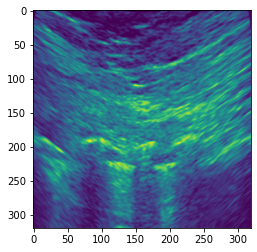

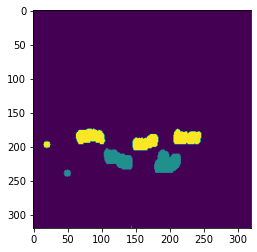

In [16]:
imgnum = 0 #30 for s, 0 for ns

print(train_files[0][imgnum]["image"])
print(train_files[0][imgnum]["label"])

img = itk.imread(train_files[0][imgnum]["image"])
arrimg = itk.GetArrayFromImage(img)
img = itk.imread(train_files[0][imgnum]["label"])
arrlbl = itk.GetArrayFromImage(img)

plt.subplots()
plt.imshow(arrimg[0,:,:])
plt.subplots()
plt.imshow(arrlbl[0,:,:])
print("Labels = ", arrlbl[:,:,:].min(), "-", arrlbl[:,:,:].max())

In [17]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=['image','label']),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        Lambdad(
            func=lambda x: np.where(x==3,1,x),
            keys=['label']),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slices,
            axis=3,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=2,
            keys=['image', 'label']),
        RandZoomd(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keep_size=True,
            mode=['trilinear', 'nearest'],
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=['image', 'label']),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        Lambdad(
            func=lambda x: np.where(x==3,1,x),
            keys=['label']),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slices,
            center_slice=30,
            axis=3,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

In [18]:
train_ds = [CacheDataset(data=train_files[i], transform=train_transforms,cache_rate=1.0, num_workers=num_workers_tr)
            for i in range(num_folds)]
train_loader = [DataLoader(train_ds[i], batch_size=batch_size_tr, shuffle=True, num_workers=num_workers_tr) 
                for i in range(num_folds)]

val_ds = [CacheDataset(data=val_files[i], transform=val_transforms, cache_rate=1.0, num_workers=num_workers_vl)
          for i in range(num_folds)]
val_loader = [DataLoader(val_ds[i], batch_size=batch_size_vl, num_workers=num_workers_vl)
              for i in range(num_folds)]

Loading dataset: 100%|████████████████████████████| 3/3 [00:00<00:00, 10.44it/s]


torch.Size([2, 1, 320, 320, 48])
torch.Size([1, 320, 320, 48])
image shape: torch.Size([1, 320, 320, 48]), label shape: torch.Size([1, 320, 320, 48])


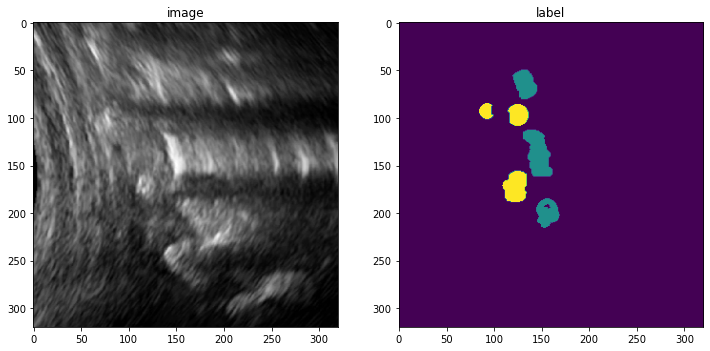

tensor(0.) tensor(2.)


In [21]:
imgnum = 0
check_data = first(val_loader[0])
image, label = (check_data["image"][imgnum], check_data["label"][imgnum])
print(check_data["image"].shape)
print(image.shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0, :, :, 24], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, 24])
plt.show()
print(label.min(), label.max())

In [22]:
device = torch.device("cuda:"+str(device_num))


In [23]:
def vfold_train(vfold_num, train_loader, val_loader):
    model = UNet(
        dimensions=net_dims,
        in_channels=net_in_channels,
        out_channels=num_classes,
        channels=net_channels,
        strides=net_strides,
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)
    dice_metric = DiceMetric(include_background=False, reduction="mean")

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"{vfold_num}: epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
                  f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"{vfold_num} epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (size_x, size_y, num_slices)
                    sw_batch_size = batch_size_vl
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if epoch > 100:
                    metric = (metric_values[-1]+metric_values[-2]+metric_values[-3])/3
                    if metric > best_metric:
                        best_metric = metric
                        best_metric_epoch = epoch + 1
                        torch.save(model.state_dict(), model_filename_base+'best_model.vfold_'+str(vfold_num)+'.pth')
                        print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )
                torch.save(model.state_dict(), model_filename_base+'last_model.vfold_'+str(vfold_num)+'.pth')

    np.save(model_filename_base+"loss_"+str(vfold_num)+".npy", epoch_loss_values)
    np.save(model_filename_base+"val_dice_"+str(vfold_num)+".npy", metric_values)

    

In [ ]:
for i in range(0,num_folds,num_devices):
        vfold_train(i, train_loader[i], val_loader[i])

----------
0: epoch 1/1000
1/1, train_loss: 0.8137
2/1, train_loss: 0.8078
3/1, train_loss: 0.7981
4/1, train_loss: 0.7999
5/1, train_loss: 0.7945
0 epoch 1 average loss: 0.8028
----------
0: epoch 2/1000
1/1, train_loss: 0.8013
2/1, train_loss: 0.7954
3/1, train_loss: 0.7932
4/1, train_loss: 0.7856
5/1, train_loss: 0.7892
0 epoch 2 average loss: 0.7929
current epoch: 2 current mean dice: 0.0473
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 3/1000
1/1, train_loss: 0.7860
2/1, train_loss: 0.7898
3/1, train_loss: 0.7858
4/1, train_loss: 0.7867
5/1, train_loss: 0.7853
0 epoch 3 average loss: 0.7867
----------
0: epoch 4/1000
1/1, train_loss: 0.7904
2/1, train_loss: 0.7825
3/1, train_loss: 0.7831
4/1, train_loss: 0.7773
5/1, train_loss: 0.7880
0 epoch 4 average loss: 0.7843
current epoch: 4 current mean dice: 0.0469
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 5/1000
1/1, train_loss: 0.7770
2/1, train_loss: 0.7761
3/1, train_loss: 0.7813
4/1, train_loss: 0.7724
5/1, 

4/1, train_loss: 0.6374
5/1, train_loss: 0.6494
0 epoch 38 average loss: 0.6464
current epoch: 38 current mean dice: 0.2147
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 39/1000
1/1, train_loss: 0.6491
2/1, train_loss: 0.6519
3/1, train_loss: 0.6364
4/1, train_loss: 0.6376
5/1, train_loss: 0.6461
0 epoch 39 average loss: 0.6442
----------
0: epoch 40/1000
1/1, train_loss: 0.6425
2/1, train_loss: 0.6340
3/1, train_loss: 0.6441
4/1, train_loss: 0.6404
5/1, train_loss: 0.6270
0 epoch 40 average loss: 0.6376
current epoch: 40 current mean dice: 0.2064
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 41/1000
1/1, train_loss: 0.6408
2/1, train_loss: 0.6381
3/1, train_loss: 0.6288
4/1, train_loss: 0.6454
5/1, train_loss: 0.6300
0 epoch 41 average loss: 0.6366
----------
0: epoch 42/1000
1/1, train_loss: 0.6362
2/1, train_loss: 0.6422
3/1, train_loss: 0.6299
4/1, train_loss: 0.6450
5/1, train_loss: 0.6335
0 epoch 42 average loss: 0.6374
current epoch: 42 current mean dice: 0

4/1, train_loss: 0.5270
5/1, train_loss: 0.5205
0 epoch 75 average loss: 0.5263
----------
0: epoch 76/1000
1/1, train_loss: 0.5235
2/1, train_loss: 0.5209
3/1, train_loss: 0.5184
4/1, train_loss: 0.5235
5/1, train_loss: 0.5235
0 epoch 76 average loss: 0.5220
current epoch: 76 current mean dice: 0.2968
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 77/1000
1/1, train_loss: 0.5064
2/1, train_loss: 0.5264
3/1, train_loss: 0.4988
4/1, train_loss: 0.5321
5/1, train_loss: 0.5130
0 epoch 77 average loss: 0.5153
----------
0: epoch 78/1000
1/1, train_loss: 0.5137
2/1, train_loss: 0.5204
3/1, train_loss: 0.4989
4/1, train_loss: 0.5414
5/1, train_loss: 0.5330
0 epoch 78 average loss: 0.5215
current epoch: 78 current mean dice: 0.3735
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 79/1000
1/1, train_loss: 0.4972
2/1, train_loss: 0.5055
3/1, train_loss: 0.5175
4/1, train_loss: 0.5123
5/1, train_loss: 0.5234
0 epoch 79 average loss: 0.5112
----------
0: epoch 80/1000
1/1, train

2/1, train_loss: 0.4251
3/1, train_loss: 0.4234
4/1, train_loss: 0.4085
5/1, train_loss: 0.3929
0 epoch 112 average loss: 0.4181
saved new best metric model
current epoch: 112 current mean dice: 0.3999
best mean dice: 0.3999 at epoch: 112
----------
0: epoch 113/1000
1/1, train_loss: 0.4124
2/1, train_loss: 0.3759
3/1, train_loss: 0.4100
4/1, train_loss: 0.4274
5/1, train_loss: 0.4034
0 epoch 113 average loss: 0.4058
----------
0: epoch 114/1000
1/1, train_loss: 0.4060
2/1, train_loss: 0.3958
3/1, train_loss: 0.3872
4/1, train_loss: 0.4451
5/1, train_loss: 0.3928
0 epoch 114 average loss: 0.4054
saved new best metric model
current epoch: 114 current mean dice: 0.4082
best mean dice: 0.4082 at epoch: 114
----------
0: epoch 115/1000
1/1, train_loss: 0.3978
2/1, train_loss: 0.3904
3/1, train_loss: 0.4050
4/1, train_loss: 0.4064
5/1, train_loss: 0.4158
0 epoch 115 average loss: 0.4031
----------
0: epoch 116/1000
1/1, train_loss: 0.3837
2/1, train_loss: 0.4280
3/1, train_loss: 0.3695
4/1,

1/1, train_loss: 0.3258
2/1, train_loss: 0.3239
3/1, train_loss: 0.3105
4/1, train_loss: 0.2955
5/1, train_loss: 0.3206
0 epoch 148 average loss: 0.3153
current epoch: 148 current mean dice: 0.4328
best mean dice: 0.4779 at epoch: 144
----------
0: epoch 149/1000
1/1, train_loss: 0.3312
2/1, train_loss: 0.3128
3/1, train_loss: 0.3021
4/1, train_loss: 0.3172
5/1, train_loss: 0.3034
0 epoch 149 average loss: 0.3134
----------
0: epoch 150/1000
1/1, train_loss: 0.3191
2/1, train_loss: 0.3149
3/1, train_loss: 0.2894
4/1, train_loss: 0.3007
5/1, train_loss: 0.3259
0 epoch 150 average loss: 0.3100
current epoch: 150 current mean dice: 0.4319
best mean dice: 0.4779 at epoch: 144
----------
0: epoch 151/1000
1/1, train_loss: 0.2916
2/1, train_loss: 0.2925
3/1, train_loss: 0.3321
4/1, train_loss: 0.2973
5/1, train_loss: 0.3115
0 epoch 151 average loss: 0.3050
----------
0: epoch 152/1000
1/1, train_loss: 0.2631
2/1, train_loss: 0.3279
3/1, train_loss: 0.3004
4/1, train_loss: 0.3473
5/1, train_l

0 epoch 184 average loss: 0.2441
current epoch: 184 current mean dice: 0.4557
best mean dice: 0.4982 at epoch: 178
----------
0: epoch 185/1000
1/1, train_loss: 0.2468
2/1, train_loss: 0.2563
3/1, train_loss: 0.2604
4/1, train_loss: 0.2320
5/1, train_loss: 0.2348
0 epoch 185 average loss: 0.2461
----------
0: epoch 186/1000
1/1, train_loss: 0.2296
2/1, train_loss: 0.2814
3/1, train_loss: 0.2308
4/1, train_loss: 0.2207
5/1, train_loss: 0.2418
0 epoch 186 average loss: 0.2408
current epoch: 186 current mean dice: 0.4907
best mean dice: 0.4982 at epoch: 178
----------
0: epoch 187/1000
1/1, train_loss: 0.2493
2/1, train_loss: 0.2343
3/1, train_loss: 0.2457
4/1, train_loss: 0.2351
5/1, train_loss: 0.2360
0 epoch 187 average loss: 0.2401
----------
0: epoch 188/1000
1/1, train_loss: 0.2263
2/1, train_loss: 0.2574
3/1, train_loss: 0.2418
4/1, train_loss: 0.2243
5/1, train_loss: 0.2168
0 epoch 188 average loss: 0.2333
saved new best metric model
current epoch: 188 current mean dice: 0.4990
be

0 epoch 220 average loss: 0.1902
current epoch: 220 current mean dice: 0.5136
best mean dice: 0.5480 at epoch: 216
----------
0: epoch 221/1000
1/1, train_loss: 0.2020
2/1, train_loss: 0.1819
3/1, train_loss: 0.1827
4/1, train_loss: 0.1706
5/1, train_loss: 0.1992
0 epoch 221 average loss: 0.1873
----------
0: epoch 222/1000
1/1, train_loss: 0.2013
2/1, train_loss: 0.1929
3/1, train_loss: 0.1756
4/1, train_loss: 0.1931
5/1, train_loss: 0.1956
0 epoch 222 average loss: 0.1917
current epoch: 222 current mean dice: 0.5147
best mean dice: 0.5480 at epoch: 216
----------
0: epoch 223/1000
1/1, train_loss: 0.1863
2/1, train_loss: 0.1990
3/1, train_loss: 0.1806
4/1, train_loss: 0.1829
5/1, train_loss: 0.1926
0 epoch 223 average loss: 0.1883
----------
0: epoch 224/1000
1/1, train_loss: 0.1877
2/1, train_loss: 0.1915
3/1, train_loss: 0.2052
4/1, train_loss: 0.1605
5/1, train_loss: 0.2042
0 epoch 224 average loss: 0.1898
current epoch: 224 current mean dice: 0.5272
best mean dice: 0.5480 at epoc

1/1, train_loss: 0.1679
2/1, train_loss: 0.1580
3/1, train_loss: 0.1542
4/1, train_loss: 0.1528
5/1, train_loss: 0.1638
0 epoch 257 average loss: 0.1593
----------
0: epoch 258/1000
1/1, train_loss: 0.1530
2/1, train_loss: 0.1601
3/1, train_loss: 0.1810
4/1, train_loss: 0.1523
5/1, train_loss: 0.1788
0 epoch 258 average loss: 0.1650
current epoch: 258 current mean dice: 0.5696
best mean dice: 0.5779 at epoch: 252
----------
0: epoch 259/1000
1/1, train_loss: 0.1610
2/1, train_loss: 0.1654
3/1, train_loss: 0.1727
4/1, train_loss: 0.1580
5/1, train_loss: 0.1585
0 epoch 259 average loss: 0.1631
----------
0: epoch 260/1000
1/1, train_loss: 0.1668
2/1, train_loss: 0.1521
3/1, train_loss: 0.1634
4/1, train_loss: 0.1683
5/1, train_loss: 0.1591
0 epoch 260 average loss: 0.1620
current epoch: 260 current mean dice: 0.5775
best mean dice: 0.5779 at epoch: 252
----------
0: epoch 261/1000
1/1, train_loss: 0.1744
2/1, train_loss: 0.1648
3/1, train_loss: 0.1657
4/1, train_loss: 0.1493
5/1, train_l

0 epoch 293 average loss: 0.1462
----------
0: epoch 294/1000
1/1, train_loss: 0.1330
2/1, train_loss: 0.1640
3/1, train_loss: 0.1414
4/1, train_loss: 0.1378
5/1, train_loss: 0.1450
0 epoch 294 average loss: 0.1442
current epoch: 294 current mean dice: 0.5687
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 295/1000
1/1, train_loss: 0.1333
2/1, train_loss: 0.1525
3/1, train_loss: 0.1446
4/1, train_loss: 0.1412
5/1, train_loss: 0.1459
0 epoch 295 average loss: 0.1435
----------
0: epoch 296/1000
1/1, train_loss: 0.1423
2/1, train_loss: 0.1438
3/1, train_loss: 0.1412
4/1, train_loss: 0.1432
5/1, train_loss: 0.1510
0 epoch 296 average loss: 0.1443
current epoch: 296 current mean dice: 0.5695
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 297/1000
1/1, train_loss: 0.1387
2/1, train_loss: 0.1515
3/1, train_loss: 0.1530
4/1, train_loss: 0.1356
5/1, train_loss: 0.1445
0 epoch 297 average loss: 0.1447
----------
0: epoch 298/1000
1/1, train_loss: 0.1528
2/1, train_loss: 0.129

0 epoch 330 average loss: 0.1320
current epoch: 330 current mean dice: 0.5654
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 331/1000
1/1, train_loss: 0.1352
2/1, train_loss: 0.1322
3/1, train_loss: 0.1169
4/1, train_loss: 0.1381
5/1, train_loss: 0.1383
0 epoch 331 average loss: 0.1321
----------
0: epoch 332/1000
1/1, train_loss: 0.1272
2/1, train_loss: 0.1430
3/1, train_loss: 0.1265
4/1, train_loss: 0.1277
5/1, train_loss: 0.1301
0 epoch 332 average loss: 0.1309
current epoch: 332 current mean dice: 0.5698
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 333/1000
1/1, train_loss: 0.1206
2/1, train_loss: 0.1363
3/1, train_loss: 0.1243
4/1, train_loss: 0.1317
5/1, train_loss: 0.1466
0 epoch 333 average loss: 0.1319
----------
0: epoch 334/1000
1/1, train_loss: 0.1235
2/1, train_loss: 0.1245
3/1, train_loss: 0.1323
4/1, train_loss: 0.1290
5/1, train_loss: 0.1363
0 epoch 334 average loss: 0.1291
current epoch: 334 current mean dice: 0.5655
best mean dice: 0.5873 at epoc

2/1, train_loss: 0.1177
3/1, train_loss: 0.1247
4/1, train_loss: 0.1315
5/1, train_loss: 0.1253
0 epoch 367 average loss: 0.1247
----------
0: epoch 368/1000
1/1, train_loss: 0.1287
2/1, train_loss: 0.1202
3/1, train_loss: 0.1241
4/1, train_loss: 0.1280
5/1, train_loss: 0.1208
0 epoch 368 average loss: 0.1244
current epoch: 368 current mean dice: 0.5453
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 369/1000
1/1, train_loss: 0.1164
2/1, train_loss: 0.1203
3/1, train_loss: 0.1244
4/1, train_loss: 0.1216
5/1, train_loss: 0.1301
0 epoch 369 average loss: 0.1226
----------
0: epoch 370/1000
1/1, train_loss: 0.1127
2/1, train_loss: 0.1175
3/1, train_loss: 0.1316
4/1, train_loss: 0.1338
5/1, train_loss: 0.1363
0 epoch 370 average loss: 0.1264
current epoch: 370 current mean dice: 0.5378
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 371/1000
1/1, train_loss: 0.1220
2/1, train_loss: 0.1247
3/1, train_loss: 0.1184
4/1, train_loss: 0.1157
5/1, train_loss: 0.1267
0 epoch 371 

2/1, train_loss: 0.1276
3/1, train_loss: 0.1136
4/1, train_loss: 0.1207
5/1, train_loss: 0.1143
0 epoch 404 average loss: 0.1178
current epoch: 404 current mean dice: 0.5589
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 405/1000
1/1, train_loss: 0.1057
2/1, train_loss: 0.1048
3/1, train_loss: 0.1252
4/1, train_loss: 0.1131
5/1, train_loss: 0.1220
0 epoch 405 average loss: 0.1141
----------
0: epoch 406/1000
1/1, train_loss: 0.1207
2/1, train_loss: 0.1157
3/1, train_loss: 0.1124
4/1, train_loss: 0.1168
5/1, train_loss: 0.1177
0 epoch 406 average loss: 0.1166
current epoch: 406 current mean dice: 0.5503
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 407/1000
1/1, train_loss: 0.1188
2/1, train_loss: 0.1131
3/1, train_loss: 0.1064
4/1, train_loss: 0.1259
5/1, train_loss: 0.1262
0 epoch 407 average loss: 0.1181
----------
0: epoch 408/1000
1/1, train_loss: 0.1188
2/1, train_loss: 0.1154
3/1, train_loss: 0.1159
4/1, train_loss: 0.1168
5/1, train_loss: 0.1141
0 epoch 408 

1/1, train_loss: 0.1143
2/1, train_loss: 0.1056
3/1, train_loss: 0.1143
4/1, train_loss: 0.1141
5/1, train_loss: 0.1032
0 epoch 441 average loss: 0.1103
----------
0: epoch 442/1000
1/1, train_loss: 0.1034
2/1, train_loss: 0.1118
3/1, train_loss: 0.1152
4/1, train_loss: 0.1200
5/1, train_loss: 0.1141
0 epoch 442 average loss: 0.1129
current epoch: 442 current mean dice: 0.5341
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 443/1000
1/1, train_loss: 0.1126
2/1, train_loss: 0.1036
3/1, train_loss: 0.1128
4/1, train_loss: 0.1054
5/1, train_loss: 0.1076
0 epoch 443 average loss: 0.1084
----------
0: epoch 444/1000
1/1, train_loss: 0.1159
2/1, train_loss: 0.1035
3/1, train_loss: 0.0994
4/1, train_loss: 0.1053
5/1, train_loss: 0.1227
0 epoch 444 average loss: 0.1094
current epoch: 444 current mean dice: 0.5241
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 445/1000
1/1, train_loss: 0.1253
2/1, train_loss: 0.1084
3/1, train_loss: 0.1078
4/1, train_loss: 0.1125
5/1, train_l

1/1, train_loss: 0.1026
2/1, train_loss: 0.1038
3/1, train_loss: 0.1136
4/1, train_loss: 0.1142
5/1, train_loss: 0.1071
0 epoch 478 average loss: 0.1083
current epoch: 478 current mean dice: 0.5524
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 479/1000
1/1, train_loss: 0.1045
2/1, train_loss: 0.1170
3/1, train_loss: 0.1084
4/1, train_loss: 0.1123
5/1, train_loss: 0.1108
0 epoch 479 average loss: 0.1106
----------
0: epoch 480/1000
1/1, train_loss: 0.1196
2/1, train_loss: 0.1065
3/1, train_loss: 0.1036
4/1, train_loss: 0.1015
5/1, train_loss: 0.0979
0 epoch 480 average loss: 0.1058
current epoch: 480 current mean dice: 0.5493
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 481/1000
1/1, train_loss: 0.1004
2/1, train_loss: 0.1176
3/1, train_loss: 0.0981
4/1, train_loss: 0.1077
5/1, train_loss: 0.1086
0 epoch 481 average loss: 0.1065
----------
0: epoch 482/1000
1/1, train_loss: 0.1019
2/1, train_loss: 0.1103
3/1, train_loss: 0.1022
4/1, train_loss: 0.1068
5/1, train_l

1/1, train_loss: 0.0956
2/1, train_loss: 0.0986
3/1, train_loss: 0.1010
4/1, train_loss: 0.1074
5/1, train_loss: 0.1112
0 epoch 515 average loss: 0.1027
----------
0: epoch 516/1000
1/1, train_loss: 0.1031
2/1, train_loss: 0.1070
3/1, train_loss: 0.1033
4/1, train_loss: 0.1074
5/1, train_loss: 0.0960
0 epoch 516 average loss: 0.1033
current epoch: 516 current mean dice: 0.5543
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 517/1000
1/1, train_loss: 0.1076
2/1, train_loss: 0.1013
3/1, train_loss: 0.0990
4/1, train_loss: 0.1023
5/1, train_loss: 0.1008
0 epoch 517 average loss: 0.1022
----------
0: epoch 518/1000
1/1, train_loss: 0.1029
2/1, train_loss: 0.0899
3/1, train_loss: 0.0959
4/1, train_loss: 0.1087
5/1, train_loss: 0.0957
0 epoch 518 average loss: 0.0986
current epoch: 518 current mean dice: 0.5504
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 519/1000
1/1, train_loss: 0.0984
2/1, train_loss: 0.0930
3/1, train_loss: 0.1000
4/1, train_loss: 0.1056
5/1, train_l

1/1, train_loss: 0.0970
2/1, train_loss: 0.0949
3/1, train_loss: 0.1135
4/1, train_loss: 0.1072
5/1, train_loss: 0.0938
0 epoch 552 average loss: 0.1013
current epoch: 552 current mean dice: 0.5700
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 553/1000
1/1, train_loss: 0.0965
2/1, train_loss: 0.0944
3/1, train_loss: 0.0899
4/1, train_loss: 0.1045
5/1, train_loss: 0.1007
0 epoch 553 average loss: 0.0972
----------
0: epoch 554/1000
1/1, train_loss: 0.1064
2/1, train_loss: 0.0993
3/1, train_loss: 0.0973
4/1, train_loss: 0.1005
5/1, train_loss: 0.0912
0 epoch 554 average loss: 0.0989
current epoch: 554 current mean dice: 0.5594
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 555/1000
1/1, train_loss: 0.0952
2/1, train_loss: 0.0981
3/1, train_loss: 0.1075
4/1, train_loss: 0.1032
5/1, train_loss: 0.0962
0 epoch 555 average loss: 0.1000
----------
0: epoch 556/1000
1/1, train_loss: 0.0964
2/1, train_loss: 0.0965
3/1, train_loss: 0.1027
4/1, train_loss: 0.0941
5/1, train_l

1/1, train_loss: 0.0967
2/1, train_loss: 0.1001
3/1, train_loss: 0.1098
4/1, train_loss: 0.0930
5/1, train_loss: 0.0958
0 epoch 589 average loss: 0.0991
----------
0: epoch 590/1000
1/1, train_loss: 0.1068
2/1, train_loss: 0.0920
3/1, train_loss: 0.0997
4/1, train_loss: 0.0952
5/1, train_loss: 0.1040
0 epoch 590 average loss: 0.0995
current epoch: 590 current mean dice: 0.5380
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 591/1000
1/1, train_loss: 0.0941
2/1, train_loss: 0.0930
3/1, train_loss: 0.0918
4/1, train_loss: 0.1083
5/1, train_loss: 0.1054
0 epoch 591 average loss: 0.0985
----------
0: epoch 592/1000
1/1, train_loss: 0.0919
2/1, train_loss: 0.1089
3/1, train_loss: 0.1024
4/1, train_loss: 0.0883
5/1, train_loss: 0.1010
0 epoch 592 average loss: 0.0985
current epoch: 592 current mean dice: 0.5425
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 593/1000
1/1, train_loss: 0.1034
2/1, train_loss: 0.0933
3/1, train_loss: 0.0905
4/1, train_loss: 0.1036
5/1, train_l

1/1, train_loss: 0.0962
2/1, train_loss: 0.1028
3/1, train_loss: 0.0929
4/1, train_loss: 0.0952
5/1, train_loss: 0.0881
0 epoch 626 average loss: 0.0950
current epoch: 626 current mean dice: 0.5536
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 627/1000
1/1, train_loss: 0.0982
2/1, train_loss: 0.0898
3/1, train_loss: 0.1064
4/1, train_loss: 0.0952
5/1, train_loss: 0.0908
0 epoch 627 average loss: 0.0961
----------
0: epoch 628/1000
1/1, train_loss: 0.1002
2/1, train_loss: 0.0943
3/1, train_loss: 0.0978
4/1, train_loss: 0.0992
5/1, train_loss: 0.0924
0 epoch 628 average loss: 0.0968
current epoch: 628 current mean dice: 0.5577
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 629/1000
1/1, train_loss: 0.0944
2/1, train_loss: 0.0906
3/1, train_loss: 0.0931
4/1, train_loss: 0.0788
5/1, train_loss: 0.0957
0 epoch 629 average loss: 0.0905
----------
0: epoch 630/1000
1/1, train_loss: 0.0903
2/1, train_loss: 0.0861
3/1, train_loss: 0.0898
4/1, train_loss: 0.0980
5/1, train_l

1/1, train_loss: 0.0839
2/1, train_loss: 0.0945
3/1, train_loss: 0.0887
4/1, train_loss: 0.0933
5/1, train_loss: 0.1004
0 epoch 663 average loss: 0.0922
----------
0: epoch 664/1000
1/1, train_loss: 0.0936
2/1, train_loss: 0.0979
3/1, train_loss: 0.0982
4/1, train_loss: 0.0914
5/1, train_loss: 0.0877
0 epoch 664 average loss: 0.0937
current epoch: 664 current mean dice: 0.5527
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 665/1000
1/1, train_loss: 0.0892
2/1, train_loss: 0.0889
3/1, train_loss: 0.0888
4/1, train_loss: 0.0980
5/1, train_loss: 0.0931
0 epoch 665 average loss: 0.0916
----------
0: epoch 666/1000
1/1, train_loss: 0.0886
2/1, train_loss: 0.0967
3/1, train_loss: 0.0932
4/1, train_loss: 0.0932
5/1, train_loss: 0.0878
0 epoch 666 average loss: 0.0919
current epoch: 666 current mean dice: 0.5425
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 667/1000
1/1, train_loss: 0.0945
2/1, train_loss: 0.0905
3/1, train_loss: 0.0866
4/1, train_loss: 0.0959
5/1, train_l

1/1, train_loss: 0.0826
2/1, train_loss: 0.1005
3/1, train_loss: 0.0967
4/1, train_loss: 0.0870
5/1, train_loss: 0.1006
0 epoch 700 average loss: 0.0935
current epoch: 700 current mean dice: 0.5619
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 701/1000
1/1, train_loss: 0.0988
2/1, train_loss: 0.0902
3/1, train_loss: 0.0874
4/1, train_loss: 0.0905
5/1, train_loss: 0.0822
0 epoch 701 average loss: 0.0898
----------
0: epoch 702/1000
1/1, train_loss: 0.0868
2/1, train_loss: 0.0967
3/1, train_loss: 0.0978
4/1, train_loss: 0.0839
5/1, train_loss: 0.0949
0 epoch 702 average loss: 0.0920
current epoch: 702 current mean dice: 0.5604
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 703/1000
1/1, train_loss: 0.0919
2/1, train_loss: 0.0810
3/1, train_loss: 0.0914
4/1, train_loss: 0.0845
5/1, train_loss: 0.0890
0 epoch 703 average loss: 0.0876
----------
0: epoch 704/1000
1/1, train_loss: 0.0877
2/1, train_loss: 0.0932
3/1, train_loss: 0.0855
4/1, train_loss: 0.0891
5/1, train_l

1/1, train_loss: 0.0873
2/1, train_loss: 0.0905
3/1, train_loss: 0.0877
4/1, train_loss: 0.0720
5/1, train_loss: 0.0941
0 epoch 737 average loss: 0.0863
----------
0: epoch 738/1000
1/1, train_loss: 0.0822
2/1, train_loss: 0.0847
3/1, train_loss: 0.0933
4/1, train_loss: 0.0827
5/1, train_loss: 0.0854
0 epoch 738 average loss: 0.0857
current epoch: 738 current mean dice: 0.5505
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 739/1000
1/1, train_loss: 0.0782
2/1, train_loss: 0.0874
3/1, train_loss: 0.0882
4/1, train_loss: 0.0915
5/1, train_loss: 0.0802
0 epoch 739 average loss: 0.0851
----------
0: epoch 740/1000
1/1, train_loss: 0.0860
2/1, train_loss: 0.0792
3/1, train_loss: 0.0809
4/1, train_loss: 0.0955
5/1, train_loss: 0.0857
0 epoch 740 average loss: 0.0854
current epoch: 740 current mean dice: 0.5539
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 741/1000
1/1, train_loss: 0.0828
2/1, train_loss: 0.0843
3/1, train_loss: 0.0820
4/1, train_loss: 0.0851
5/1, train_l

1/1, train_loss: 0.0900
2/1, train_loss: 0.0787
3/1, train_loss: 0.0872
4/1, train_loss: 0.0811
5/1, train_loss: 0.0872
0 epoch 774 average loss: 0.0848
current epoch: 774 current mean dice: 0.5688
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 775/1000
1/1, train_loss: 0.0889
2/1, train_loss: 0.0888
3/1, train_loss: 0.0847
4/1, train_loss: 0.0821
5/1, train_loss: 0.0878
0 epoch 775 average loss: 0.0865
----------
0: epoch 776/1000
1/1, train_loss: 0.0826
2/1, train_loss: 0.0838
3/1, train_loss: 0.0834
4/1, train_loss: 0.0829
5/1, train_loss: 0.0915
0 epoch 776 average loss: 0.0849
current epoch: 776 current mean dice: 0.5639
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 777/1000
1/1, train_loss: 0.0901
2/1, train_loss: 0.0815
3/1, train_loss: 0.0825
4/1, train_loss: 0.0822
5/1, train_loss: 0.0945
0 epoch 777 average loss: 0.0862
----------
0: epoch 778/1000
1/1, train_loss: 0.0909
2/1, train_loss: 0.0729
3/1, train_loss: 0.0845
4/1, train_loss: 0.0984
5/1, train_l

1/1, train_loss: 0.0916
2/1, train_loss: 0.0854
3/1, train_loss: 0.0761
4/1, train_loss: 0.0727
5/1, train_loss: 0.0921
0 epoch 811 average loss: 0.0836
----------
0: epoch 812/1000
1/1, train_loss: 0.0844
2/1, train_loss: 0.0808
3/1, train_loss: 0.0761
4/1, train_loss: 0.0790
5/1, train_loss: 0.0861
0 epoch 812 average loss: 0.0813
current epoch: 812 current mean dice: 0.5521
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 813/1000
1/1, train_loss: 0.0785
2/1, train_loss: 0.0801
3/1, train_loss: 0.0910
4/1, train_loss: 0.0829
5/1, train_loss: 0.0889
0 epoch 813 average loss: 0.0843
----------
0: epoch 814/1000
1/1, train_loss: 0.0840
2/1, train_loss: 0.0714
3/1, train_loss: 0.0895
4/1, train_loss: 0.0896
5/1, train_loss: 0.0824
0 epoch 814 average loss: 0.0834
current epoch: 814 current mean dice: 0.5513
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 815/1000
1/1, train_loss: 0.0796
2/1, train_loss: 0.0931
3/1, train_loss: 0.0788
4/1, train_loss: 0.0877
5/1, train_l

1/1, train_loss: 0.0835
2/1, train_loss: 0.0876
3/1, train_loss: 0.0843
4/1, train_loss: 0.0758
5/1, train_loss: 0.0747
0 epoch 848 average loss: 0.0812
current epoch: 848 current mean dice: 0.5593
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 849/1000
1/1, train_loss: 0.0895
2/1, train_loss: 0.0751
3/1, train_loss: 0.0881
4/1, train_loss: 0.0782
5/1, train_loss: 0.0758
0 epoch 849 average loss: 0.0813
----------
0: epoch 850/1000
1/1, train_loss: 0.0776
2/1, train_loss: 0.0810
3/1, train_loss: 0.0686
4/1, train_loss: 0.0836
5/1, train_loss: 0.0811
0 epoch 850 average loss: 0.0784
current epoch: 850 current mean dice: 0.5670
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 851/1000
1/1, train_loss: 0.0855
2/1, train_loss: 0.0928
3/1, train_loss: 0.0869
4/1, train_loss: 0.0779
5/1, train_loss: 0.0817
0 epoch 851 average loss: 0.0849
----------
0: epoch 852/1000
1/1, train_loss: 0.0866
2/1, train_loss: 0.0823
3/1, train_loss: 0.0816
4/1, train_loss: 0.0899
5/1, train_l

1/1, train_loss: 0.0806
2/1, train_loss: 0.0820
3/1, train_loss: 0.0812
4/1, train_loss: 0.0754
5/1, train_loss: 0.0960
0 epoch 885 average loss: 0.0830
----------
0: epoch 886/1000
1/1, train_loss: 0.0873
2/1, train_loss: 0.0840
3/1, train_loss: 0.0767
4/1, train_loss: 0.0791
5/1, train_loss: 0.0776
0 epoch 886 average loss: 0.0810
current epoch: 886 current mean dice: 0.5565
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 887/1000
1/1, train_loss: 0.0780
2/1, train_loss: 0.0841
3/1, train_loss: 0.0769
4/1, train_loss: 0.0887
5/1, train_loss: 0.0897
0 epoch 887 average loss: 0.0835
----------
0: epoch 888/1000
1/1, train_loss: 0.0704
2/1, train_loss: 0.0721
3/1, train_loss: 0.0776
4/1, train_loss: 0.0827
5/1, train_loss: 0.0831
0 epoch 888 average loss: 0.0772
current epoch: 888 current mean dice: 0.5496
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 889/1000
1/1, train_loss: 0.0801
2/1, train_loss: 0.0796
3/1, train_loss: 0.0912
4/1, train_loss: 0.0780
5/1, train_l

1/1, train_loss: 0.0901
2/1, train_loss: 0.0774
3/1, train_loss: 0.0711
4/1, train_loss: 0.0826
5/1, train_loss: 0.0778
0 epoch 922 average loss: 0.0798
current epoch: 922 current mean dice: 0.5625
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 923/1000
1/1, train_loss: 0.0753
2/1, train_loss: 0.0888
3/1, train_loss: 0.0771
4/1, train_loss: 0.0790
5/1, train_loss: 0.0715
0 epoch 923 average loss: 0.0783
----------
0: epoch 924/1000
1/1, train_loss: 0.0741
2/1, train_loss: 0.0824
3/1, train_loss: 0.0781
4/1, train_loss: 0.0859
5/1, train_loss: 0.0703
0 epoch 924 average loss: 0.0782
current epoch: 924 current mean dice: 0.5604
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 925/1000
1/1, train_loss: 0.0787
2/1, train_loss: 0.0745
3/1, train_loss: 0.0744
4/1, train_loss: 0.0784
5/1, train_loss: 0.0720
0 epoch 925 average loss: 0.0756
----------
0: epoch 926/1000
1/1, train_loss: 0.0666
2/1, train_loss: 0.0785
3/1, train_loss: 0.0867
4/1, train_loss: 0.0769
5/1, train_l

1/1, train_loss: 0.0793
2/1, train_loss: 0.0786
3/1, train_loss: 0.0853
4/1, train_loss: 0.0785
5/1, train_loss: 0.0789
0 epoch 959 average loss: 0.0801
----------
0: epoch 960/1000
1/1, train_loss: 0.0883
2/1, train_loss: 0.0712
3/1, train_loss: 0.0820
4/1, train_loss: 0.0682
5/1, train_loss: 0.0783
0 epoch 960 average loss: 0.0776
current epoch: 960 current mean dice: 0.5674
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 961/1000
1/1, train_loss: 0.0787
2/1, train_loss: 0.0818
3/1, train_loss: 0.0758
4/1, train_loss: 0.0831
5/1, train_loss: 0.0746
0 epoch 961 average loss: 0.0788
----------
0: epoch 962/1000
1/1, train_loss: 0.0798
2/1, train_loss: 0.0791
3/1, train_loss: 0.0829
4/1, train_loss: 0.0692
5/1, train_loss: 0.0815
0 epoch 962 average loss: 0.0785
current epoch: 962 current mean dice: 0.5682
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 963/1000
1/1, train_loss: 0.0790
2/1, train_loss: 0.0744
3/1, train_loss: 0.0724
4/1, train_loss: 0.0784
5/1, train_l

1/1, train_loss: 0.0808
2/1, train_loss: 0.0750
3/1, train_loss: 0.0809
4/1, train_loss: 0.0786
5/1, train_loss: 0.0737
0 epoch 996 average loss: 0.0778
current epoch: 996 current mean dice: 0.5731
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 997/1000
1/1, train_loss: 0.0744
2/1, train_loss: 0.0725
3/1, train_loss: 0.0775
4/1, train_loss: 0.0772
5/1, train_loss: 0.0762
0 epoch 997 average loss: 0.0755
----------
0: epoch 998/1000
1/1, train_loss: 0.0774
2/1, train_loss: 0.0793
3/1, train_loss: 0.0798
4/1, train_loss: 0.0777
5/1, train_loss: 0.0754
0 epoch 998 average loss: 0.0779
current epoch: 998 current mean dice: 0.5660
best mean dice: 0.5873 at epoch: 274
----------
0: epoch 999/1000
1/1, train_loss: 0.0789
2/1, train_loss: 0.0818
3/1, train_loss: 0.0770
4/1, train_loss: 0.0744
5/1, train_loss: 0.0816
0 epoch 999 average loss: 0.0787
----------
0: epoch 1000/1000
1/1, train_loss: 0.0777
2/1, train_loss: 0.0789
3/1, train_loss: 0.0757
4/1, train_loss: 0.0788
5/1, train_

2/1, train_loss: 0.6965
3/1, train_loss: 0.7108
4/1, train_loss: 0.6916
5/1, train_loss: 0.6894
1 epoch 33 average loss: 0.6951
----------
1: epoch 34/1000
1/1, train_loss: 0.6928
2/1, train_loss: 0.6928
3/1, train_loss: 0.6994
4/1, train_loss: 0.7018
5/1, train_loss: 0.6913
1 epoch 34 average loss: 0.6956
current epoch: 34 current mean dice: 0.2777
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 35/1000
1/1, train_loss: 0.6836
2/1, train_loss: 0.6934
3/1, train_loss: 0.6861
4/1, train_loss: 0.6993
5/1, train_loss: 0.6853
1 epoch 35 average loss: 0.6895
----------
1: epoch 36/1000
1/1, train_loss: 0.6958
2/1, train_loss: 0.6828
3/1, train_loss: 0.6964
4/1, train_loss: 0.6774
5/1, train_loss: 0.6933
1 epoch 36 average loss: 0.6892
current epoch: 36 current mean dice: 0.2668
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 37/1000
1/1, train_loss: 0.6806
2/1, train_loss: 0.6874
3/1, train_loss: 0.6957
4/1, train_loss: 0.6838
5/1, train_loss: 0.6888
1 epoch 37 average los

1 epoch 70 average loss: 0.5292
current epoch: 70 current mean dice: 0.3638
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 71/1000
1/1, train_loss: 0.4963
2/1, train_loss: 0.5351
3/1, train_loss: 0.5223
4/1, train_loss: 0.5360
5/1, train_loss: 0.4978
1 epoch 71 average loss: 0.5175
----------
1: epoch 72/1000
1/1, train_loss: 0.5195
2/1, train_loss: 0.5357
3/1, train_loss: 0.5168
4/1, train_loss: 0.4965
5/1, train_loss: 0.5067
1 epoch 72 average loss: 0.5150
current epoch: 72 current mean dice: 0.4433
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 73/1000
1/1, train_loss: 0.5070
2/1, train_loss: 0.5086
3/1, train_loss: 0.5205
4/1, train_loss: 0.5142
5/1, train_loss: 0.5088
1 epoch 73 average loss: 0.5118
----------
1: epoch 74/1000
1/1, train_loss: 0.4949
2/1, train_loss: 0.4963
3/1, train_loss: 0.5173
4/1, train_loss: 0.5268
5/1, train_loss: 0.5009
1 epoch 74 average loss: 0.5072
current epoch: 74 current mean dice: 0.3632
best mean dice: -1.0000 at epoch: -1
-----

3/1, train_loss: 0.3194
4/1, train_loss: 0.3497
5/1, train_loss: 0.3409
1 epoch 107 average loss: 0.3527
----------
1: epoch 108/1000
1/1, train_loss: 0.3519
2/1, train_loss: 0.3852
3/1, train_loss: 0.3449
4/1, train_loss: 0.3711
5/1, train_loss: 0.3172
1 epoch 108 average loss: 0.3541
current epoch: 108 current mean dice: 0.4274
best mean dice: 0.4606 at epoch: 104
----------
1: epoch 109/1000
1/1, train_loss: 0.3380
2/1, train_loss: 0.3256
3/1, train_loss: 0.3377
4/1, train_loss: 0.3559
5/1, train_loss: 0.3709
1 epoch 109 average loss: 0.3457
----------
1: epoch 110/1000
1/1, train_loss: 0.3456
2/1, train_loss: 0.3326
3/1, train_loss: 0.3434
4/1, train_loss: 0.3206
5/1, train_loss: 0.3592
1 epoch 110 average loss: 0.3403
current epoch: 110 current mean dice: 0.4301
best mean dice: 0.4606 at epoch: 104
----------
1: epoch 111/1000
1/1, train_loss: 0.3074
2/1, train_loss: 0.3474
3/1, train_loss: 0.3600
4/1, train_loss: 0.3136
5/1, train_loss: 0.3508
1 epoch 111 average loss: 0.3358
---

3/1, train_loss: 0.2360
4/1, train_loss: 0.2263
5/1, train_loss: 0.2296
1 epoch 144 average loss: 0.2292
current epoch: 144 current mean dice: 0.4090
best mean dice: 0.4606 at epoch: 104
----------
1: epoch 145/1000
1/1, train_loss: 0.2246
2/1, train_loss: 0.2295
3/1, train_loss: 0.2348
4/1, train_loss: 0.2363
5/1, train_loss: 0.2150
1 epoch 145 average loss: 0.2280
----------
1: epoch 146/1000
1/1, train_loss: 0.2321
2/1, train_loss: 0.2299
3/1, train_loss: 0.2274
4/1, train_loss: 0.2238
5/1, train_loss: 0.2101
1 epoch 146 average loss: 0.2247
current epoch: 146 current mean dice: 0.4254
best mean dice: 0.4606 at epoch: 104
----------
1: epoch 147/1000
1/1, train_loss: 0.2224
2/1, train_loss: 0.2191
3/1, train_loss: 0.2470
4/1, train_loss: 0.2092
5/1, train_loss: 0.2132
1 epoch 147 average loss: 0.2222
----------
1: epoch 148/1000
1/1, train_loss: 0.2258
2/1, train_loss: 0.2244
3/1, train_loss: 0.2108
4/1, train_loss: 0.2407
5/1, train_loss: 0.2057
1 epoch 148 average loss: 0.2215
cur

1/1, train_loss: 0.1725
2/1, train_loss: 0.1823
3/1, train_loss: 0.1795
4/1, train_loss: 0.1812
5/1, train_loss: 0.1684
1 epoch 181 average loss: 0.1768
----------
1: epoch 182/1000
1/1, train_loss: 0.1622
2/1, train_loss: 0.1828
3/1, train_loss: 0.1865
4/1, train_loss: 0.1709
5/1, train_loss: 0.1780
1 epoch 182 average loss: 0.1761
current epoch: 182 current mean dice: 0.3974
best mean dice: 0.4823 at epoch: 176
----------
1: epoch 183/1000
1/1, train_loss: 0.1789
2/1, train_loss: 0.1742
3/1, train_loss: 0.1647
4/1, train_loss: 0.1752
5/1, train_loss: 0.1762
1 epoch 183 average loss: 0.1738
----------
1: epoch 184/1000
1/1, train_loss: 0.1558
2/1, train_loss: 0.1686
3/1, train_loss: 0.1797
4/1, train_loss: 0.1742
5/1, train_loss: 0.1766
1 epoch 184 average loss: 0.1710
current epoch: 184 current mean dice: 0.4175
best mean dice: 0.4823 at epoch: 176
----------
1: epoch 185/1000
1/1, train_loss: 0.1818
2/1, train_loss: 0.1595
3/1, train_loss: 0.1746
4/1, train_loss: 0.1669
5/1, train_l

1/1, train_loss: 0.1549
2/1, train_loss: 0.1524
3/1, train_loss: 0.1540
4/1, train_loss: 0.1473
5/1, train_loss: 0.1574
1 epoch 218 average loss: 0.1532
current epoch: 218 current mean dice: 0.4478
best mean dice: 0.4823 at epoch: 176
----------
1: epoch 219/1000
1/1, train_loss: 0.1426
2/1, train_loss: 0.1734
3/1, train_loss: 0.1600
4/1, train_loss: 0.1585
5/1, train_loss: 0.1557
1 epoch 219 average loss: 0.1580
----------
1: epoch 220/1000
1/1, train_loss: 0.1629
2/1, train_loss: 0.1586
3/1, train_loss: 0.1657
4/1, train_loss: 0.1490
5/1, train_loss: 0.1416
1 epoch 220 average loss: 0.1556
current epoch: 220 current mean dice: 0.4302
best mean dice: 0.4823 at epoch: 176
----------
1: epoch 221/1000
1/1, train_loss: 0.1561
2/1, train_loss: 0.1415
3/1, train_loss: 0.1493
4/1, train_loss: 0.1518
5/1, train_loss: 0.1774
1 epoch 221 average loss: 0.1552
----------
1: epoch 222/1000
1/1, train_loss: 0.1423
2/1, train_loss: 0.1530
3/1, train_loss: 0.1547
4/1, train_loss: 0.1507
5/1, train_l

1/1, train_loss: 0.1401
2/1, train_loss: 0.1308
3/1, train_loss: 0.1325
4/1, train_loss: 0.1444
5/1, train_loss: 0.1325
1 epoch 255 average loss: 0.1361
----------
1: epoch 256/1000
1/1, train_loss: 0.1307
2/1, train_loss: 0.1322
3/1, train_loss: 0.1435
4/1, train_loss: 0.1359
5/1, train_loss: 0.1320
1 epoch 256 average loss: 0.1349
current epoch: 256 current mean dice: 0.4241
best mean dice: 0.4823 at epoch: 176
----------
1: epoch 257/1000
1/1, train_loss: 0.1426
2/1, train_loss: 0.1316
3/1, train_loss: 0.1270
4/1, train_loss: 0.1377
5/1, train_loss: 0.1367
1 epoch 257 average loss: 0.1351
----------
1: epoch 258/1000
1/1, train_loss: 0.1411
2/1, train_loss: 0.1304
3/1, train_loss: 0.1380
4/1, train_loss: 0.1227
5/1, train_loss: 0.1294
1 epoch 258 average loss: 0.1323
current epoch: 258 current mean dice: 0.4419
best mean dice: 0.4823 at epoch: 176
----------
1: epoch 259/1000
1/1, train_loss: 0.1425
2/1, train_loss: 0.1280
3/1, train_loss: 0.1388
4/1, train_loss: 0.1352
5/1, train_l

1/1, train_loss: 0.1241
2/1, train_loss: 0.1242
3/1, train_loss: 0.1277
4/1, train_loss: 0.1327
5/1, train_loss: 0.1287
1 epoch 292 average loss: 0.1275
current epoch: 292 current mean dice: 0.4055
best mean dice: 0.4823 at epoch: 176
----------
1: epoch 293/1000
1/1, train_loss: 0.1212
2/1, train_loss: 0.1236
3/1, train_loss: 0.1243
4/1, train_loss: 0.1349
5/1, train_loss: 0.1186
1 epoch 293 average loss: 0.1245
----------
1: epoch 294/1000
1/1, train_loss: 0.1233
2/1, train_loss: 0.1306
3/1, train_loss: 0.1232
4/1, train_loss: 0.1248
5/1, train_loss: 0.1159
1 epoch 294 average loss: 0.1236
current epoch: 294 current mean dice: 0.4333
best mean dice: 0.4823 at epoch: 176
----------
1: epoch 295/1000
1/1, train_loss: 0.1150
2/1, train_loss: 0.1347
3/1, train_loss: 0.1260
4/1, train_loss: 0.1408
5/1, train_loss: 0.1195
1 epoch 295 average loss: 0.1272
----------
1: epoch 296/1000
1/1, train_loss: 0.1236
2/1, train_loss: 0.1195
3/1, train_loss: 0.1293
4/1, train_loss: 0.1226
5/1, train_l

1/1, train_loss: 0.1143
2/1, train_loss: 0.1213
3/1, train_loss: 0.1350
4/1, train_loss: 0.1251
5/1, train_loss: 0.1099
1 epoch 329 average loss: 0.1211
----------
1: epoch 330/1000
1/1, train_loss: 0.1133
2/1, train_loss: 0.1301
3/1, train_loss: 0.1224
4/1, train_loss: 0.1209
5/1, train_loss: 0.1166
1 epoch 330 average loss: 0.1207
current epoch: 330 current mean dice: 0.4513
best mean dice: 0.4823 at epoch: 176
----------
1: epoch 331/1000
1/1, train_loss: 0.1174
2/1, train_loss: 0.1170
3/1, train_loss: 0.1165
4/1, train_loss: 0.1236
5/1, train_loss: 0.1099
1 epoch 331 average loss: 0.1169
----------
1: epoch 332/1000
1/1, train_loss: 0.1064
2/1, train_loss: 0.1143
3/1, train_loss: 0.1224
4/1, train_loss: 0.1253
5/1, train_loss: 0.1288
1 epoch 332 average loss: 0.1194
current epoch: 332 current mean dice: 0.4533
best mean dice: 0.4823 at epoch: 176
----------
1: epoch 333/1000
1/1, train_loss: 0.1153
2/1, train_loss: 0.1265
3/1, train_loss: 0.1095
4/1, train_loss: 0.1227
5/1, train_l

1/1, train_loss: 0.1154
2/1, train_loss: 0.1227
3/1, train_loss: 0.1157
4/1, train_loss: 0.1152
5/1, train_loss: 0.1175
1 epoch 366 average loss: 0.1173
current epoch: 366 current mean dice: 0.4387
best mean dice: 0.4823 at epoch: 176
----------
1: epoch 367/1000
1/1, train_loss: 0.1190
2/1, train_loss: 0.1110
3/1, train_loss: 0.1093
4/1, train_loss: 0.1134
5/1, train_loss: 0.1142
1 epoch 367 average loss: 0.1134
----------
1: epoch 368/1000
1/1, train_loss: 0.1185
2/1, train_loss: 0.1162
3/1, train_loss: 0.1180
4/1, train_loss: 0.1086
5/1, train_loss: 0.1211
1 epoch 368 average loss: 0.1165
current epoch: 368 current mean dice: 0.4215
best mean dice: 0.4823 at epoch: 176
----------
1: epoch 369/1000
1/1, train_loss: 0.1220
2/1, train_loss: 0.1135
3/1, train_loss: 0.1092
4/1, train_loss: 0.1170
5/1, train_loss: 0.1083
1 epoch 369 average loss: 0.1140
----------
1: epoch 370/1000
1/1, train_loss: 0.1069
2/1, train_loss: 0.1192
3/1, train_loss: 0.1114
4/1, train_loss: 0.1135
5/1, train_l

current epoch: 402 current mean dice: 0.4110
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 403/1000
1/1, train_loss: 0.1005
2/1, train_loss: 0.1031
3/1, train_loss: 0.1112
4/1, train_loss: 0.1125
5/1, train_loss: 0.1162
1 epoch 403 average loss: 0.1087
----------
1: epoch 404/1000
1/1, train_loss: 0.1086
2/1, train_loss: 0.1071
3/1, train_loss: 0.0975
4/1, train_loss: 0.1152
5/1, train_loss: 0.1066
1 epoch 404 average loss: 0.1070
current epoch: 404 current mean dice: 0.4052
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 405/1000
1/1, train_loss: 0.1047
2/1, train_loss: 0.1168
3/1, train_loss: 0.1026
4/1, train_loss: 0.1154
5/1, train_loss: 0.1055
1 epoch 405 average loss: 0.1090
----------
1: epoch 406/1000
1/1, train_loss: 0.1166
2/1, train_loss: 0.1085
3/1, train_loss: 0.1144
4/1, train_loss: 0.1080
5/1, train_loss: 0.1152
1 epoch 406 average loss: 0.1126
current epoch: 406 current mean dice: 0.4309
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 407/10

4/1, train_loss: 0.0964
5/1, train_loss: 0.1094
1 epoch 439 average loss: 0.1033
----------
1: epoch 440/1000
1/1, train_loss: 0.1061
2/1, train_loss: 0.1073
3/1, train_loss: 0.1104
4/1, train_loss: 0.1037
5/1, train_loss: 0.1013
1 epoch 440 average loss: 0.1057
current epoch: 440 current mean dice: 0.4585
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 441/1000
1/1, train_loss: 0.1099
2/1, train_loss: 0.1075
3/1, train_loss: 0.1020
4/1, train_loss: 0.0965
5/1, train_loss: 0.0995
1 epoch 441 average loss: 0.1031
----------
1: epoch 442/1000
1/1, train_loss: 0.1115
2/1, train_loss: 0.0977
3/1, train_loss: 0.1168
4/1, train_loss: 0.1060
5/1, train_loss: 0.0932
1 epoch 442 average loss: 0.1050
current epoch: 442 current mean dice: 0.4548
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 443/1000
1/1, train_loss: 0.1103
2/1, train_loss: 0.1039
3/1, train_loss: 0.1002
4/1, train_loss: 0.1086
5/1, train_loss: 0.1063
1 epoch 443 average loss: 0.1059
----------
1: epoch 444/100

4/1, train_loss: 0.1158
5/1, train_loss: 0.1049
1 epoch 476 average loss: 0.1042
current epoch: 476 current mean dice: 0.4551
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 477/1000
1/1, train_loss: 0.0916
2/1, train_loss: 0.1031
3/1, train_loss: 0.1021
4/1, train_loss: 0.1033
5/1, train_loss: 0.1105
1 epoch 477 average loss: 0.1021
----------
1: epoch 478/1000
1/1, train_loss: 0.1019
2/1, train_loss: 0.0977
3/1, train_loss: 0.1068
4/1, train_loss: 0.1026
5/1, train_loss: 0.1063
1 epoch 478 average loss: 0.1031
current epoch: 478 current mean dice: 0.4450
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 479/1000
1/1, train_loss: 0.0935
2/1, train_loss: 0.1065
3/1, train_loss: 0.1075
4/1, train_loss: 0.0939
5/1, train_loss: 0.1060
1 epoch 479 average loss: 0.1015
----------
1: epoch 480/1000
1/1, train_loss: 0.1025
2/1, train_loss: 0.1064
3/1, train_loss: 0.1093
4/1, train_loss: 0.1045
5/1, train_loss: 0.0964
1 epoch 480 average loss: 0.1038
current epoch: 480 current 

1/1, train_loss: 0.0986
2/1, train_loss: 0.1045
3/1, train_loss: 0.0916
4/1, train_loss: 0.1013
5/1, train_loss: 0.0953
1 epoch 513 average loss: 0.0983
----------
1: epoch 514/1000
1/1, train_loss: 0.0995
2/1, train_loss: 0.1060
3/1, train_loss: 0.0995
4/1, train_loss: 0.0986
5/1, train_loss: 0.0978
1 epoch 514 average loss: 0.1003
current epoch: 514 current mean dice: 0.4433
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 515/1000
1/1, train_loss: 0.0940
2/1, train_loss: 0.0958
3/1, train_loss: 0.1015
4/1, train_loss: 0.1037
5/1, train_loss: 0.1087
1 epoch 515 average loss: 0.1007
----------
1: epoch 516/1000
1/1, train_loss: 0.0920
2/1, train_loss: 0.1003
3/1, train_loss: 0.1031
4/1, train_loss: 0.0943
5/1, train_loss: 0.1070
1 epoch 516 average loss: 0.0993
current epoch: 516 current mean dice: 0.4450
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 517/1000
1/1, train_loss: 0.1000
2/1, train_loss: 0.0941
3/1, train_loss: 0.0938
4/1, train_loss: 0.1039
5/1, train_l

1/1, train_loss: 0.0986
2/1, train_loss: 0.0930
3/1, train_loss: 0.1055
4/1, train_loss: 0.0991
5/1, train_loss: 0.0978
1 epoch 550 average loss: 0.0988
current epoch: 550 current mean dice: 0.4598
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 551/1000
1/1, train_loss: 0.0971
2/1, train_loss: 0.0992
3/1, train_loss: 0.0938
4/1, train_loss: 0.0916
5/1, train_loss: 0.1024
1 epoch 551 average loss: 0.0968
----------
1: epoch 552/1000
1/1, train_loss: 0.0917
2/1, train_loss: 0.0876
3/1, train_loss: 0.1063
4/1, train_loss: 0.0965
5/1, train_loss: 0.0919
1 epoch 552 average loss: 0.0948
current epoch: 552 current mean dice: 0.4585
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 553/1000
1/1, train_loss: 0.0849
2/1, train_loss: 0.0911
3/1, train_loss: 0.1011
4/1, train_loss: 0.1086
5/1, train_loss: 0.0969
1 epoch 553 average loss: 0.0965
----------
1: epoch 554/1000
1/1, train_loss: 0.1080
2/1, train_loss: 0.0863
3/1, train_loss: 0.1044
4/1, train_loss: 0.0994
5/1, train_l

1/1, train_loss: 0.0952
2/1, train_loss: 0.0961
3/1, train_loss: 0.0978
4/1, train_loss: 0.0890
5/1, train_loss: 0.0845
1 epoch 587 average loss: 0.0925
----------
1: epoch 588/1000
1/1, train_loss: 0.0887
2/1, train_loss: 0.1024
3/1, train_loss: 0.0892
4/1, train_loss: 0.0981
5/1, train_loss: 0.0834
1 epoch 588 average loss: 0.0924
current epoch: 588 current mean dice: 0.4515
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 589/1000
1/1, train_loss: 0.0907
2/1, train_loss: 0.1048
3/1, train_loss: 0.0828
4/1, train_loss: 0.0889
5/1, train_loss: 0.0875
1 epoch 589 average loss: 0.0909
----------
1: epoch 590/1000
1/1, train_loss: 0.0969
2/1, train_loss: 0.0895
3/1, train_loss: 0.0966
4/1, train_loss: 0.0854
5/1, train_loss: 0.0911
1 epoch 590 average loss: 0.0919
current epoch: 590 current mean dice: 0.4409
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 591/1000
1/1, train_loss: 0.0908
2/1, train_loss: 0.0892
3/1, train_loss: 0.0975
4/1, train_loss: 0.0868
5/1, train_l

1/1, train_loss: 0.0867
2/1, train_loss: 0.0961
3/1, train_loss: 0.0828
4/1, train_loss: 0.0938
5/1, train_loss: 0.0938
1 epoch 624 average loss: 0.0906
current epoch: 624 current mean dice: 0.4402
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 625/1000
1/1, train_loss: 0.0833
2/1, train_loss: 0.0902
3/1, train_loss: 0.0976
4/1, train_loss: 0.0829
5/1, train_loss: 0.0855
1 epoch 625 average loss: 0.0879
----------
1: epoch 626/1000
1/1, train_loss: 0.0876
2/1, train_loss: 0.0875
3/1, train_loss: 0.0854
4/1, train_loss: 0.0963
5/1, train_loss: 0.0979
1 epoch 626 average loss: 0.0910
current epoch: 626 current mean dice: 0.4298
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 627/1000
1/1, train_loss: 0.0987
2/1, train_loss: 0.0904
3/1, train_loss: 0.0909
4/1, train_loss: 0.0857
5/1, train_loss: 0.0888
1 epoch 627 average loss: 0.0909
----------
1: epoch 628/1000
1/1, train_loss: 0.0917
2/1, train_loss: 0.0873
3/1, train_loss: 0.0832
4/1, train_loss: 0.0922
5/1, train_l

1/1, train_loss: 0.0931
2/1, train_loss: 0.0943
3/1, train_loss: 0.0995
4/1, train_loss: 0.1014
5/1, train_loss: 0.0832
1 epoch 661 average loss: 0.0943
----------
1: epoch 662/1000
1/1, train_loss: 0.0826
2/1, train_loss: 0.0950
3/1, train_loss: 0.0946
4/1, train_loss: 0.0952
5/1, train_loss: 0.0892
1 epoch 662 average loss: 0.0913
current epoch: 662 current mean dice: 0.4585
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 663/1000
1/1, train_loss: 0.0898
2/1, train_loss: 0.0917
3/1, train_loss: 0.0925
4/1, train_loss: 0.0960
5/1, train_loss: 0.0858
1 epoch 663 average loss: 0.0912
----------
1: epoch 664/1000
1/1, train_loss: 0.0859
2/1, train_loss: 0.0922
3/1, train_loss: 0.0983
4/1, train_loss: 0.0941
5/1, train_loss: 0.0838
1 epoch 664 average loss: 0.0909
current epoch: 664 current mean dice: 0.4712
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 665/1000
1/1, train_loss: 0.0873
2/1, train_loss: 0.0828
3/1, train_loss: 0.0966
4/1, train_loss: 0.1037
5/1, train_l

1/1, train_loss: 0.0965
2/1, train_loss: 0.0800
3/1, train_loss: 0.0857
4/1, train_loss: 0.0874
5/1, train_loss: 0.0836
1 epoch 698 average loss: 0.0866
current epoch: 698 current mean dice: 0.4391
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 699/1000
1/1, train_loss: 0.0849
2/1, train_loss: 0.0904
3/1, train_loss: 0.0887
4/1, train_loss: 0.0882
5/1, train_loss: 0.0848
1 epoch 699 average loss: 0.0874
----------
1: epoch 700/1000
1/1, train_loss: 0.0820
2/1, train_loss: 0.0904
3/1, train_loss: 0.0884
4/1, train_loss: 0.0846
5/1, train_loss: 0.0886
1 epoch 700 average loss: 0.0868
current epoch: 700 current mean dice: 0.4469
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 701/1000
1/1, train_loss: 0.0766
2/1, train_loss: 0.0945
3/1, train_loss: 0.0869
4/1, train_loss: 0.0927
5/1, train_loss: 0.0853
1 epoch 701 average loss: 0.0872
----------
1: epoch 702/1000
1/1, train_loss: 0.0804
2/1, train_loss: 0.0927
3/1, train_loss: 0.0854
4/1, train_loss: 0.0949
5/1, train_l

1/1, train_loss: 0.0766
2/1, train_loss: 0.0865
3/1, train_loss: 0.0795
4/1, train_loss: 0.0845
5/1, train_loss: 0.0908
1 epoch 735 average loss: 0.0836
----------
1: epoch 736/1000
1/1, train_loss: 0.0916
2/1, train_loss: 0.0838
3/1, train_loss: 0.0778
4/1, train_loss: 0.0864
5/1, train_loss: 0.0855
1 epoch 736 average loss: 0.0850
current epoch: 736 current mean dice: 0.4389
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 737/1000
1/1, train_loss: 0.0817
2/1, train_loss: 0.0857
3/1, train_loss: 0.0935
4/1, train_loss: 0.0862
5/1, train_loss: 0.0923
1 epoch 737 average loss: 0.0879
----------
1: epoch 738/1000
1/1, train_loss: 0.0882
2/1, train_loss: 0.0776
3/1, train_loss: 0.0893
4/1, train_loss: 0.0871
5/1, train_loss: 0.0875
1 epoch 738 average loss: 0.0860
current epoch: 738 current mean dice: 0.4440
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 739/1000
1/1, train_loss: 0.0821
2/1, train_loss: 0.0881
3/1, train_loss: 0.0909
4/1, train_loss: 0.0819
5/1, train_l

1/1, train_loss: 0.0832
2/1, train_loss: 0.0818
3/1, train_loss: 0.0794
4/1, train_loss: 0.0869
5/1, train_loss: 0.0919
1 epoch 772 average loss: 0.0846
current epoch: 772 current mean dice: 0.4659
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 773/1000
1/1, train_loss: 0.0821
2/1, train_loss: 0.0967
3/1, train_loss: 0.0805
4/1, train_loss: 0.0825
5/1, train_loss: 0.0882
1 epoch 773 average loss: 0.0860
----------
1: epoch 774/1000
1/1, train_loss: 0.0803
2/1, train_loss: 0.0933
3/1, train_loss: 0.0862
4/1, train_loss: 0.0827
5/1, train_loss: 0.0759
1 epoch 774 average loss: 0.0837
current epoch: 774 current mean dice: 0.4620
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 775/1000
1/1, train_loss: 0.0839
2/1, train_loss: 0.0771
3/1, train_loss: 0.0840
4/1, train_loss: 0.0858
5/1, train_loss: 0.0788
1 epoch 775 average loss: 0.0819
----------
1: epoch 776/1000
1/1, train_loss: 0.0777
2/1, train_loss: 0.0770
3/1, train_loss: 0.0765
4/1, train_loss: 0.0845
5/1, train_l

1/1, train_loss: 0.0839
2/1, train_loss: 0.0807
3/1, train_loss: 0.0812
4/1, train_loss: 0.0810
5/1, train_loss: 0.0882
1 epoch 809 average loss: 0.0830
----------
1: epoch 810/1000
1/1, train_loss: 0.0914
2/1, train_loss: 0.0935
3/1, train_loss: 0.0740
4/1, train_loss: 0.0813
5/1, train_loss: 0.0838
1 epoch 810 average loss: 0.0848
current epoch: 810 current mean dice: 0.4406
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 811/1000
1/1, train_loss: 0.0839
2/1, train_loss: 0.0863
3/1, train_loss: 0.0829
4/1, train_loss: 0.0841
5/1, train_loss: 0.0863
1 epoch 811 average loss: 0.0847
----------
1: epoch 812/1000
1/1, train_loss: 0.0880
2/1, train_loss: 0.0818
3/1, train_loss: 0.0746
4/1, train_loss: 0.0929
5/1, train_loss: 0.0792
1 epoch 812 average loss: 0.0833
current epoch: 812 current mean dice: 0.4416
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 813/1000
1/1, train_loss: 0.0849
2/1, train_loss: 0.0837
3/1, train_loss: 0.0778
4/1, train_loss: 0.0912
5/1, train_l

1/1, train_loss: 0.0730
2/1, train_loss: 0.0798
3/1, train_loss: 0.0770
4/1, train_loss: 0.0927
5/1, train_loss: 0.0739
1 epoch 846 average loss: 0.0793
current epoch: 846 current mean dice: 0.4620
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 847/1000
1/1, train_loss: 0.0890
2/1, train_loss: 0.0708
3/1, train_loss: 0.0812
4/1, train_loss: 0.0757
5/1, train_loss: 0.0906
1 epoch 847 average loss: 0.0814
----------
1: epoch 848/1000
1/1, train_loss: 0.0824
2/1, train_loss: 0.0712
3/1, train_loss: 0.0833
4/1, train_loss: 0.0792
5/1, train_loss: 0.0889
1 epoch 848 average loss: 0.0810
current epoch: 848 current mean dice: 0.4618
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 849/1000
1/1, train_loss: 0.0739
2/1, train_loss: 0.0843
3/1, train_loss: 0.0835
4/1, train_loss: 0.0879
5/1, train_loss: 0.0708
1 epoch 849 average loss: 0.0801
----------
1: epoch 850/1000
1/1, train_loss: 0.0806
2/1, train_loss: 0.0862
3/1, train_loss: 0.0728
4/1, train_loss: 0.0843
5/1, train_l

1/1, train_loss: 0.0769
2/1, train_loss: 0.0765
3/1, train_loss: 0.0782
4/1, train_loss: 0.0726
5/1, train_loss: 0.0764
1 epoch 883 average loss: 0.0761
----------
1: epoch 884/1000
1/1, train_loss: 0.0808
2/1, train_loss: 0.0743
3/1, train_loss: 0.0781
4/1, train_loss: 0.0831
5/1, train_loss: 0.0818
1 epoch 884 average loss: 0.0796
current epoch: 884 current mean dice: 0.4649
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 885/1000
1/1, train_loss: 0.0723
2/1, train_loss: 0.0753
3/1, train_loss: 0.0821
4/1, train_loss: 0.0776
5/1, train_loss: 0.0870
1 epoch 885 average loss: 0.0789
----------
1: epoch 886/1000
1/1, train_loss: 0.0835
2/1, train_loss: 0.0818
3/1, train_loss: 0.0740
4/1, train_loss: 0.0667
5/1, train_loss: 0.0767
1 epoch 886 average loss: 0.0765
current epoch: 886 current mean dice: 0.4712
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 887/1000
1/1, train_loss: 0.0691
2/1, train_loss: 0.0938
3/1, train_loss: 0.0803
4/1, train_loss: 0.0755
5/1, train_l

1/1, train_loss: 0.0723
2/1, train_loss: 0.0822
3/1, train_loss: 0.0744
4/1, train_loss: 0.0740
5/1, train_loss: 0.0822
1 epoch 920 average loss: 0.0770
current epoch: 920 current mean dice: 0.4759
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 921/1000
1/1, train_loss: 0.0691
2/1, train_loss: 0.0820
3/1, train_loss: 0.0849
4/1, train_loss: 0.0818
5/1, train_loss: 0.0749
1 epoch 921 average loss: 0.0785
----------
1: epoch 922/1000
1/1, train_loss: 0.0780
2/1, train_loss: 0.0774
3/1, train_loss: 0.0794
4/1, train_loss: 0.0769
5/1, train_loss: 0.0751
1 epoch 922 average loss: 0.0774
current epoch: 922 current mean dice: 0.4734
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 923/1000
1/1, train_loss: 0.0740
2/1, train_loss: 0.0711
3/1, train_loss: 0.0839
4/1, train_loss: 0.0762
5/1, train_loss: 0.0797
1 epoch 923 average loss: 0.0770
----------
1: epoch 924/1000
1/1, train_loss: 0.0877
2/1, train_loss: 0.0785
3/1, train_loss: 0.0755
4/1, train_loss: 0.0828
5/1, train_l

1/1, train_loss: 0.0699
2/1, train_loss: 0.0805
3/1, train_loss: 0.0777
4/1, train_loss: 0.0871
5/1, train_loss: 0.0717
1 epoch 957 average loss: 0.0774
----------
1: epoch 958/1000
1/1, train_loss: 0.0783
2/1, train_loss: 0.0790
3/1, train_loss: 0.0748
4/1, train_loss: 0.0797
5/1, train_loss: 0.0750
1 epoch 958 average loss: 0.0773
current epoch: 958 current mean dice: 0.4467
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 959/1000
1/1, train_loss: 0.0764
2/1, train_loss: 0.0823
3/1, train_loss: 0.0801
4/1, train_loss: 0.0716
5/1, train_loss: 0.0824
1 epoch 959 average loss: 0.0786
----------
1: epoch 960/1000
1/1, train_loss: 0.0799
2/1, train_loss: 0.0732
3/1, train_loss: 0.0721
4/1, train_loss: 0.0699
5/1, train_loss: 0.0889
1 epoch 960 average loss: 0.0768
current epoch: 960 current mean dice: 0.4495
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 961/1000
1/1, train_loss: 0.0781
2/1, train_loss: 0.0703
3/1, train_loss: 0.0832
4/1, train_loss: 0.0878
5/1, train_l

1/1, train_loss: 0.0797
2/1, train_loss: 0.0780
3/1, train_loss: 0.0753
4/1, train_loss: 0.0795
5/1, train_loss: 0.0760
1 epoch 994 average loss: 0.0777
current epoch: 994 current mean dice: 0.4595
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 995/1000
1/1, train_loss: 0.0715
2/1, train_loss: 0.0740
3/1, train_loss: 0.0826
4/1, train_loss: 0.0714
5/1, train_loss: 0.0850
1 epoch 995 average loss: 0.0769
----------
1: epoch 996/1000
1/1, train_loss: 0.0666
2/1, train_loss: 0.0795
3/1, train_loss: 0.0792
4/1, train_loss: 0.0786
5/1, train_loss: 0.0824
1 epoch 996 average loss: 0.0773
current epoch: 996 current mean dice: 0.4567
best mean dice: 0.4861 at epoch: 396
----------
1: epoch 997/1000
1/1, train_loss: 0.0780
2/1, train_loss: 0.0710
3/1, train_loss: 0.0744
4/1, train_loss: 0.0787
5/1, train_loss: 0.0778
1 epoch 997 average loss: 0.0760
----------
1: epoch 998/1000
1/1, train_loss: 0.0680
2/1, train_loss: 0.0752
3/1, train_loss: 0.0712
4/1, train_loss: 0.0781
5/1, train_l

4/1, train_loss: 0.6697
5/1, train_loss: 0.6412
6/1, train_loss: 0.6765
2 epoch 28 average loss: 0.6664
current epoch: 28 current mean dice: 0.3062
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 29/1000
1/1, train_loss: 0.6659
2/1, train_loss: 0.6684
3/1, train_loss: 0.6641
4/1, train_loss: 0.6499
5/1, train_loss: 0.6554
6/1, train_loss: 0.6797
2 epoch 29 average loss: 0.6639
----------
2: epoch 30/1000
1/1, train_loss: 0.6662
2/1, train_loss: 0.6654
3/1, train_loss: 0.6566
4/1, train_loss: 0.6479
5/1, train_loss: 0.6422
6/1, train_loss: 0.6373
2 epoch 30 average loss: 0.6526
current epoch: 30 current mean dice: 0.3141
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 31/1000
1/1, train_loss: 0.6564
2/1, train_loss: 0.6444
3/1, train_loss: 0.6489
4/1, train_loss: 0.6682
5/1, train_loss: 0.6416
6/1, train_loss: 0.6788
2 epoch 31 average loss: 0.6564
----------
2: epoch 32/1000
1/1, train_loss: 0.6560
2/1, train_loss: 0.6559
3/1, train_loss: 0.6611
4/1, train_loss: 0.646

1/1, train_loss: 0.5717
2/1, train_loss: 0.5666
3/1, train_loss: 0.5748
4/1, train_loss: 0.5646
5/1, train_loss: 0.5680
6/1, train_loss: 0.5394
2 epoch 62 average loss: 0.5642
current epoch: 62 current mean dice: 0.3149
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 63/1000
1/1, train_loss: 0.5583
2/1, train_loss: 0.5639
3/1, train_loss: 0.5783
4/1, train_loss: 0.5495
5/1, train_loss: 0.5874
6/1, train_loss: 0.5644
2 epoch 63 average loss: 0.5670
----------
2: epoch 64/1000
1/1, train_loss: 0.5502
2/1, train_loss: 0.5696
3/1, train_loss: 0.5696
4/1, train_loss: 0.5731
5/1, train_loss: 0.5567
6/1, train_loss: 0.5444
2 epoch 64 average loss: 0.5606
current epoch: 64 current mean dice: 0.3250
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 65/1000
1/1, train_loss: 0.5598
2/1, train_loss: 0.5754
3/1, train_loss: 0.5610
4/1, train_loss: 0.5501
5/1, train_loss: 0.5606
6/1, train_loss: 0.5616
2 epoch 65 average loss: 0.5614
----------
2: epoch 66/1000
1/1, train_loss: 0.563

5/1, train_loss: 0.5128
6/1, train_loss: 0.5261
2 epoch 95 average loss: 0.5092
----------
2: epoch 96/1000
1/1, train_loss: 0.5070
2/1, train_loss: 0.5018
3/1, train_loss: 0.5082
4/1, train_loss: 0.4992
5/1, train_loss: 0.4992
6/1, train_loss: 0.5063
2 epoch 96 average loss: 0.5036
current epoch: 96 current mean dice: 0.3361
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 97/1000
1/1, train_loss: 0.4966
2/1, train_loss: 0.5042
3/1, train_loss: 0.5137
4/1, train_loss: 0.5026
5/1, train_loss: 0.5033
6/1, train_loss: 0.5235
2 epoch 97 average loss: 0.5073
----------
2: epoch 98/1000
1/1, train_loss: 0.4898
2/1, train_loss: 0.5012
3/1, train_loss: 0.4942
4/1, train_loss: 0.5248
5/1, train_loss: 0.4994
6/1, train_loss: 0.5510
2 epoch 98 average loss: 0.5101
current epoch: 98 current mean dice: 0.3438
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 99/1000
1/1, train_loss: 0.5053
2/1, train_loss: 0.5008
3/1, train_loss: 0.5009
4/1, train_loss: 0.4964
5/1, train_loss: 0.506

current epoch: 128 current mean dice: 0.3313
best mean dice: 0.3459 at epoch: 102
----------
2: epoch 129/1000
1/1, train_loss: 0.4812
2/1, train_loss: 0.4563
3/1, train_loss: 0.4638
4/1, train_loss: 0.4707
5/1, train_loss: 0.4492
6/1, train_loss: 0.4279
2 epoch 129 average loss: 0.4582
----------
2: epoch 130/1000
1/1, train_loss: 0.4799
2/1, train_loss: 0.4567
3/1, train_loss: 0.4504
4/1, train_loss: 0.4547
5/1, train_loss: 0.4567
6/1, train_loss: 0.5174
2 epoch 130 average loss: 0.4693
current epoch: 130 current mean dice: 0.3356
best mean dice: 0.3459 at epoch: 102
----------
2: epoch 131/1000
1/1, train_loss: 0.4679
2/1, train_loss: 0.4583
3/1, train_loss: 0.4652
4/1, train_loss: 0.4497
5/1, train_loss: 0.4630
6/1, train_loss: 0.4644
2 epoch 131 average loss: 0.4614
----------
2: epoch 132/1000
1/1, train_loss: 0.4449
2/1, train_loss: 0.4771
3/1, train_loss: 0.4451
4/1, train_loss: 0.4680
5/1, train_loss: 0.4693
6/1, train_loss: 0.4273
2 epoch 132 average loss: 0.4553
current epoc

4/1, train_loss: 0.4145
5/1, train_loss: 0.4423
6/1, train_loss: 0.3686
2 epoch 161 average loss: 0.4129
----------
2: epoch 162/1000
1/1, train_loss: 0.4280
2/1, train_loss: 0.4326
3/1, train_loss: 0.3996
4/1, train_loss: 0.4103
5/1, train_loss: 0.4175
6/1, train_loss: 0.3998
2 epoch 162 average loss: 0.4146
current epoch: 162 current mean dice: 0.3581
best mean dice: 0.3648 at epoch: 148
----------
2: epoch 163/1000
1/1, train_loss: 0.4021
2/1, train_loss: 0.4073
3/1, train_loss: 0.4103
4/1, train_loss: 0.4125
5/1, train_loss: 0.4117
6/1, train_loss: 0.3716
2 epoch 163 average loss: 0.4026
----------
2: epoch 164/1000
1/1, train_loss: 0.4052
2/1, train_loss: 0.3999
3/1, train_loss: 0.3978
4/1, train_loss: 0.3958
5/1, train_loss: 0.4049
6/1, train_loss: 0.3591
2 epoch 164 average loss: 0.3938
saved new best metric model
current epoch: 164 current mean dice: 0.3777
best mean dice: 0.3777 at epoch: 164
----------
2: epoch 165/1000
1/1, train_loss: 0.3868
2/1, train_loss: 0.4141
3/1, tra

5/1, train_loss: 0.3253
6/1, train_loss: 0.3485
2 epoch 193 average loss: 0.3180
----------
2: epoch 194/1000
1/1, train_loss: 0.3037
2/1, train_loss: 0.3401
3/1, train_loss: 0.3139
4/1, train_loss: 0.3115
5/1, train_loss: 0.3252
6/1, train_loss: 0.3042
2 epoch 194 average loss: 0.3164
current epoch: 194 current mean dice: 0.4718
best mean dice: 0.4798 at epoch: 192
----------
2: epoch 195/1000
1/1, train_loss: 0.3152
2/1, train_loss: 0.3062
3/1, train_loss: 0.3226
4/1, train_loss: 0.3153
5/1, train_loss: 0.3147
6/1, train_loss: 0.4276
2 epoch 195 average loss: 0.3336
----------
2: epoch 196/1000
1/1, train_loss: 0.3124
2/1, train_loss: 0.3101
3/1, train_loss: 0.3200
4/1, train_loss: 0.3130
5/1, train_loss: 0.3418
6/1, train_loss: 0.2878
2 epoch 196 average loss: 0.3142
current epoch: 196 current mean dice: 0.4702
best mean dice: 0.4798 at epoch: 192
----------
2: epoch 197/1000
1/1, train_loss: 0.2956
2/1, train_loss: 0.3265
3/1, train_loss: 0.3207
4/1, train_loss: 0.3050
5/1, train_l

4/1, train_loss: 0.2007
5/1, train_loss: 0.1884
6/1, train_loss: 0.2087
2 epoch 226 average loss: 0.1921
current epoch: 226 current mean dice: 0.5355
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 227/1000
1/1, train_loss: 0.2076
2/1, train_loss: 0.1862
3/1, train_loss: 0.1975
4/1, train_loss: 0.2161
5/1, train_loss: 0.1743
6/1, train_loss: 0.1583
2 epoch 227 average loss: 0.1900
----------
2: epoch 228/1000
1/1, train_loss: 0.1728
2/1, train_loss: 0.2005
3/1, train_loss: 0.1824
4/1, train_loss: 0.1733
5/1, train_loss: 0.2091
6/1, train_loss: 0.1659
2 epoch 228 average loss: 0.1840
current epoch: 228 current mean dice: 0.5444
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 229/1000
1/1, train_loss: 0.1896
2/1, train_loss: 0.1834
3/1, train_loss: 0.1959
4/1, train_loss: 0.1921
5/1, train_loss: 0.1819
6/1, train_loss: 0.1699
2 epoch 229 average loss: 0.1855
----------
2: epoch 230/1000
1/1, train_loss: 0.1801
2/1, train_loss: 0.1974
3/1, train_loss: 0.1820
4/1, train_l

5/1, train_loss: 0.1597
6/1, train_loss: 0.1588
2 epoch 259 average loss: 0.1584
----------
2: epoch 260/1000
1/1, train_loss: 0.1818
2/1, train_loss: 0.1687
3/1, train_loss: 0.1510
4/1, train_loss: 0.1667
5/1, train_loss: 0.1565
6/1, train_loss: 0.1496
2 epoch 260 average loss: 0.1624
current epoch: 260 current mean dice: 0.5125
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 261/1000
1/1, train_loss: 0.1419
2/1, train_loss: 0.1601
3/1, train_loss: 0.1654
4/1, train_loss: 0.1606
5/1, train_loss: 0.1634
6/1, train_loss: 0.1710
2 epoch 261 average loss: 0.1604
----------
2: epoch 262/1000
1/1, train_loss: 0.1433
2/1, train_loss: 0.1545
3/1, train_loss: 0.1586
4/1, train_loss: 0.1607
5/1, train_loss: 0.1796
6/1, train_loss: 0.1858
2 epoch 262 average loss: 0.1637
current epoch: 262 current mean dice: 0.5124
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 263/1000
1/1, train_loss: 0.1594
2/1, train_loss: 0.1744
3/1, train_loss: 0.1656
4/1, train_loss: 0.1633
5/1, train_l

1/1, train_loss: 0.1532
2/1, train_loss: 0.1508
3/1, train_loss: 0.1558
4/1, train_loss: 0.1420
5/1, train_loss: 0.1506
6/1, train_loss: 0.1408
2 epoch 293 average loss: 0.1489
----------
2: epoch 294/1000
1/1, train_loss: 0.1461
2/1, train_loss: 0.1458
3/1, train_loss: 0.1733
4/1, train_loss: 0.1546
5/1, train_loss: 0.1385
6/1, train_loss: 0.1417
2 epoch 294 average loss: 0.1500
current epoch: 294 current mean dice: 0.5288
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 295/1000
1/1, train_loss: 0.1506
2/1, train_loss: 0.1474
3/1, train_loss: 0.1465
4/1, train_loss: 0.1586
5/1, train_loss: 0.1354
6/1, train_loss: 0.1383
2 epoch 295 average loss: 0.1462
----------
2: epoch 296/1000
1/1, train_loss: 0.1658
2/1, train_loss: 0.1442
3/1, train_loss: 0.1502
4/1, train_loss: 0.1514
5/1, train_loss: 0.1478
6/1, train_loss: 0.1416
2 epoch 296 average loss: 0.1502
current epoch: 296 current mean dice: 0.5323
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 297/1000
1/1, train_l

5/1, train_loss: 0.1434
6/1, train_loss: 0.1365
2 epoch 326 average loss: 0.1411
current epoch: 326 current mean dice: 0.5234
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 327/1000
1/1, train_loss: 0.1333
2/1, train_loss: 0.1430
3/1, train_loss: 0.1483
4/1, train_loss: 0.1409
5/1, train_loss: 0.1304
6/1, train_loss: 0.1669
2 epoch 327 average loss: 0.1438
----------
2: epoch 328/1000
1/1, train_loss: 0.1335
2/1, train_loss: 0.1437
3/1, train_loss: 0.1338
4/1, train_loss: 0.1421
5/1, train_loss: 0.1369
6/1, train_loss: 0.1812
2 epoch 328 average loss: 0.1452
current epoch: 328 current mean dice: 0.5272
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 329/1000
1/1, train_loss: 0.1474
2/1, train_loss: 0.1333
3/1, train_loss: 0.1271
4/1, train_loss: 0.1544
5/1, train_loss: 0.1467
6/1, train_loss: 0.1282
2 epoch 329 average loss: 0.1395
----------
2: epoch 330/1000
1/1, train_loss: 0.1434
2/1, train_loss: 0.1448
3/1, train_loss: 0.1473
4/1, train_loss: 0.1479
5/1, train_l

6/1, train_loss: 0.1287
2 epoch 359 average loss: 0.1347
----------
2: epoch 360/1000
1/1, train_loss: 0.1339
2/1, train_loss: 0.1401
3/1, train_loss: 0.1318
4/1, train_loss: 0.1327
5/1, train_loss: 0.1377
6/1, train_loss: 0.1317
2 epoch 360 average loss: 0.1347
current epoch: 360 current mean dice: 0.4930
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 361/1000
1/1, train_loss: 0.1303
2/1, train_loss: 0.1422
3/1, train_loss: 0.1444
4/1, train_loss: 0.1231
5/1, train_loss: 0.1406
6/1, train_loss: 0.1109
2 epoch 361 average loss: 0.1319
----------
2: epoch 362/1000
1/1, train_loss: 0.1386
2/1, train_loss: 0.1282
3/1, train_loss: 0.1427
4/1, train_loss: 0.1197
5/1, train_loss: 0.1396
6/1, train_loss: 0.2165
2 epoch 362 average loss: 0.1475
current epoch: 362 current mean dice: 0.4915
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 363/1000
1/1, train_loss: 0.1252
2/1, train_loss: 0.1341
3/1, train_loss: 0.1659
4/1, train_loss: 0.1401
5/1, train_loss: 0.1334
6/1, train_l

1/1, train_loss: 0.1376
2/1, train_loss: 0.1218
3/1, train_loss: 0.1351
4/1, train_loss: 0.1313
5/1, train_loss: 0.1253
6/1, train_loss: 0.1163
2 epoch 393 average loss: 0.1279
----------
2: epoch 394/1000
1/1, train_loss: 0.1240
2/1, train_loss: 0.1389
3/1, train_loss: 0.1236
4/1, train_loss: 0.1239
5/1, train_loss: 0.1286
6/1, train_loss: 0.1278
2 epoch 394 average loss: 0.1278
current epoch: 394 current mean dice: 0.4989
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 395/1000
1/1, train_loss: 0.1227
2/1, train_loss: 0.1264
3/1, train_loss: 0.1235
4/1, train_loss: 0.1334
5/1, train_loss: 0.1442
6/1, train_loss: 0.1025
2 epoch 395 average loss: 0.1254
----------
2: epoch 396/1000
1/1, train_loss: 0.1478
2/1, train_loss: 0.1279
3/1, train_loss: 0.1180
4/1, train_loss: 0.1255
5/1, train_loss: 0.1141
6/1, train_loss: 0.1428
2 epoch 396 average loss: 0.1294
current epoch: 396 current mean dice: 0.4910
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 397/1000
1/1, train_l

5/1, train_loss: 0.1240
6/1, train_loss: 0.0957
2 epoch 426 average loss: 0.1245
current epoch: 426 current mean dice: 0.4942
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 427/1000
1/1, train_loss: 0.1163
2/1, train_loss: 0.1292
3/1, train_loss: 0.1285
4/1, train_loss: 0.1402
5/1, train_loss: 0.1306
6/1, train_loss: 0.1353
2 epoch 427 average loss: 0.1300
----------
2: epoch 428/1000
1/1, train_loss: 0.1248
2/1, train_loss: 0.1351
3/1, train_loss: 0.1372
4/1, train_loss: 0.1181
5/1, train_loss: 0.1276
6/1, train_loss: 0.1544
2 epoch 428 average loss: 0.1329
current epoch: 428 current mean dice: 0.4972
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 429/1000
1/1, train_loss: 0.1288
2/1, train_loss: 0.1159
3/1, train_loss: 0.1437
4/1, train_loss: 0.1324
5/1, train_loss: 0.1397
6/1, train_loss: 0.1732
2 epoch 429 average loss: 0.1389
----------
2: epoch 430/1000
1/1, train_loss: 0.1320
2/1, train_loss: 0.1359
3/1, train_loss: 0.1198
4/1, train_loss: 0.1419
5/1, train_l

6/1, train_loss: 0.1039
2 epoch 459 average loss: 0.1201
----------
2: epoch 460/1000
1/1, train_loss: 0.1291
2/1, train_loss: 0.1183
3/1, train_loss: 0.1140
4/1, train_loss: 0.1262
5/1, train_loss: 0.1266
6/1, train_loss: 0.1464
2 epoch 460 average loss: 0.1268
current epoch: 460 current mean dice: 0.5123
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 461/1000
1/1, train_loss: 0.1204
2/1, train_loss: 0.1223
3/1, train_loss: 0.1293
4/1, train_loss: 0.1160
5/1, train_loss: 0.1386
6/1, train_loss: 0.1496
2 epoch 461 average loss: 0.1294
----------
2: epoch 462/1000
1/1, train_loss: 0.1260
2/1, train_loss: 0.1298
3/1, train_loss: 0.1284
4/1, train_loss: 0.1212
5/1, train_loss: 0.1295
6/1, train_loss: 0.1475
2 epoch 462 average loss: 0.1304
current epoch: 462 current mean dice: 0.5096
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 463/1000
1/1, train_loss: 0.1339
2/1, train_loss: 0.1216
3/1, train_loss: 0.1313
4/1, train_loss: 0.1227
5/1, train_loss: 0.1152
6/1, train_l

1/1, train_loss: 0.1435
2/1, train_loss: 0.1348
3/1, train_loss: 0.1279
4/1, train_loss: 0.1175
5/1, train_loss: 0.1243
6/1, train_loss: 0.1311
2 epoch 493 average loss: 0.1298
----------
2: epoch 494/1000
1/1, train_loss: 0.1273
2/1, train_loss: 0.1242
3/1, train_loss: 0.1281
4/1, train_loss: 0.1273
5/1, train_loss: 0.1291
6/1, train_loss: 0.1128
2 epoch 494 average loss: 0.1248
current epoch: 494 current mean dice: 0.5058
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 495/1000
1/1, train_loss: 0.1280
2/1, train_loss: 0.1219
3/1, train_loss: 0.1314
4/1, train_loss: 0.1308
5/1, train_loss: 0.1252
6/1, train_loss: 0.1138
2 epoch 495 average loss: 0.1252
----------
2: epoch 496/1000
1/1, train_loss: 0.1238
2/1, train_loss: 0.1459
3/1, train_loss: 0.1306
4/1, train_loss: 0.1218
5/1, train_loss: 0.1118
6/1, train_loss: 0.1061
2 epoch 496 average loss: 0.1233
current epoch: 496 current mean dice: 0.5083
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 497/1000
1/1, train_l

5/1, train_loss: 0.1119
6/1, train_loss: 0.1465
2 epoch 526 average loss: 0.1246
current epoch: 526 current mean dice: 0.5203
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 527/1000
1/1, train_loss: 0.1263
2/1, train_loss: 0.1155
3/1, train_loss: 0.1277
4/1, train_loss: 0.1200
5/1, train_loss: 0.1188
6/1, train_loss: 0.0954
2 epoch 527 average loss: 0.1173
----------
2: epoch 528/1000
1/1, train_loss: 0.1133
2/1, train_loss: 0.1175
3/1, train_loss: 0.1317
4/1, train_loss: 0.1183
5/1, train_loss: 0.1228
6/1, train_loss: 0.0991
2 epoch 528 average loss: 0.1171
current epoch: 528 current mean dice: 0.5246
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 529/1000
1/1, train_loss: 0.1098
2/1, train_loss: 0.1224
3/1, train_loss: 0.1247
4/1, train_loss: 0.1182
5/1, train_loss: 0.1185
6/1, train_loss: 0.1281
2 epoch 529 average loss: 0.1203
----------
2: epoch 530/1000
1/1, train_loss: 0.1272
2/1, train_loss: 0.1170
3/1, train_loss: 0.1250
4/1, train_loss: 0.1166
5/1, train_l

6/1, train_loss: 0.1128
2 epoch 559 average loss: 0.1139
----------
2: epoch 560/1000
1/1, train_loss: 0.1117
2/1, train_loss: 0.1245
3/1, train_loss: 0.1255
4/1, train_loss: 0.1072
5/1, train_loss: 0.1131
6/1, train_loss: 0.1202
2 epoch 560 average loss: 0.1170
current epoch: 560 current mean dice: 0.5101
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 561/1000
1/1, train_loss: 0.1133
2/1, train_loss: 0.1127
3/1, train_loss: 0.1109
4/1, train_loss: 0.1070
5/1, train_loss: 0.1186
6/1, train_loss: 0.1329
2 epoch 561 average loss: 0.1159
----------
2: epoch 562/1000
1/1, train_loss: 0.1207
2/1, train_loss: 0.1251
3/1, train_loss: 0.1338
4/1, train_loss: 0.1297
5/1, train_loss: 0.1131
6/1, train_loss: 0.0875
2 epoch 562 average loss: 0.1183
current epoch: 562 current mean dice: 0.5026
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 563/1000
1/1, train_loss: 0.1084
2/1, train_loss: 0.1217
3/1, train_loss: 0.1210
4/1, train_loss: 0.1322
5/1, train_loss: 0.1360
6/1, train_l

1/1, train_loss: 0.1128
2/1, train_loss: 0.1238
3/1, train_loss: 0.1273
4/1, train_loss: 0.1113
5/1, train_loss: 0.1049
6/1, train_loss: 0.1202
2 epoch 593 average loss: 0.1167
----------
2: epoch 594/1000
1/1, train_loss: 0.1036
2/1, train_loss: 0.1009
3/1, train_loss: 0.1270
4/1, train_loss: 0.1177
5/1, train_loss: 0.1178
6/1, train_loss: 0.1532
2 epoch 594 average loss: 0.1200
current epoch: 594 current mean dice: 0.4979
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 595/1000
1/1, train_loss: 0.1160
2/1, train_loss: 0.1174
3/1, train_loss: 0.1144
4/1, train_loss: 0.1173
5/1, train_loss: 0.1044
6/1, train_loss: 0.1122
2 epoch 595 average loss: 0.1136
----------
2: epoch 596/1000
1/1, train_loss: 0.1128
2/1, train_loss: 0.1214
3/1, train_loss: 0.1089
4/1, train_loss: 0.1113
5/1, train_loss: 0.1108
6/1, train_loss: 0.0876
2 epoch 596 average loss: 0.1088
current epoch: 596 current mean dice: 0.4944
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 597/1000
1/1, train_l

5/1, train_loss: 0.1157
6/1, train_loss: 0.0945
2 epoch 626 average loss: 0.1079
current epoch: 626 current mean dice: 0.4981
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 627/1000
1/1, train_loss: 0.1217
2/1, train_loss: 0.1177
3/1, train_loss: 0.1135
4/1, train_loss: 0.0973
5/1, train_loss: 0.1092
6/1, train_loss: 0.0815
2 epoch 627 average loss: 0.1068
----------
2: epoch 628/1000
1/1, train_loss: 0.1019
2/1, train_loss: 0.1109
3/1, train_loss: 0.1030
4/1, train_loss: 0.1076
5/1, train_loss: 0.1256
6/1, train_loss: 0.1349
2 epoch 628 average loss: 0.1140
current epoch: 628 current mean dice: 0.5087
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 629/1000
1/1, train_loss: 0.1061
2/1, train_loss: 0.1053
3/1, train_loss: 0.1169
4/1, train_loss: 0.1070
5/1, train_loss: 0.1020
6/1, train_loss: 0.1554
2 epoch 629 average loss: 0.1155
----------
2: epoch 630/1000
1/1, train_loss: 0.1144
2/1, train_loss: 0.1116
3/1, train_loss: 0.1051
4/1, train_loss: 0.1183
5/1, train_l

6/1, train_loss: 0.1064
2 epoch 659 average loss: 0.1086
----------
2: epoch 660/1000
1/1, train_loss: 0.1075
2/1, train_loss: 0.1127
3/1, train_loss: 0.1081
4/1, train_loss: 0.1046
5/1, train_loss: 0.1007
6/1, train_loss: 0.1034
2 epoch 660 average loss: 0.1062
current epoch: 660 current mean dice: 0.4855
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 661/1000
1/1, train_loss: 0.1080
2/1, train_loss: 0.1121
3/1, train_loss: 0.1079
4/1, train_loss: 0.1086
5/1, train_loss: 0.1092
6/1, train_loss: 0.0936
2 epoch 661 average loss: 0.1066
----------
2: epoch 662/1000
1/1, train_loss: 0.1022
2/1, train_loss: 0.1096
3/1, train_loss: 0.1151
4/1, train_loss: 0.1171
5/1, train_loss: 0.1037
6/1, train_loss: 0.1074
2 epoch 662 average loss: 0.1092
current epoch: 662 current mean dice: 0.4902
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 663/1000
1/1, train_loss: 0.1068
2/1, train_loss: 0.1136
3/1, train_loss: 0.1089
4/1, train_loss: 0.1072
5/1, train_loss: 0.1168
6/1, train_l

1/1, train_loss: 0.1167
2/1, train_loss: 0.1037
3/1, train_loss: 0.1104
4/1, train_loss: 0.0998
5/1, train_loss: 0.1047
6/1, train_loss: 0.1195
2 epoch 693 average loss: 0.1091
----------
2: epoch 694/1000
1/1, train_loss: 0.1116
2/1, train_loss: 0.0988
3/1, train_loss: 0.1197
4/1, train_loss: 0.1125
5/1, train_loss: 0.0925
6/1, train_loss: 0.1026
2 epoch 694 average loss: 0.1063
current epoch: 694 current mean dice: 0.4925
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 695/1000
1/1, train_loss: 0.1035
2/1, train_loss: 0.1117
3/1, train_loss: 0.1112
4/1, train_loss: 0.1028
5/1, train_loss: 0.1062
6/1, train_loss: 0.1044
2 epoch 695 average loss: 0.1066
----------
2: epoch 696/1000
1/1, train_loss: 0.1045
2/1, train_loss: 0.1101
3/1, train_loss: 0.1038
4/1, train_loss: 0.1101
5/1, train_loss: 0.1023
6/1, train_loss: 0.1288
2 epoch 696 average loss: 0.1099
current epoch: 696 current mean dice: 0.4950
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 697/1000
1/1, train_l

5/1, train_loss: 0.0972
6/1, train_loss: 0.0846
2 epoch 726 average loss: 0.1007
current epoch: 726 current mean dice: 0.4927
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 727/1000
1/1, train_loss: 0.1066
2/1, train_loss: 0.1046
3/1, train_loss: 0.1004
4/1, train_loss: 0.1111
5/1, train_loss: 0.1040
6/1, train_loss: 0.1223
2 epoch 727 average loss: 0.1082
----------
2: epoch 728/1000
1/1, train_loss: 0.0999
2/1, train_loss: 0.0998
3/1, train_loss: 0.1008
4/1, train_loss: 0.1074
5/1, train_loss: 0.1004
6/1, train_loss: 0.1018
2 epoch 728 average loss: 0.1017
current epoch: 728 current mean dice: 0.4905
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 729/1000
1/1, train_loss: 0.0983
2/1, train_loss: 0.1053
3/1, train_loss: 0.1165
4/1, train_loss: 0.1131
5/1, train_loss: 0.0964
6/1, train_loss: 0.1090
2 epoch 729 average loss: 0.1064
----------
2: epoch 730/1000
1/1, train_loss: 0.0972
2/1, train_loss: 0.1008
3/1, train_loss: 0.1009
4/1, train_loss: 0.1041
5/1, train_l

6/1, train_loss: 0.0972
2 epoch 759 average loss: 0.1029
----------
2: epoch 760/1000
1/1, train_loss: 0.1047
2/1, train_loss: 0.0921
3/1, train_loss: 0.1093
4/1, train_loss: 0.1015
5/1, train_loss: 0.1018
6/1, train_loss: 0.0854
2 epoch 760 average loss: 0.0991
current epoch: 760 current mean dice: 0.5090
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 761/1000
1/1, train_loss: 0.1003
2/1, train_loss: 0.0985
3/1, train_loss: 0.1050
4/1, train_loss: 0.0977
5/1, train_loss: 0.0934
6/1, train_loss: 0.1109
2 epoch 761 average loss: 0.1010
----------
2: epoch 762/1000
1/1, train_loss: 0.1073
2/1, train_loss: 0.0942
3/1, train_loss: 0.0952
4/1, train_loss: 0.0986
5/1, train_loss: 0.0989
6/1, train_loss: 0.0827
2 epoch 762 average loss: 0.0962
current epoch: 762 current mean dice: 0.5056
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 763/1000
1/1, train_loss: 0.1023
2/1, train_loss: 0.1007
3/1, train_loss: 0.0952
4/1, train_loss: 0.0957
5/1, train_loss: 0.1115
6/1, train_l

1/1, train_loss: 0.1029
2/1, train_loss: 0.1008
3/1, train_loss: 0.0990
4/1, train_loss: 0.1005
5/1, train_loss: 0.1050
6/1, train_loss: 0.1322
2 epoch 793 average loss: 0.1067
----------
2: epoch 794/1000
1/1, train_loss: 0.0981
2/1, train_loss: 0.0968
3/1, train_loss: 0.1114
4/1, train_loss: 0.1037
5/1, train_loss: 0.1009
6/1, train_loss: 0.1319
2 epoch 794 average loss: 0.1072
current epoch: 794 current mean dice: 0.5062
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 795/1000
1/1, train_loss: 0.1071
2/1, train_loss: 0.1101
3/1, train_loss: 0.0971
4/1, train_loss: 0.1050
5/1, train_loss: 0.1100
6/1, train_loss: 0.0926
2 epoch 795 average loss: 0.1036
----------
2: epoch 796/1000
1/1, train_loss: 0.0980
2/1, train_loss: 0.1044
3/1, train_loss: 0.0993
4/1, train_loss: 0.0984
5/1, train_loss: 0.1034
6/1, train_loss: 0.1680
2 epoch 796 average loss: 0.1119
current epoch: 796 current mean dice: 0.4999
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 797/1000
1/1, train_l

5/1, train_loss: 0.1070
6/1, train_loss: 0.1420
2 epoch 826 average loss: 0.1050
current epoch: 826 current mean dice: 0.5001
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 827/1000
1/1, train_loss: 0.1019
2/1, train_loss: 0.0955
3/1, train_loss: 0.0889
4/1, train_loss: 0.0946
5/1, train_loss: 0.1097
6/1, train_loss: 0.0879
2 epoch 827 average loss: 0.0964
----------
2: epoch 828/1000
1/1, train_loss: 0.1003
2/1, train_loss: 0.1151
3/1, train_loss: 0.0956
4/1, train_loss: 0.0869
5/1, train_loss: 0.0924
6/1, train_loss: 0.1198
2 epoch 828 average loss: 0.1017
current epoch: 828 current mean dice: 0.5054
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 829/1000
1/1, train_loss: 0.0951
2/1, train_loss: 0.0928
3/1, train_loss: 0.0961
4/1, train_loss: 0.1005
5/1, train_loss: 0.0946
6/1, train_loss: 0.0974
2 epoch 829 average loss: 0.0961
----------
2: epoch 830/1000
1/1, train_loss: 0.0973
2/1, train_loss: 0.0974
3/1, train_loss: 0.0992
4/1, train_loss: 0.0920
5/1, train_l

6/1, train_loss: 0.0945
2 epoch 859 average loss: 0.0986
----------
2: epoch 860/1000
1/1, train_loss: 0.0885
2/1, train_loss: 0.0992
3/1, train_loss: 0.1056
4/1, train_loss: 0.1028
5/1, train_loss: 0.0977
6/1, train_loss: 0.1219
2 epoch 860 average loss: 0.1026
current epoch: 860 current mean dice: 0.4765
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 861/1000
1/1, train_loss: 0.0869
2/1, train_loss: 0.1036
3/1, train_loss: 0.0996
4/1, train_loss: 0.0986
5/1, train_loss: 0.1070
6/1, train_loss: 0.1317
2 epoch 861 average loss: 0.1046
----------
2: epoch 862/1000
1/1, train_loss: 0.1001
2/1, train_loss: 0.0952
3/1, train_loss: 0.1068
4/1, train_loss: 0.0960
5/1, train_loss: 0.0994
6/1, train_loss: 0.0680
2 epoch 862 average loss: 0.0943
current epoch: 862 current mean dice: 0.4807
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 863/1000
1/1, train_loss: 0.0901
2/1, train_loss: 0.0931
3/1, train_loss: 0.0962
4/1, train_loss: 0.0971
5/1, train_loss: 0.1028
6/1, train_l

1/1, train_loss: 0.0836
2/1, train_loss: 0.0910
3/1, train_loss: 0.0982
4/1, train_loss: 0.1063
5/1, train_loss: 0.1030
6/1, train_loss: 0.0877
2 epoch 893 average loss: 0.0950
----------
2: epoch 894/1000
1/1, train_loss: 0.1078
2/1, train_loss: 0.0828
3/1, train_loss: 0.0945
4/1, train_loss: 0.0880
5/1, train_loss: 0.0918
6/1, train_loss: 0.0929
2 epoch 894 average loss: 0.0930
current epoch: 894 current mean dice: 0.5026
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 895/1000
1/1, train_loss: 0.0980
2/1, train_loss: 0.0878
3/1, train_loss: 0.0924
4/1, train_loss: 0.0911
5/1, train_loss: 0.0941
6/1, train_loss: 0.1102
2 epoch 895 average loss: 0.0956
----------
2: epoch 896/1000
1/1, train_loss: 0.0984
2/1, train_loss: 0.0964
3/1, train_loss: 0.0939
4/1, train_loss: 0.0926
5/1, train_loss: 0.0996
6/1, train_loss: 0.0921
2 epoch 896 average loss: 0.0955
current epoch: 896 current mean dice: 0.5020
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 897/1000
1/1, train_l

5/1, train_loss: 0.1035
6/1, train_loss: 0.1127
2 epoch 926 average loss: 0.1012
current epoch: 926 current mean dice: 0.4996
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 927/1000
1/1, train_loss: 0.1068
2/1, train_loss: 0.1002
3/1, train_loss: 0.0950
4/1, train_loss: 0.0953
5/1, train_loss: 0.0889
6/1, train_loss: 0.1040
2 epoch 927 average loss: 0.0984
----------
2: epoch 928/1000
1/1, train_loss: 0.0916
2/1, train_loss: 0.0992
3/1, train_loss: 0.0994
4/1, train_loss: 0.0890
5/1, train_loss: 0.0983
6/1, train_loss: 0.0990
2 epoch 928 average loss: 0.0961
current epoch: 928 current mean dice: 0.4909
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 929/1000
1/1, train_loss: 0.1105
2/1, train_loss: 0.0873
3/1, train_loss: 0.0895
4/1, train_loss: 0.0862
5/1, train_loss: 0.1002
6/1, train_loss: 0.1196
2 epoch 929 average loss: 0.0989
----------
2: epoch 930/1000
1/1, train_loss: 0.0974
2/1, train_loss: 0.0906
3/1, train_loss: 0.0999
4/1, train_loss: 0.1006
5/1, train_l

6/1, train_loss: 0.0978
2 epoch 959 average loss: 0.0945
----------
2: epoch 960/1000
1/1, train_loss: 0.0870
2/1, train_loss: 0.0926
3/1, train_loss: 0.0808
4/1, train_loss: 0.1029
5/1, train_loss: 0.0820
6/1, train_loss: 0.1248
2 epoch 960 average loss: 0.0950
current epoch: 960 current mean dice: 0.4977
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 961/1000
1/1, train_loss: 0.0938
2/1, train_loss: 0.0835
3/1, train_loss: 0.0932
4/1, train_loss: 0.0950
5/1, train_loss: 0.0894
6/1, train_loss: 0.1261
2 epoch 961 average loss: 0.0968
----------
2: epoch 962/1000
1/1, train_loss: 0.0935
2/1, train_loss: 0.0962
3/1, train_loss: 0.0929
4/1, train_loss: 0.0870
5/1, train_loss: 0.0939
6/1, train_loss: 0.1044
2 epoch 962 average loss: 0.0946
current epoch: 962 current mean dice: 0.5004
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 963/1000
1/1, train_loss: 0.0909
2/1, train_loss: 0.0934
3/1, train_loss: 0.0859
4/1, train_loss: 0.0944
5/1, train_loss: 0.0871
6/1, train_l

1/1, train_loss: 0.0866
2/1, train_loss: 0.0855
3/1, train_loss: 0.0976
4/1, train_loss: 0.0958
5/1, train_loss: 0.0919
6/1, train_loss: 0.0980
2 epoch 993 average loss: 0.0926
----------
2: epoch 994/1000
1/1, train_loss: 0.0920
2/1, train_loss: 0.0977
3/1, train_loss: 0.0876
4/1, train_loss: 0.0948
5/1, train_loss: 0.0899
6/1, train_loss: 0.0674
2 epoch 994 average loss: 0.0883
current epoch: 994 current mean dice: 0.4941
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 995/1000
1/1, train_loss: 0.0749
2/1, train_loss: 0.0891
3/1, train_loss: 0.0926
4/1, train_loss: 0.0955
5/1, train_loss: 0.0965
6/1, train_loss: 0.1030
2 epoch 995 average loss: 0.0919
----------
2: epoch 996/1000
1/1, train_loss: 0.0931
2/1, train_loss: 0.0900
3/1, train_loss: 0.0810
4/1, train_loss: 0.1018
5/1, train_loss: 0.0946
6/1, train_loss: 0.0899
2 epoch 996 average loss: 0.0917
current epoch: 996 current mean dice: 0.4971
best mean dice: 0.5469 at epoch: 208
----------
2: epoch 997/1000
1/1, train_l

current epoch: 26 current mean dice: 0.1787
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 27/1000
1/1, train_loss: 0.6897
2/1, train_loss: 0.6787
3/1, train_loss: 0.6821
4/1, train_loss: 0.6729
5/1, train_loss: 0.6716
6/1, train_loss: 0.6619
3 epoch 27 average loss: 0.6761
----------
3: epoch 28/1000
1/1, train_loss: 0.6748
2/1, train_loss: 0.6854
3/1, train_loss: 0.6739
4/1, train_loss: 0.6704
5/1, train_loss: 0.6659
6/1, train_loss: 0.6896
3 epoch 28 average loss: 0.6767
current epoch: 28 current mean dice: 0.1664
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 29/1000
1/1, train_loss: 0.6930
2/1, train_loss: 0.6949
3/1, train_loss: 0.6657
4/1, train_loss: 0.6557
5/1, train_loss: 0.6546
6/1, train_loss: 0.6277
3 epoch 29 average loss: 0.6653
----------
3: epoch 30/1000
1/1, train_loss: 0.6736
2/1, train_loss: 0.6600
3/1, train_loss: 0.6787
4/1, train_loss: 0.6558
5/1, train_loss: 0.6482
6/1, train_loss: 0.5933
3 epoch 30 average loss: 0.6516
current epoch: 30 curr

4/1, train_loss: 0.5544
5/1, train_loss: 0.5781
6/1, train_loss: 0.5719
3 epoch 60 average loss: 0.5598
current epoch: 60 current mean dice: 0.5023
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 61/1000
1/1, train_loss: 0.5555
2/1, train_loss: 0.5464
3/1, train_loss: 0.5664
4/1, train_loss: 0.5343
5/1, train_loss: 0.5424
6/1, train_loss: 0.6395
3 epoch 61 average loss: 0.5641
----------
3: epoch 62/1000
1/1, train_loss: 0.5657
2/1, train_loss: 0.5561
3/1, train_loss: 0.5156
4/1, train_loss: 0.5551
5/1, train_loss: 0.5528
6/1, train_loss: 0.5725
3 epoch 62 average loss: 0.5530
current epoch: 62 current mean dice: 0.5176
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 63/1000
1/1, train_loss: 0.5393
2/1, train_loss: 0.5600
3/1, train_loss: 0.5455
4/1, train_loss: 0.5702
5/1, train_loss: 0.5398
6/1, train_loss: 0.4828
3 epoch 63 average loss: 0.5396
----------
3: epoch 64/1000
1/1, train_loss: 0.5548
2/1, train_loss: 0.5363
3/1, train_loss: 0.5580
4/1, train_loss: 0.510

1/1, train_loss: 0.4252
2/1, train_loss: 0.4570
3/1, train_loss: 0.4161
4/1, train_loss: 0.4602
5/1, train_loss: 0.4490
6/1, train_loss: 0.3815
3 epoch 94 average loss: 0.4315
current epoch: 94 current mean dice: 0.5307
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 95/1000
1/1, train_loss: 0.4416
2/1, train_loss: 0.4540
3/1, train_loss: 0.4269
4/1, train_loss: 0.4155
5/1, train_loss: 0.4549
6/1, train_loss: 0.5042
3 epoch 95 average loss: 0.4495
----------
3: epoch 96/1000
1/1, train_loss: 0.4268
2/1, train_loss: 0.4121
3/1, train_loss: 0.4369
4/1, train_loss: 0.4439
5/1, train_loss: 0.4019
6/1, train_loss: 0.4866
3 epoch 96 average loss: 0.4347
current epoch: 96 current mean dice: 0.4945
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 97/1000
1/1, train_loss: 0.4004
2/1, train_loss: 0.4175
3/1, train_loss: 0.4232
4/1, train_loss: 0.4486
5/1, train_loss: 0.4326
6/1, train_loss: 0.4986
3 epoch 97 average loss: 0.4368
----------
3: epoch 98/1000
1/1, train_loss: 0.421

1/1, train_loss: 0.3214
2/1, train_loss: 0.3289
3/1, train_loss: 0.3350
4/1, train_loss: 0.3698
5/1, train_loss: 0.3247
6/1, train_loss: 0.3627
3 epoch 127 average loss: 0.3404
----------
3: epoch 128/1000
1/1, train_loss: 0.3196
2/1, train_loss: 0.3316
3/1, train_loss: 0.3409
4/1, train_loss: 0.3410
5/1, train_loss: 0.3349
6/1, train_loss: 0.3275
3 epoch 128 average loss: 0.3326
current epoch: 128 current mean dice: 0.5036
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 129/1000
1/1, train_loss: 0.3431
2/1, train_loss: 0.3212
3/1, train_loss: 0.3457
4/1, train_loss: 0.3055
5/1, train_loss: 0.3352
6/1, train_loss: 0.3483
3 epoch 129 average loss: 0.3331
----------
3: epoch 130/1000
1/1, train_loss: 0.3441
2/1, train_loss: 0.3363
3/1, train_loss: 0.3341
4/1, train_loss: 0.3121
5/1, train_loss: 0.3189
6/1, train_loss: 0.2547
3 epoch 130 average loss: 0.3167
current epoch: 130 current mean dice: 0.4991
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 131/1000
1/1, train_l

5/1, train_loss: 0.2643
6/1, train_loss: 0.2814
3 epoch 160 average loss: 0.2709
current epoch: 160 current mean dice: 0.5357
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 161/1000
1/1, train_loss: 0.2792
2/1, train_loss: 0.2415
3/1, train_loss: 0.2506
4/1, train_loss: 0.2445
5/1, train_loss: 0.3059
6/1, train_loss: 0.2567
3 epoch 161 average loss: 0.2631
----------
3: epoch 162/1000
1/1, train_loss: 0.2795
2/1, train_loss: 0.2639
3/1, train_loss: 0.2515
4/1, train_loss: 0.2513
5/1, train_loss: 0.2805
6/1, train_loss: 0.2622
3 epoch 162 average loss: 0.2648
current epoch: 162 current mean dice: 0.5298
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 163/1000
1/1, train_loss: 0.2483
2/1, train_loss: 0.2946
3/1, train_loss: 0.2738
4/1, train_loss: 0.2940
5/1, train_loss: 0.2932
6/1, train_loss: 0.2345
3 epoch 163 average loss: 0.2731
----------
3: epoch 164/1000
1/1, train_loss: 0.2848
2/1, train_loss: 0.2925
3/1, train_loss: 0.2590
4/1, train_loss: 0.2750
5/1, train_l

6/1, train_loss: 0.1687
3 epoch 193 average loss: 0.2022
----------
3: epoch 194/1000
1/1, train_loss: 0.1864
2/1, train_loss: 0.2011
3/1, train_loss: 0.2130
4/1, train_loss: 0.2276
5/1, train_loss: 0.2185
6/1, train_loss: 0.1965
3 epoch 194 average loss: 0.2072
current epoch: 194 current mean dice: 0.4651
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 195/1000
1/1, train_loss: 0.2209
2/1, train_loss: 0.2365
3/1, train_loss: 0.1964
4/1, train_loss: 0.2187
5/1, train_loss: 0.1894
6/1, train_loss: 0.2867
3 epoch 195 average loss: 0.2248
----------
3: epoch 196/1000
1/1, train_loss: 0.2024
2/1, train_loss: 0.2232
3/1, train_loss: 0.2079
4/1, train_loss: 0.2101
5/1, train_loss: 0.2107
6/1, train_loss: 0.2307
3 epoch 196 average loss: 0.2142
current epoch: 196 current mean dice: 0.4360
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 197/1000
1/1, train_loss: 0.1895
2/1, train_loss: 0.2096
3/1, train_loss: 0.2277
4/1, train_loss: 0.2146
5/1, train_loss: 0.2094
6/1, train_l

1/1, train_loss: 0.1763
2/1, train_loss: 0.1889
3/1, train_loss: 0.1909
4/1, train_loss: 0.1897
5/1, train_loss: 0.1815
6/1, train_loss: 0.2689
3 epoch 227 average loss: 0.1994
----------
3: epoch 228/1000
1/1, train_loss: 0.1879
2/1, train_loss: 0.1730
3/1, train_loss: 0.1782
4/1, train_loss: 0.1972
5/1, train_loss: 0.1811
6/1, train_loss: 0.2595
3 epoch 228 average loss: 0.1961
current epoch: 228 current mean dice: 0.4609
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 229/1000
1/1, train_loss: 0.1737
2/1, train_loss: 0.1911
3/1, train_loss: 0.1873
4/1, train_loss: 0.2006
5/1, train_loss: 0.1950
6/1, train_loss: 0.1721
3 epoch 229 average loss: 0.1866
----------
3: epoch 230/1000
1/1, train_loss: 0.1851
2/1, train_loss: 0.2017
3/1, train_loss: 0.1694
4/1, train_loss: 0.1759
5/1, train_loss: 0.1909
6/1, train_loss: 0.2568
3 epoch 230 average loss: 0.1967
current epoch: 230 current mean dice: 0.4627
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 231/1000
1/1, train_l

5/1, train_loss: 0.1945
6/1, train_loss: 0.1737
3 epoch 260 average loss: 0.1752
current epoch: 260 current mean dice: 0.5039
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 261/1000
1/1, train_loss: 0.1969
2/1, train_loss: 0.1646
3/1, train_loss: 0.1730
4/1, train_loss: 0.1617
5/1, train_loss: 0.1802
6/1, train_loss: 0.1621
3 epoch 261 average loss: 0.1731
----------
3: epoch 262/1000
1/1, train_loss: 0.1904
2/1, train_loss: 0.1792
3/1, train_loss: 0.1626
4/1, train_loss: 0.1568
5/1, train_loss: 0.1730
6/1, train_loss: 0.1522
3 epoch 262 average loss: 0.1690
current epoch: 262 current mean dice: 0.4985
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 263/1000
1/1, train_loss: 0.1675
2/1, train_loss: 0.1690
3/1, train_loss: 0.1763
4/1, train_loss: 0.1684
5/1, train_loss: 0.1656
6/1, train_loss: 0.1862
3 epoch 263 average loss: 0.1722
----------
3: epoch 264/1000
1/1, train_loss: 0.1672
2/1, train_loss: 0.1672
3/1, train_loss: 0.1780
4/1, train_loss: 0.1609
5/1, train_l

6/1, train_loss: 0.1735
3 epoch 293 average loss: 0.1558
----------
3: epoch 294/1000
1/1, train_loss: 0.1520
2/1, train_loss: 0.1495
3/1, train_loss: 0.1432
4/1, train_loss: 0.1560
5/1, train_loss: 0.1566
6/1, train_loss: 0.1705
3 epoch 294 average loss: 0.1547
current epoch: 294 current mean dice: 0.4963
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 295/1000
1/1, train_loss: 0.1561
2/1, train_loss: 0.1481
3/1, train_loss: 0.1438
4/1, train_loss: 0.1394
5/1, train_loss: 0.1746
6/1, train_loss: 0.1599
3 epoch 295 average loss: 0.1537
----------
3: epoch 296/1000
1/1, train_loss: 0.1517
2/1, train_loss: 0.1639
3/1, train_loss: 0.1659
4/1, train_loss: 0.1436
5/1, train_loss: 0.1453
6/1, train_loss: 0.1975
3 epoch 296 average loss: 0.1613
current epoch: 296 current mean dice: 0.4871
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 297/1000
1/1, train_loss: 0.1469
2/1, train_loss: 0.1473
3/1, train_loss: 0.1526
4/1, train_loss: 0.1491
5/1, train_loss: 0.1605
6/1, train_l

1/1, train_loss: 0.1337
2/1, train_loss: 0.1518
3/1, train_loss: 0.1334
4/1, train_loss: 0.1505
5/1, train_loss: 0.1492
6/1, train_loss: 0.1443
3 epoch 327 average loss: 0.1438
----------
3: epoch 328/1000
1/1, train_loss: 0.1431
2/1, train_loss: 0.1473
3/1, train_loss: 0.1430
4/1, train_loss: 0.1378
5/1, train_loss: 0.1437
6/1, train_loss: 0.1987
3 epoch 328 average loss: 0.1523
current epoch: 328 current mean dice: 0.4455
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 329/1000
1/1, train_loss: 0.1354
2/1, train_loss: 0.1410
3/1, train_loss: 0.1344
4/1, train_loss: 0.1542
5/1, train_loss: 0.1501
6/1, train_loss: 0.1509
3 epoch 329 average loss: 0.1443
----------
3: epoch 330/1000
1/1, train_loss: 0.1347
2/1, train_loss: 0.1534
3/1, train_loss: 0.1362
4/1, train_loss: 0.1463
5/1, train_loss: 0.1435
6/1, train_loss: 0.1788
3 epoch 330 average loss: 0.1488
current epoch: 330 current mean dice: 0.4372
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 331/1000
1/1, train_l

5/1, train_loss: 0.1366
6/1, train_loss: 0.1145
3 epoch 360 average loss: 0.1362
current epoch: 360 current mean dice: 0.4322
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 361/1000
1/1, train_loss: 0.1288
2/1, train_loss: 0.1459
3/1, train_loss: 0.1261
4/1, train_loss: 0.1436
5/1, train_loss: 0.1297
6/1, train_loss: 0.1777
3 epoch 361 average loss: 0.1420
----------
3: epoch 362/1000
1/1, train_loss: 0.1228
2/1, train_loss: 0.1374
3/1, train_loss: 0.1525
4/1, train_loss: 0.1510
5/1, train_loss: 0.1243
6/1, train_loss: 0.1241
3 epoch 362 average loss: 0.1354
current epoch: 362 current mean dice: 0.4220
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 363/1000
1/1, train_loss: 0.1291
2/1, train_loss: 0.1325
3/1, train_loss: 0.1441
4/1, train_loss: 0.1486
5/1, train_loss: 0.1340
6/1, train_loss: 0.1294
3 epoch 363 average loss: 0.1363
----------
3: epoch 364/1000
1/1, train_loss: 0.1424
2/1, train_loss: 0.1522
3/1, train_loss: 0.1361
4/1, train_loss: 0.1296
5/1, train_l

6/1, train_loss: 0.1474
3 epoch 393 average loss: 0.1414
----------
3: epoch 394/1000
1/1, train_loss: 0.1314
2/1, train_loss: 0.1355
3/1, train_loss: 0.1445
4/1, train_loss: 0.1517
5/1, train_loss: 0.1354
6/1, train_loss: 0.1081
3 epoch 394 average loss: 0.1344
current epoch: 394 current mean dice: 0.4102
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 395/1000
1/1, train_loss: 0.1298
2/1, train_loss: 0.1268
3/1, train_loss: 0.1265
4/1, train_loss: 0.1447
5/1, train_loss: 0.1382
6/1, train_loss: 0.1481
3 epoch 395 average loss: 0.1357
----------
3: epoch 396/1000
1/1, train_loss: 0.1359
2/1, train_loss: 0.1369
3/1, train_loss: 0.1379
4/1, train_loss: 0.1436
5/1, train_loss: 0.1251
6/1, train_loss: 0.1458
3 epoch 396 average loss: 0.1375
current epoch: 396 current mean dice: 0.3957
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 397/1000
1/1, train_loss: 0.1427
2/1, train_loss: 0.1304
3/1, train_loss: 0.1317
4/1, train_loss: 0.1365
5/1, train_loss: 0.1212
6/1, train_l

1/1, train_loss: 0.1319
2/1, train_loss: 0.1381
3/1, train_loss: 0.1315
4/1, train_loss: 0.1353
5/1, train_loss: 0.1271
6/1, train_loss: 0.2105
3 epoch 427 average loss: 0.1457
----------
3: epoch 428/1000
1/1, train_loss: 0.1325
2/1, train_loss: 0.1359
3/1, train_loss: 0.1247
4/1, train_loss: 0.1302
5/1, train_loss: 0.1265
6/1, train_loss: 0.1414
3 epoch 428 average loss: 0.1319
current epoch: 428 current mean dice: 0.4377
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 429/1000
1/1, train_loss: 0.1399
2/1, train_loss: 0.1367
3/1, train_loss: 0.1331
4/1, train_loss: 0.1207
5/1, train_loss: 0.1297
6/1, train_loss: 0.1321
3 epoch 429 average loss: 0.1320
----------
3: epoch 430/1000
1/1, train_loss: 0.1305
2/1, train_loss: 0.1280
3/1, train_loss: 0.1284
4/1, train_loss: 0.1303
5/1, train_loss: 0.1376
6/1, train_loss: 0.1966
3 epoch 430 average loss: 0.1419
current epoch: 430 current mean dice: 0.4247
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 431/1000
1/1, train_l

5/1, train_loss: 0.1242
6/1, train_loss: 0.1689
3 epoch 460 average loss: 0.1353
current epoch: 460 current mean dice: 0.4194
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 461/1000
1/1, train_loss: 0.1361
2/1, train_loss: 0.1279
3/1, train_loss: 0.1215
4/1, train_loss: 0.1438
5/1, train_loss: 0.1192
6/1, train_loss: 0.1417
3 epoch 461 average loss: 0.1317
----------
3: epoch 462/1000
1/1, train_loss: 0.1231
2/1, train_loss: 0.1379
3/1, train_loss: 0.1352
4/1, train_loss: 0.1365
5/1, train_loss: 0.1301
6/1, train_loss: 0.1274
3 epoch 462 average loss: 0.1317
current epoch: 462 current mean dice: 0.4319
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 463/1000
1/1, train_loss: 0.1264
2/1, train_loss: 0.1400
3/1, train_loss: 0.1341
4/1, train_loss: 0.1304
5/1, train_loss: 0.1342
6/1, train_loss: 0.1563
3 epoch 463 average loss: 0.1369
----------
3: epoch 464/1000
1/1, train_loss: 0.1370
2/1, train_loss: 0.1368
3/1, train_loss: 0.1293
4/1, train_loss: 0.1395
5/1, train_l

6/1, train_loss: 0.1123
3 epoch 493 average loss: 0.1225
----------
3: epoch 494/1000
1/1, train_loss: 0.1310
2/1, train_loss: 0.1408
3/1, train_loss: 0.1121
4/1, train_loss: 0.1218
5/1, train_loss: 0.1310
6/1, train_loss: 0.1599
3 epoch 494 average loss: 0.1328
current epoch: 494 current mean dice: 0.4453
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 495/1000
1/1, train_loss: 0.1187
2/1, train_loss: 0.1238
3/1, train_loss: 0.1304
4/1, train_loss: 0.1300
5/1, train_loss: 0.1218
6/1, train_loss: 0.1377
3 epoch 495 average loss: 0.1271
----------
3: epoch 496/1000
1/1, train_loss: 0.1319
2/1, train_loss: 0.1433
3/1, train_loss: 0.1277
4/1, train_loss: 0.1240
5/1, train_loss: 0.1120
6/1, train_loss: 0.1010
3 epoch 496 average loss: 0.1233
current epoch: 496 current mean dice: 0.4861
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 497/1000
1/1, train_loss: 0.1101
2/1, train_loss: 0.1303
3/1, train_loss: 0.1217
4/1, train_loss: 0.1342
5/1, train_loss: 0.1203
6/1, train_l

1/1, train_loss: 0.1198
2/1, train_loss: 0.1158
3/1, train_loss: 0.1273
4/1, train_loss: 0.1237
5/1, train_loss: 0.1402
6/1, train_loss: 0.1381
3 epoch 527 average loss: 0.1275
----------
3: epoch 528/1000
1/1, train_loss: 0.1197
2/1, train_loss: 0.1295
3/1, train_loss: 0.1182
4/1, train_loss: 0.1373
5/1, train_loss: 0.1193
6/1, train_loss: 0.1183
3 epoch 528 average loss: 0.1237
current epoch: 528 current mean dice: 0.4730
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 529/1000
1/1, train_loss: 0.1307
2/1, train_loss: 0.1137
3/1, train_loss: 0.1269
4/1, train_loss: 0.1248
5/1, train_loss: 0.1312
6/1, train_loss: 0.1939
3 epoch 529 average loss: 0.1369
----------
3: epoch 530/1000
1/1, train_loss: 0.1256
2/1, train_loss: 0.1280
3/1, train_loss: 0.1246
4/1, train_loss: 0.1356
5/1, train_loss: 0.1191
6/1, train_loss: 0.1362
3 epoch 530 average loss: 0.1282
current epoch: 530 current mean dice: 0.4814
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 531/1000
1/1, train_l

5/1, train_loss: 0.1143
6/1, train_loss: 0.1134
3 epoch 560 average loss: 0.1191
current epoch: 560 current mean dice: 0.4699
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 561/1000
1/1, train_loss: 0.1178
2/1, train_loss: 0.1095
3/1, train_loss: 0.1311
4/1, train_loss: 0.1162
5/1, train_loss: 0.1200
6/1, train_loss: 0.1050
3 epoch 561 average loss: 0.1166
----------
3: epoch 562/1000
1/1, train_loss: 0.1341
2/1, train_loss: 0.1207
3/1, train_loss: 0.1134
4/1, train_loss: 0.1189
5/1, train_loss: 0.1195
6/1, train_loss: 0.1009
3 epoch 562 average loss: 0.1179
current epoch: 562 current mean dice: 0.4978
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 563/1000
1/1, train_loss: 0.1192
2/1, train_loss: 0.1213
3/1, train_loss: 0.1275
4/1, train_loss: 0.1174
5/1, train_loss: 0.1186
6/1, train_loss: 0.1110
3 epoch 563 average loss: 0.1192
----------
3: epoch 564/1000
1/1, train_loss: 0.1074
2/1, train_loss: 0.1225
3/1, train_loss: 0.1247
4/1, train_loss: 0.1159
5/1, train_l

6/1, train_loss: 0.1146
3 epoch 593 average loss: 0.1168
----------
3: epoch 594/1000
1/1, train_loss: 0.1147
2/1, train_loss: 0.1210
3/1, train_loss: 0.1177
4/1, train_loss: 0.1260
5/1, train_loss: 0.1063
6/1, train_loss: 0.1008
3 epoch 594 average loss: 0.1144
current epoch: 594 current mean dice: 0.4644
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 595/1000
1/1, train_loss: 0.1130
2/1, train_loss: 0.1166
3/1, train_loss: 0.1251
4/1, train_loss: 0.1177
5/1, train_loss: 0.1212
6/1, train_loss: 0.1007
3 epoch 595 average loss: 0.1157
----------
3: epoch 596/1000
1/1, train_loss: 0.1192
2/1, train_loss: 0.1045
3/1, train_loss: 0.1099
4/1, train_loss: 0.1204
5/1, train_loss: 0.1217
6/1, train_loss: 0.1543
3 epoch 596 average loss: 0.1217
current epoch: 596 current mean dice: 0.4466
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 597/1000
1/1, train_loss: 0.0995
2/1, train_loss: 0.1172
3/1, train_loss: 0.1251
4/1, train_loss: 0.1191
5/1, train_loss: 0.1310
6/1, train_l

1/1, train_loss: 0.1222
2/1, train_loss: 0.1120
3/1, train_loss: 0.1153
4/1, train_loss: 0.1082
5/1, train_loss: 0.1116
6/1, train_loss: 0.1225
3 epoch 627 average loss: 0.1153
----------
3: epoch 628/1000
1/1, train_loss: 0.1032
2/1, train_loss: 0.1126
3/1, train_loss: 0.1295
4/1, train_loss: 0.1134
5/1, train_loss: 0.1216
6/1, train_loss: 0.1253
3 epoch 628 average loss: 0.1176
current epoch: 628 current mean dice: 0.4507
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 629/1000
1/1, train_loss: 0.1271
2/1, train_loss: 0.0995
3/1, train_loss: 0.1122
4/1, train_loss: 0.1141
5/1, train_loss: 0.1197
6/1, train_loss: 0.1147
3 epoch 629 average loss: 0.1145
----------
3: epoch 630/1000
1/1, train_loss: 0.1140
2/1, train_loss: 0.1136
3/1, train_loss: 0.1116
4/1, train_loss: 0.1257
5/1, train_loss: 0.1083
6/1, train_loss: 0.1065
3 epoch 630 average loss: 0.1133
current epoch: 630 current mean dice: 0.4474
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 631/1000
1/1, train_l

5/1, train_loss: 0.1206
6/1, train_loss: 0.1069
3 epoch 660 average loss: 0.1100
current epoch: 660 current mean dice: 0.4648
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 661/1000
1/1, train_loss: 0.1133
2/1, train_loss: 0.1128
3/1, train_loss: 0.1099
4/1, train_loss: 0.1056
5/1, train_loss: 0.1149
6/1, train_loss: 0.1149
3 epoch 661 average loss: 0.1119
----------
3: epoch 662/1000
1/1, train_loss: 0.1122
2/1, train_loss: 0.1177
3/1, train_loss: 0.1113
4/1, train_loss: 0.1113
5/1, train_loss: 0.1039
6/1, train_loss: 0.1358
3 epoch 662 average loss: 0.1154
current epoch: 662 current mean dice: 0.4526
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 663/1000
1/1, train_loss: 0.1069
2/1, train_loss: 0.1216
3/1, train_loss: 0.1108
4/1, train_loss: 0.1134
5/1, train_loss: 0.1111
6/1, train_loss: 0.0905
3 epoch 663 average loss: 0.1091
----------
3: epoch 664/1000
1/1, train_loss: 0.1086
2/1, train_loss: 0.1117
3/1, train_loss: 0.1083
4/1, train_loss: 0.1096
5/1, train_l

6/1, train_loss: 0.1199
3 epoch 693 average loss: 0.1111
----------
3: epoch 694/1000
1/1, train_loss: 0.1176
2/1, train_loss: 0.1146
3/1, train_loss: 0.1168
4/1, train_loss: 0.1147
5/1, train_loss: 0.1143
6/1, train_loss: 0.1159
3 epoch 694 average loss: 0.1157
current epoch: 694 current mean dice: 0.4935
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 695/1000
1/1, train_loss: 0.1114
2/1, train_loss: 0.1087
3/1, train_loss: 0.1161
4/1, train_loss: 0.1036
5/1, train_loss: 0.1135
6/1, train_loss: 0.1222
3 epoch 695 average loss: 0.1126
----------
3: epoch 696/1000
1/1, train_loss: 0.1096
2/1, train_loss: 0.1136
3/1, train_loss: 0.1030
4/1, train_loss: 0.1143
5/1, train_loss: 0.1279
6/1, train_loss: 0.0751
3 epoch 696 average loss: 0.1073
current epoch: 696 current mean dice: 0.4846
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 697/1000
1/1, train_loss: 0.1193
2/1, train_loss: 0.1065
3/1, train_loss: 0.1119
4/1, train_loss: 0.1196
5/1, train_loss: 0.1150
6/1, train_l

1/1, train_loss: 0.1180
2/1, train_loss: 0.0969
3/1, train_loss: 0.1145
4/1, train_loss: 0.1040
5/1, train_loss: 0.1104
6/1, train_loss: 0.1464
3 epoch 727 average loss: 0.1150
----------
3: epoch 728/1000
1/1, train_loss: 0.1088
2/1, train_loss: 0.1065
3/1, train_loss: 0.1131
4/1, train_loss: 0.1067
5/1, train_loss: 0.1067
6/1, train_loss: 0.1220
3 epoch 728 average loss: 0.1106
current epoch: 728 current mean dice: 0.4368
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 729/1000
1/1, train_loss: 0.1039
2/1, train_loss: 0.1008
3/1, train_loss: 0.1131
4/1, train_loss: 0.1073
5/1, train_loss: 0.1194
6/1, train_loss: 0.0949
3 epoch 729 average loss: 0.1066
----------
3: epoch 730/1000
1/1, train_loss: 0.1122
2/1, train_loss: 0.0979
3/1, train_loss: 0.1198
4/1, train_loss: 0.1098
5/1, train_loss: 0.1086
6/1, train_loss: 0.0887
3 epoch 730 average loss: 0.1062
current epoch: 730 current mean dice: 0.4371
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 731/1000
1/1, train_l

5/1, train_loss: 0.1041
6/1, train_loss: 0.1204
3 epoch 760 average loss: 0.1096
current epoch: 760 current mean dice: 0.4774
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 761/1000
1/1, train_loss: 0.0964
2/1, train_loss: 0.1116
3/1, train_loss: 0.1084
4/1, train_loss: 0.1062
5/1, train_loss: 0.1040
6/1, train_loss: 0.1300
3 epoch 761 average loss: 0.1094
----------
3: epoch 762/1000
1/1, train_loss: 0.1022
2/1, train_loss: 0.1149
3/1, train_loss: 0.1066
4/1, train_loss: 0.1135
5/1, train_loss: 0.0965
6/1, train_loss: 0.1082
3 epoch 762 average loss: 0.1070
current epoch: 762 current mean dice: 0.4654
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 763/1000
1/1, train_loss: 0.1122
2/1, train_loss: 0.1028
3/1, train_loss: 0.0935
4/1, train_loss: 0.1093
5/1, train_loss: 0.1079
6/1, train_loss: 0.1329
3 epoch 763 average loss: 0.1097
----------
3: epoch 764/1000
1/1, train_loss: 0.1036
2/1, train_loss: 0.1010
3/1, train_loss: 0.1169
4/1, train_loss: 0.1016
5/1, train_l

6/1, train_loss: 0.1266
3 epoch 793 average loss: 0.1082
----------
3: epoch 794/1000
1/1, train_loss: 0.1084
2/1, train_loss: 0.1107
3/1, train_loss: 0.1013
4/1, train_loss: 0.0998
5/1, train_loss: 0.1100
6/1, train_loss: 0.1183
3 epoch 794 average loss: 0.1081
current epoch: 794 current mean dice: 0.4827
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 795/1000
1/1, train_loss: 0.1208
2/1, train_loss: 0.1059
3/1, train_loss: 0.1147
4/1, train_loss: 0.1073
5/1, train_loss: 0.1113
6/1, train_loss: 0.1387
3 epoch 795 average loss: 0.1165
----------
3: epoch 796/1000
1/1, train_loss: 0.1136
2/1, train_loss: 0.1124
3/1, train_loss: 0.1111
4/1, train_loss: 0.1079
5/1, train_loss: 0.1060
6/1, train_loss: 0.1177
3 epoch 796 average loss: 0.1115
current epoch: 796 current mean dice: 0.4812
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 797/1000
1/1, train_loss: 0.1211
2/1, train_loss: 0.1121
3/1, train_loss: 0.1053
4/1, train_loss: 0.1078
5/1, train_loss: 0.1200
6/1, train_l

1/1, train_loss: 0.1014
2/1, train_loss: 0.1121
3/1, train_loss: 0.1278
4/1, train_loss: 0.1001
5/1, train_loss: 0.1069
6/1, train_loss: 0.1505
3 epoch 827 average loss: 0.1165
----------
3: epoch 828/1000
1/1, train_loss: 0.1045
2/1, train_loss: 0.1147
3/1, train_loss: 0.1129
4/1, train_loss: 0.1036
5/1, train_loss: 0.1043
6/1, train_loss: 0.1321
3 epoch 828 average loss: 0.1120
current epoch: 828 current mean dice: 0.5085
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 829/1000
1/1, train_loss: 0.1066
2/1, train_loss: 0.1113
3/1, train_loss: 0.1100
4/1, train_loss: 0.1129
5/1, train_loss: 0.1056
6/1, train_loss: 0.1215
3 epoch 829 average loss: 0.1113
----------
3: epoch 830/1000
1/1, train_loss: 0.1017
2/1, train_loss: 0.1088
3/1, train_loss: 0.1213
4/1, train_loss: 0.1231
5/1, train_loss: 0.1167
6/1, train_loss: 0.1403
3 epoch 830 average loss: 0.1186
current epoch: 830 current mean dice: 0.5148
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 831/1000
1/1, train_l

5/1, train_loss: 0.1079
6/1, train_loss: 0.0988
3 epoch 860 average loss: 0.1034
current epoch: 860 current mean dice: 0.4283
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 861/1000
1/1, train_loss: 0.1006
2/1, train_loss: 0.0951
3/1, train_loss: 0.1044
4/1, train_loss: 0.0980
5/1, train_loss: 0.1118
6/1, train_loss: 0.1637
3 epoch 861 average loss: 0.1123
----------
3: epoch 862/1000
1/1, train_loss: 0.1011
2/1, train_loss: 0.1041
3/1, train_loss: 0.1089
4/1, train_loss: 0.1073
5/1, train_loss: 0.0950
6/1, train_loss: 0.1024
3 epoch 862 average loss: 0.1032
current epoch: 862 current mean dice: 0.4176
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 863/1000
1/1, train_loss: 0.1016
2/1, train_loss: 0.1024
3/1, train_loss: 0.1004
4/1, train_loss: 0.1060
5/1, train_loss: 0.1043
6/1, train_loss: 0.1005
3 epoch 863 average loss: 0.1025
----------
3: epoch 864/1000
1/1, train_loss: 0.1008
2/1, train_loss: 0.1008
3/1, train_loss: 0.1071
4/1, train_loss: 0.0979
5/1, train_l

6/1, train_loss: 0.0683
3 epoch 893 average loss: 0.0965
----------
3: epoch 894/1000
1/1, train_loss: 0.1074
2/1, train_loss: 0.1044
3/1, train_loss: 0.1015
4/1, train_loss: 0.0940
5/1, train_loss: 0.0948
6/1, train_loss: 0.0825
3 epoch 894 average loss: 0.0974
current epoch: 894 current mean dice: 0.4303
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 895/1000
1/1, train_loss: 0.1072
2/1, train_loss: 0.0909
3/1, train_loss: 0.0843
4/1, train_loss: 0.1047
5/1, train_loss: 0.0991
6/1, train_loss: 0.0844
3 epoch 895 average loss: 0.0951
----------
3: epoch 896/1000
1/1, train_loss: 0.1038
2/1, train_loss: 0.1019
3/1, train_loss: 0.1052
4/1, train_loss: 0.0857
5/1, train_loss: 0.0989
6/1, train_loss: 0.0858
3 epoch 896 average loss: 0.0969
current epoch: 896 current mean dice: 0.4451
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 897/1000
1/1, train_loss: 0.0947
2/1, train_loss: 0.0938
3/1, train_loss: 0.1005
4/1, train_loss: 0.0984
5/1, train_loss: 0.0970
6/1, train_l

1/1, train_loss: 0.1124
2/1, train_loss: 0.0949
3/1, train_loss: 0.1015
4/1, train_loss: 0.1063
5/1, train_loss: 0.1020
6/1, train_loss: 0.0993
3 epoch 927 average loss: 0.1027
----------
3: epoch 928/1000
1/1, train_loss: 0.0981
2/1, train_loss: 0.0953
3/1, train_loss: 0.1056
4/1, train_loss: 0.1043
5/1, train_loss: 0.0987
6/1, train_loss: 0.0817
3 epoch 928 average loss: 0.0973
current epoch: 928 current mean dice: 0.4025
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 929/1000
1/1, train_loss: 0.0897
2/1, train_loss: 0.1024
3/1, train_loss: 0.0942
4/1, train_loss: 0.0956
5/1, train_loss: 0.1083
6/1, train_loss: 0.1061
3 epoch 929 average loss: 0.0994
----------
3: epoch 930/1000
1/1, train_loss: 0.0866
2/1, train_loss: 0.0970
3/1, train_loss: 0.0879
4/1, train_loss: 0.1010
5/1, train_loss: 0.1096
6/1, train_loss: 0.1110
3 epoch 930 average loss: 0.0988
current epoch: 930 current mean dice: 0.4247
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 931/1000
1/1, train_l

5/1, train_loss: 0.0985
6/1, train_loss: 0.0852
3 epoch 960 average loss: 0.0958
current epoch: 960 current mean dice: 0.4617
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 961/1000
1/1, train_loss: 0.1021
2/1, train_loss: 0.0972
3/1, train_loss: 0.0978
4/1, train_loss: 0.0969
5/1, train_loss: 0.1047
6/1, train_loss: 0.0777
3 epoch 961 average loss: 0.0961
----------
3: epoch 962/1000
1/1, train_loss: 0.1035
2/1, train_loss: 0.1004
3/1, train_loss: 0.0957
4/1, train_loss: 0.0975
5/1, train_loss: 0.1006
6/1, train_loss: 0.0800
3 epoch 962 average loss: 0.0963
current epoch: 962 current mean dice: 0.4767
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 963/1000
1/1, train_loss: 0.1008
2/1, train_loss: 0.0986
3/1, train_loss: 0.1025
4/1, train_loss: 0.1052
5/1, train_loss: 0.0924
6/1, train_loss: 0.0667
3 epoch 963 average loss: 0.0944
----------
3: epoch 964/1000
1/1, train_loss: 0.0892
2/1, train_loss: 0.1121
3/1, train_loss: 0.0933
4/1, train_loss: 0.0970
5/1, train_l

6/1, train_loss: 0.1157
3 epoch 993 average loss: 0.0975
----------
3: epoch 994/1000
1/1, train_loss: 0.0968
2/1, train_loss: 0.0866
3/1, train_loss: 0.1009
4/1, train_loss: 0.1038
5/1, train_loss: 0.0806
6/1, train_loss: 0.0834
3 epoch 994 average loss: 0.0920
current epoch: 994 current mean dice: 0.4238
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 995/1000
1/1, train_loss: 0.1011
2/1, train_loss: 0.1004
3/1, train_loss: 0.0889
4/1, train_loss: 0.0923
5/1, train_loss: 0.1003
6/1, train_loss: 0.0832
3 epoch 995 average loss: 0.0944
----------
3: epoch 996/1000
1/1, train_loss: 0.1027
2/1, train_loss: 0.0891
3/1, train_loss: 0.0820
4/1, train_loss: 0.1012
5/1, train_loss: 0.1001
6/1, train_loss: 0.1094
3 epoch 996 average loss: 0.0974
current epoch: 996 current mean dice: 0.4479
best mean dice: 0.5508 at epoch: 124
----------
3: epoch 997/1000
1/1, train_loss: 0.1047
2/1, train_loss: 0.0993
3/1, train_loss: 0.1028
4/1, train_loss: 0.0910
5/1, train_loss: 0.1004
6/1, train_l

1/1, train_loss: 0.6670
2/1, train_loss: 0.6642
3/1, train_loss: 0.6637
4/1, train_loss: 0.6631
5/1, train_loss: 0.6582
6/1, train_loss: 0.6519
4 epoch 27 average loss: 0.6614
----------
4: epoch 28/1000
1/1, train_loss: 0.6548
2/1, train_loss: 0.6402
3/1, train_loss: 0.6650
4/1, train_loss: 0.6732
5/1, train_loss: 0.6651
6/1, train_loss: 0.6980
4 epoch 28 average loss: 0.6661
current epoch: 28 current mean dice: 0.3433
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 29/1000
1/1, train_loss: 0.6606
2/1, train_loss: 0.6437
3/1, train_loss: 0.6639
4/1, train_loss: 0.6591
5/1, train_loss: 0.6534
6/1, train_loss: 0.6608
4 epoch 29 average loss: 0.6569
----------
4: epoch 30/1000
1/1, train_loss: 0.6589
2/1, train_loss: 0.6491
3/1, train_loss: 0.6326
4/1, train_loss: 0.6702
5/1, train_loss: 0.6599
6/1, train_loss: 0.6456
4 epoch 30 average loss: 0.6527
current epoch: 30 current mean dice: 0.3745
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 31/1000
1/1, train_loss: 0.641

current epoch: 60 current mean dice: 0.4310
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 61/1000
1/1, train_loss: 0.5286
2/1, train_loss: 0.5573
3/1, train_loss: 0.5445
4/1, train_loss: 0.5406
5/1, train_loss: 0.5684
6/1, train_loss: 0.6042
4 epoch 61 average loss: 0.5573
----------
4: epoch 62/1000
1/1, train_loss: 0.5506
2/1, train_loss: 0.5544
3/1, train_loss: 0.5505
4/1, train_loss: 0.5300
5/1, train_loss: 0.5419
6/1, train_loss: 0.5405
4 epoch 62 average loss: 0.5447
current epoch: 62 current mean dice: 0.4483
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 63/1000
1/1, train_loss: 0.5351
2/1, train_loss: 0.5513
3/1, train_loss: 0.5420
4/1, train_loss: 0.5394
5/1, train_loss: 0.5280
6/1, train_loss: 0.5600
4 epoch 63 average loss: 0.5427
----------
4: epoch 64/1000
1/1, train_loss: 0.5148
2/1, train_loss: 0.5271
3/1, train_loss: 0.5525
4/1, train_loss: 0.5511
5/1, train_loss: 0.5631
6/1, train_loss: 0.4711
4 epoch 64 average loss: 0.5300
current epoch: 64 curr

4/1, train_loss: 0.4457
5/1, train_loss: 0.4394
6/1, train_loss: 0.5263
4 epoch 94 average loss: 0.4690
current epoch: 94 current mean dice: 0.5351
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 95/1000
1/1, train_loss: 0.4289
2/1, train_loss: 0.4596
3/1, train_loss: 0.4594
4/1, train_loss: 0.4619
5/1, train_loss: 0.4749
6/1, train_loss: 0.5110
4 epoch 95 average loss: 0.4660
----------
4: epoch 96/1000
1/1, train_loss: 0.4343
2/1, train_loss: 0.4640
3/1, train_loss: 0.4491
4/1, train_loss: 0.4605
5/1, train_loss: 0.4718
6/1, train_loss: 0.5320
4 epoch 96 average loss: 0.4686
current epoch: 96 current mean dice: 0.5352
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 97/1000
1/1, train_loss: 0.4605
2/1, train_loss: 0.4610
3/1, train_loss: 0.4426
4/1, train_loss: 0.4631
5/1, train_loss: 0.4787
6/1, train_loss: 0.5360
4 epoch 97 average loss: 0.4737
----------
4: epoch 98/1000
1/1, train_loss: 0.4465
2/1, train_loss: 0.4408
3/1, train_loss: 0.4588
4/1, train_loss: 0.463

5/1, train_loss: 0.3704
6/1, train_loss: 0.3843
4 epoch 126 average loss: 0.3686
saved new best metric model
current epoch: 126 current mean dice: 0.6267
best mean dice: 0.6267 at epoch: 126
----------
4: epoch 127/1000
1/1, train_loss: 0.3454
2/1, train_loss: 0.3889
3/1, train_loss: 0.3465
4/1, train_loss: 0.3727
5/1, train_loss: 0.3585
6/1, train_loss: 0.3526
4 epoch 127 average loss: 0.3608
----------
4: epoch 128/1000
1/1, train_loss: 0.3569
2/1, train_loss: 0.3636
3/1, train_loss: 0.3734
4/1, train_loss: 0.3730
5/1, train_loss: 0.3401
6/1, train_loss: 0.2862
4 epoch 128 average loss: 0.3489
saved new best metric model
current epoch: 128 current mean dice: 0.6292
best mean dice: 0.6292 at epoch: 128
----------
4: epoch 129/1000
1/1, train_loss: 0.3450
2/1, train_loss: 0.3454
3/1, train_loss: 0.3365
4/1, train_loss: 0.3584
5/1, train_loss: 0.3693
6/1, train_loss: 0.4343
4 epoch 129 average loss: 0.3648
----------
4: epoch 130/1000
1/1, train_loss: 0.3435
2/1, train_loss: 0.3713
3/1,

1/1, train_loss: 0.2635
2/1, train_loss: 0.2754
3/1, train_loss: 0.2466
4/1, train_loss: 0.2722
5/1, train_loss: 0.2800
6/1, train_loss: 0.1922
4 epoch 159 average loss: 0.2550
----------
4: epoch 160/1000
1/1, train_loss: 0.2672
2/1, train_loss: 0.2647
3/1, train_loss: 0.2576
4/1, train_loss: 0.2513
5/1, train_loss: 0.2300
6/1, train_loss: 0.2002
4 epoch 160 average loss: 0.2452
current epoch: 160 current mean dice: 0.6315
best mean dice: 0.6661 at epoch: 138
----------
4: epoch 161/1000
1/1, train_loss: 0.2449
2/1, train_loss: 0.2652
3/1, train_loss: 0.2398
4/1, train_loss: 0.2684
5/1, train_loss: 0.2483
6/1, train_loss: 0.2167
4 epoch 161 average loss: 0.2472
----------
4: epoch 162/1000
1/1, train_loss: 0.2412
2/1, train_loss: 0.2348
3/1, train_loss: 0.2657
4/1, train_loss: 0.2516
5/1, train_loss: 0.2391
6/1, train_loss: 0.2749
4 epoch 162 average loss: 0.2512
current epoch: 162 current mean dice: 0.6627
best mean dice: 0.6661 at epoch: 138
----------
4: epoch 163/1000
1/1, train_l

4/1, train_loss: 0.1908
5/1, train_loss: 0.1956
6/1, train_loss: 0.1609
4 epoch 192 average loss: 0.1898
current epoch: 192 current mean dice: 0.6748
best mean dice: 0.6840 at epoch: 164
----------
4: epoch 193/1000
1/1, train_loss: 0.1937
2/1, train_loss: 0.1803
3/1, train_loss: 0.1804
4/1, train_loss: 0.2256
5/1, train_loss: 0.1881
6/1, train_loss: 0.1665
4 epoch 193 average loss: 0.1891
----------
4: epoch 194/1000
1/1, train_loss: 0.1850
2/1, train_loss: 0.1819
3/1, train_loss: 0.1906
4/1, train_loss: 0.2033
5/1, train_loss: 0.2002
6/1, train_loss: 0.2046
4 epoch 194 average loss: 0.1943
current epoch: 194 current mean dice: 0.6788
best mean dice: 0.6840 at epoch: 164
----------
4: epoch 195/1000
1/1, train_loss: 0.1959
2/1, train_loss: 0.1850
3/1, train_loss: 0.1683
4/1, train_loss: 0.2044
5/1, train_loss: 0.1829
6/1, train_loss: 0.2063
4 epoch 195 average loss: 0.1905
----------
4: epoch 196/1000
1/1, train_loss: 0.1822
2/1, train_loss: 0.1985
3/1, train_loss: 0.1924
4/1, train_l

2/1, train_loss: 0.1763
3/1, train_loss: 0.1776
4/1, train_loss: 0.1721
5/1, train_loss: 0.1894
6/1, train_loss: 0.1977
4 epoch 225 average loss: 0.1809
----------
4: epoch 226/1000
1/1, train_loss: 0.1697
2/1, train_loss: 0.1774
3/1, train_loss: 0.1706
4/1, train_loss: 0.1790
5/1, train_loss: 0.1867
6/1, train_loss: 0.2087
4 epoch 226 average loss: 0.1820
current epoch: 226 current mean dice: 0.6479
best mean dice: 0.6922 at epoch: 198
----------
4: epoch 227/1000
1/1, train_loss: 0.1779
2/1, train_loss: 0.1779
3/1, train_loss: 0.1663
4/1, train_loss: 0.1819
5/1, train_loss: 0.1778
6/1, train_loss: 0.1982
4 epoch 227 average loss: 0.1800
----------
4: epoch 228/1000
1/1, train_loss: 0.1626
2/1, train_loss: 0.1672
3/1, train_loss: 0.1774
4/1, train_loss: 0.1848
5/1, train_loss: 0.1855
6/1, train_loss: 0.2270
4 epoch 228 average loss: 0.1841
current epoch: 228 current mean dice: 0.6343
best mean dice: 0.6922 at epoch: 198
----------
4: epoch 229/1000
1/1, train_loss: 0.1814
2/1, train_l

6/1, train_loss: 0.1866
4 epoch 258 average loss: 0.1623
current epoch: 258 current mean dice: 0.6683
best mean dice: 0.6922 at epoch: 198
----------
4: epoch 259/1000
1/1, train_loss: 0.1471
2/1, train_loss: 0.1484
3/1, train_loss: 0.1363
4/1, train_loss: 0.1743
5/1, train_loss: 0.1593
6/1, train_loss: 0.1782
4 epoch 259 average loss: 0.1573
----------
4: epoch 260/1000
1/1, train_loss: 0.1603
2/1, train_loss: 0.1422
3/1, train_loss: 0.1545
4/1, train_loss: 0.1608
5/1, train_loss: 0.1546
6/1, train_loss: 0.1606
4 epoch 260 average loss: 0.1555
current epoch: 260 current mean dice: 0.6697
best mean dice: 0.6922 at epoch: 198
----------
4: epoch 261/1000
1/1, train_loss: 0.1672
2/1, train_loss: 0.1505
3/1, train_loss: 0.1456
4/1, train_loss: 0.1584
5/1, train_loss: 0.1408
6/1, train_loss: 0.1326
4 epoch 261 average loss: 0.1492
----------
4: epoch 262/1000
1/1, train_loss: 0.1550
2/1, train_loss: 0.1481
3/1, train_loss: 0.1595
4/1, train_loss: 0.1433
5/1, train_loss: 0.1661
6/1, train_l

1/1, train_loss: 0.1834
2/1, train_loss: 0.1408
3/1, train_loss: 0.1535
4/1, train_loss: 0.1498
5/1, train_loss: 0.1515
6/1, train_loss: 0.1338
4 epoch 292 average loss: 0.1521
current epoch: 292 current mean dice: 0.6498
best mean dice: 0.6922 at epoch: 198
----------
4: epoch 293/1000
1/1, train_loss: 0.1603
2/1, train_loss: 0.1638
3/1, train_loss: 0.1527
4/1, train_loss: 0.1595
5/1, train_loss: 0.1458
6/1, train_loss: 0.1461
4 epoch 293 average loss: 0.1547
----------
4: epoch 294/1000
1/1, train_loss: 0.1540
2/1, train_loss: 0.1479
3/1, train_loss: 0.1357
4/1, train_loss: 0.1476
5/1, train_loss: 0.1646
6/1, train_loss: 0.1519
4 epoch 294 average loss: 0.1503
current epoch: 294 current mean dice: 0.6593
best mean dice: 0.6922 at epoch: 198
----------
4: epoch 295/1000
1/1, train_loss: 0.1517
2/1, train_loss: 0.1443
3/1, train_loss: 0.1588
4/1, train_loss: 0.1482
5/1, train_loss: 0.1431
6/1, train_loss: 0.1366
4 epoch 295 average loss: 0.1471
----------
4: epoch 296/1000
1/1, train_l

2/1, train_loss: 0.1297
3/1, train_loss: 0.1324
4/1, train_loss: 0.1520
5/1, train_loss: 0.1431
6/1, train_loss: 0.1747
4 epoch 325 average loss: 0.1462
----------
4: epoch 326/1000
1/1, train_loss: 0.1383
2/1, train_loss: 0.1462
3/1, train_loss: 0.1378
4/1, train_loss: 0.1399
5/1, train_loss: 0.1316
6/1, train_loss: 0.1072
4 epoch 326 average loss: 0.1335
current epoch: 326 current mean dice: 0.6667
best mean dice: 0.6922 at epoch: 198
----------
4: epoch 327/1000
1/1, train_loss: 0.1376
2/1, train_loss: 0.1287
3/1, train_loss: 0.1347
4/1, train_loss: 0.1474
5/1, train_loss: 0.1509
6/1, train_loss: 0.1399
4 epoch 327 average loss: 0.1399
----------
4: epoch 328/1000
1/1, train_loss: 0.1280
2/1, train_loss: 0.1305
3/1, train_loss: 0.1523
4/1, train_loss: 0.1324
5/1, train_loss: 0.1409
6/1, train_loss: 0.1627
4 epoch 328 average loss: 0.1411
current epoch: 328 current mean dice: 0.6574
best mean dice: 0.6922 at epoch: 198
----------
4: epoch 329/1000
1/1, train_loss: 0.1390
2/1, train_l

6/1, train_loss: 0.1547
4 epoch 358 average loss: 0.1432
current epoch: 358 current mean dice: 0.6520
best mean dice: 0.6922 at epoch: 198
----------
4: epoch 359/1000
1/1, train_loss: 0.1386
2/1, train_loss: 0.1418
3/1, train_loss: 0.1307
4/1, train_loss: 0.1367
5/1, train_loss: 0.1441
6/1, train_loss: 0.1548
4 epoch 359 average loss: 0.1411
----------
4: epoch 360/1000
1/1, train_loss: 0.1477
2/1, train_loss: 0.1385
3/1, train_loss: 0.1298
4/1, train_loss: 0.1451
5/1, train_loss: 0.1170
6/1, train_loss: 0.1465
4 epoch 360 average loss: 0.1374
current epoch: 360 current mean dice: 0.6569
best mean dice: 0.6922 at epoch: 198
----------
4: epoch 361/1000
1/1, train_loss: 0.1345
2/1, train_loss: 0.1281
3/1, train_loss: 0.1467
4/1, train_loss: 0.1322
5/1, train_loss: 0.1455
6/1, train_loss: 0.1226
4 epoch 361 average loss: 0.1349
----------
4: epoch 362/1000
1/1, train_loss: 0.1417
2/1, train_loss: 0.1392
3/1, train_loss: 0.1169
4/1, train_loss: 0.1335
5/1, train_loss: 0.1373
6/1, train_l

4 epoch 391 average loss: 0.1656
----------
4: epoch 392/1000
1/1, train_loss: 0.1790
2/1, train_loss: 0.1688
3/1, train_loss: 0.1684
4/1, train_loss: 0.1630
5/1, train_loss: 0.1665
6/1, train_loss: 0.1842
4 epoch 392 average loss: 0.1717
current epoch: 392 current mean dice: 0.6587
best mean dice: 0.6922 at epoch: 198
----------
4: epoch 393/1000
1/1, train_loss: 0.1534
2/1, train_loss: 0.1562
3/1, train_loss: 0.1523
4/1, train_loss: 0.1500
5/1, train_loss: 0.1541
6/1, train_loss: 0.1323
4 epoch 393 average loss: 0.1497
----------
4: epoch 394/1000
1/1, train_loss: 0.1376
2/1, train_loss: 0.1443
3/1, train_loss: 0.1543
4/1, train_loss: 0.1733
5/1, train_loss: 0.1356
6/1, train_loss: 0.1530
4 epoch 394 average loss: 0.1497
current epoch: 394 current mean dice: 0.6419
best mean dice: 0.6922 at epoch: 198
----------
4: epoch 395/1000
1/1, train_loss: 0.1334
2/1, train_loss: 0.1371
3/1, train_loss: 0.1534
4/1, train_loss: 0.1301
5/1, train_loss: 0.1391
6/1, train_loss: 0.1555
4 epoch 395 

1/1, train_loss: 0.1344
2/1, train_loss: 0.1309
3/1, train_loss: 0.1239
4/1, train_loss: 0.1315
5/1, train_loss: 0.1309
6/1, train_loss: 0.1682
4 epoch 425 average loss: 0.1366
----------
4: epoch 426/1000
1/1, train_loss: 0.1334
2/1, train_loss: 0.1287
3/1, train_loss: 0.1515
4/1, train_loss: 0.1405
5/1, train_loss: 0.1385
6/1, train_loss: 0.2018
4 epoch 426 average loss: 0.1491
current epoch: 426 current mean dice: 0.6394
best mean dice: 0.6922 at epoch: 198
----------
4: epoch 427/1000
1/1, train_loss: 0.1397
2/1, train_loss: 0.1454
3/1, train_loss: 0.1585
4/1, train_loss: 0.1689
5/1, train_loss: 0.1436
6/1, train_loss: 0.1335
4 epoch 427 average loss: 0.1483
----------
4: epoch 428/1000
1/1, train_loss: 0.1455
2/1, train_loss: 0.1454
3/1, train_loss: 0.1309
4/1, train_loss: 0.1460
5/1, train_loss: 0.1377
6/1, train_loss: 0.1648
4 epoch 428 average loss: 0.1451
current epoch: 428 current mean dice: 0.6426
best mean dice: 0.6922 at epoch: 198
----------
4: epoch 429/1000
1/1, train_l

5/1, train_loss: 0.1262
6/1, train_loss: 0.1081
4 epoch 458 average loss: 0.1223
current epoch: 458 current mean dice: 0.6822
best mean dice: 0.6922 at epoch: 198
----------
4: epoch 459/1000
1/1, train_loss: 0.1234
2/1, train_loss: 0.1406
3/1, train_loss: 0.1210
4/1, train_loss: 0.1253
5/1, train_loss: 0.1253
6/1, train_loss: 0.1638
4 epoch 459 average loss: 0.1332
----------
4: epoch 460/1000
1/1, train_loss: 0.1211
2/1, train_loss: 0.1124
3/1, train_loss: 0.1291
4/1, train_loss: 0.1329
5/1, train_loss: 0.1351
6/1, train_loss: 0.1210
4 epoch 460 average loss: 0.1253
current epoch: 460 current mean dice: 0.6839
best mean dice: 0.6922 at epoch: 198
----------
4: epoch 461/1000
1/1, train_loss: 0.1311
2/1, train_loss: 0.1320
3/1, train_loss: 0.1278
4/1, train_loss: 0.1217
5/1, train_loss: 0.1397
6/1, train_loss: 0.1377
4 epoch 461 average loss: 0.1317
----------
4: epoch 462/1000
1/1, train_loss: 0.1508
2/1, train_loss: 0.1238
3/1, train_loss: 0.1140
4/1, train_loss: 0.1235
5/1, train_l

6/1, train_loss: 0.1182
4 epoch 491 average loss: 0.1220
----------
4: epoch 492/1000
1/1, train_loss: 0.1123
2/1, train_loss: 0.1171
3/1, train_loss: 0.1278
4/1, train_loss: 0.1360
5/1, train_loss: 0.1139
6/1, train_loss: 0.1352
4 epoch 492 average loss: 0.1237
current epoch: 492 current mean dice: 0.6741
best mean dice: 0.6922 at epoch: 198
----------
4: epoch 493/1000
1/1, train_loss: 0.1178
2/1, train_loss: 0.1305
3/1, train_loss: 0.1142
4/1, train_loss: 0.1187
5/1, train_loss: 0.1357
6/1, train_loss: 0.1426
4 epoch 493 average loss: 0.1266
----------
4: epoch 494/1000
1/1, train_loss: 0.1201
2/1, train_loss: 0.1280
3/1, train_loss: 0.1292
4/1, train_loss: 0.1113
5/1, train_loss: 0.1310
6/1, train_loss: 0.1329
4 epoch 494 average loss: 0.1254
current epoch: 494 current mean dice: 0.6637
best mean dice: 0.6922 at epoch: 198
----------
4: epoch 495/1000
1/1, train_loss: 0.1252
2/1, train_loss: 0.1229
3/1, train_loss: 0.1240
4/1, train_loss: 0.1189
5/1, train_loss: 0.1216
6/1, train_l

1/1, train_loss: 0.1183
2/1, train_loss: 0.1171
3/1, train_loss: 0.1141
4/1, train_loss: 0.1138
5/1, train_loss: 0.1214
6/1, train_loss: 0.1463
4 epoch 525 average loss: 0.1218
----------
4: epoch 526/1000
1/1, train_loss: 0.1273
2/1, train_loss: 0.1188
3/1, train_loss: 0.1159
4/1, train_loss: 0.1084
5/1, train_loss: 0.1260
6/1, train_loss: 0.1324
4 epoch 526 average loss: 0.1215
current epoch: 526 current mean dice: 0.6729
best mean dice: 0.6922 at epoch: 198
----------
4: epoch 527/1000
1/1, train_loss: 0.1187
2/1, train_loss: 0.1226
3/1, train_loss: 0.1180
4/1, train_loss: 0.1081
5/1, train_loss: 0.1299
6/1, train_loss: 0.1492
4 epoch 527 average loss: 0.1244
----------
4: epoch 528/1000
1/1, train_loss: 0.1152
2/1, train_loss: 0.1289
3/1, train_loss: 0.1133
4/1, train_loss: 0.1194
5/1, train_loss: 0.1206
6/1, train_loss: 0.1105
4 epoch 528 average loss: 0.1180
current epoch: 528 current mean dice: 0.6790
best mean dice: 0.6922 at epoch: 198
----------
4: epoch 529/1000
1/1, train_l

5/1, train_loss: 0.1200
6/1, train_loss: 0.1445
4 epoch 558 average loss: 0.1254
current epoch: 558 current mean dice: 0.6622
best mean dice: 0.6922 at epoch: 198
----------
4: epoch 559/1000
1/1, train_loss: 0.1197
2/1, train_loss: 0.1292
3/1, train_loss: 0.1204
4/1, train_loss: 0.1230
5/1, train_loss: 0.1228
6/1, train_loss: 0.1263
4 epoch 559 average loss: 0.1236
----------
4: epoch 560/1000
1/1, train_loss: 0.1124
2/1, train_loss: 0.1291
3/1, train_loss: 0.1140
4/1, train_loss: 0.1270
5/1, train_loss: 0.1307
6/1, train_loss: 0.1097
4 epoch 560 average loss: 0.1205
current epoch: 560 current mean dice: 0.6545
best mean dice: 0.6922 at epoch: 198
----------
4: epoch 561/1000
1/1, train_loss: 0.1284
2/1, train_loss: 0.1169
3/1, train_loss: 0.1168
4/1, train_loss: 0.1108
5/1, train_loss: 0.1158
6/1, train_loss: 0.1100
4 epoch 561 average loss: 0.1164
----------
4: epoch 562/1000
1/1, train_loss: 0.1196
2/1, train_loss: 0.1085
3/1, train_loss: 0.1262
4/1, train_loss: 0.1168
5/1, train_l

6/1, train_loss: 0.1627
4 epoch 591 average loss: 0.1253
----------
4: epoch 592/1000
1/1, train_loss: 0.1196
2/1, train_loss: 0.1207
3/1, train_loss: 0.1280
4/1, train_loss: 0.1145
5/1, train_loss: 0.1260
6/1, train_loss: 0.1100
4 epoch 592 average loss: 0.1198
current epoch: 592 current mean dice: 0.6677
best mean dice: 0.6922 at epoch: 198
----------
4: epoch 593/1000
1/1, train_loss: 0.1146
2/1, train_loss: 0.1265
3/1, train_loss: 0.1127
4/1, train_loss: 0.1182
5/1, train_loss: 0.1213
6/1, train_loss: 0.1130
4 epoch 593 average loss: 0.1177
----------
4: epoch 594/1000
1/1, train_loss: 0.1109
2/1, train_loss: 0.1276
3/1, train_loss: 0.1046
4/1, train_loss: 0.1213
5/1, train_loss: 0.1203
6/1, train_loss: 0.1439
4 epoch 594 average loss: 0.1214
current epoch: 594 current mean dice: 0.6645
best mean dice: 0.6922 at epoch: 198
----------
4: epoch 595/1000
1/1, train_loss: 0.1168
2/1, train_loss: 0.1149
3/1, train_loss: 0.1127
4/1, train_loss: 0.1173
5/1, train_loss: 0.1168
6/1, train_l

1/1, train_loss: 0.1174
2/1, train_loss: 0.1072
3/1, train_loss: 0.1087
4/1, train_loss: 0.1200
5/1, train_loss: 0.1147
6/1, train_loss: 0.1245
4 epoch 625 average loss: 0.1154
----------
4: epoch 626/1000
1/1, train_loss: 0.1095
2/1, train_loss: 0.1102
3/1, train_loss: 0.1146
4/1, train_loss: 0.1048
5/1, train_loss: 0.1132
6/1, train_loss: 0.1243
4 epoch 626 average loss: 0.1128
current epoch: 626 current mean dice: 0.6793
best mean dice: 0.6922 at epoch: 198
----------
4: epoch 627/1000
1/1, train_loss: 0.1099
2/1, train_loss: 0.1125
3/1, train_loss: 0.1123
4/1, train_loss: 0.1050
5/1, train_loss: 0.1158
6/1, train_loss: 0.1522
4 epoch 627 average loss: 0.1179
----------
4: epoch 628/1000
1/1, train_loss: 0.1168
2/1, train_loss: 0.1109
3/1, train_loss: 0.1174
4/1, train_loss: 0.1136
5/1, train_loss: 0.1112
6/1, train_loss: 0.1003
4 epoch 628 average loss: 0.1117
current epoch: 628 current mean dice: 0.6786
best mean dice: 0.6922 at epoch: 198
----------
4: epoch 629/1000
1/1, train_l

4/1, train_loss: 0.1187
5/1, train_loss: 0.1032
6/1, train_loss: 0.1168
4 epoch 658 average loss: 0.1129
current epoch: 658 current mean dice: 0.6643
best mean dice: 0.6953 at epoch: 634
----------
4: epoch 659/1000
1/1, train_loss: 0.1135
2/1, train_loss: 0.1048
3/1, train_loss: 0.1192
4/1, train_loss: 0.1082
5/1, train_loss: 0.1182
6/1, train_loss: 0.1220
4 epoch 659 average loss: 0.1143
----------
4: epoch 660/1000
1/1, train_loss: 0.1159
2/1, train_loss: 0.1120
3/1, train_loss: 0.1112
4/1, train_loss: 0.1118
5/1, train_loss: 0.1228
6/1, train_loss: 0.1090
4 epoch 660 average loss: 0.1138
current epoch: 660 current mean dice: 0.6649
best mean dice: 0.6953 at epoch: 634
----------
4: epoch 661/1000
1/1, train_loss: 0.1178
2/1, train_loss: 0.1043
3/1, train_loss: 0.1126
4/1, train_loss: 0.1143
5/1, train_loss: 0.1101
6/1, train_loss: 0.1324
4 epoch 661 average loss: 0.1153
----------
4: epoch 662/1000
1/1, train_loss: 0.1040
2/1, train_loss: 0.1212
3/1, train_loss: 0.1153
4/1, train_l

5/1, train_loss: 0.1066
6/1, train_loss: 0.1090
4 epoch 691 average loss: 0.1091
----------
4: epoch 692/1000
1/1, train_loss: 0.1138
2/1, train_loss: 0.1095
3/1, train_loss: 0.1075
4/1, train_loss: 0.1071
5/1, train_loss: 0.1139
6/1, train_loss: 0.1475
4 epoch 692 average loss: 0.1166
current epoch: 692 current mean dice: 0.6757
best mean dice: 0.6953 at epoch: 634
----------
4: epoch 693/1000
1/1, train_loss: 0.1077
2/1, train_loss: 0.1054
3/1, train_loss: 0.1102
4/1, train_loss: 0.1189
5/1, train_loss: 0.1171
6/1, train_loss: 0.1000
4 epoch 693 average loss: 0.1099
----------
4: epoch 694/1000
1/1, train_loss: 0.1123
2/1, train_loss: 0.0997
3/1, train_loss: 0.1082
4/1, train_loss: 0.1041
5/1, train_loss: 0.1031
6/1, train_loss: 0.1251
4 epoch 694 average loss: 0.1087
current epoch: 694 current mean dice: 0.6742
best mean dice: 0.6953 at epoch: 634
----------
4: epoch 695/1000
1/1, train_loss: 0.1102
2/1, train_loss: 0.1191
3/1, train_loss: 0.1032
4/1, train_loss: 0.1046
5/1, train_l

1/1, train_loss: 0.1062
2/1, train_loss: 0.0989
3/1, train_loss: 0.1118
4/1, train_loss: 0.1118
5/1, train_loss: 0.1086
6/1, train_loss: 0.0972
4 epoch 725 average loss: 0.1058
----------
4: epoch 726/1000
1/1, train_loss: 0.1092
2/1, train_loss: 0.1137
3/1, train_loss: 0.1034
4/1, train_loss: 0.1069
5/1, train_loss: 0.1122
6/1, train_loss: 0.1215
4 epoch 726 average loss: 0.1112
current epoch: 726 current mean dice: 0.6671
best mean dice: 0.6953 at epoch: 634
----------
4: epoch 727/1000
1/1, train_loss: 0.1098
2/1, train_loss: 0.1150
3/1, train_loss: 0.1095
4/1, train_loss: 0.1031
5/1, train_loss: 0.0904
6/1, train_loss: 0.1005
4 epoch 727 average loss: 0.1047
----------
4: epoch 728/1000
1/1, train_loss: 0.1094
2/1, train_loss: 0.1009
3/1, train_loss: 0.1223
4/1, train_loss: 0.1097
5/1, train_loss: 0.0960
6/1, train_loss: 0.1102
4 epoch 728 average loss: 0.1081
current epoch: 728 current mean dice: 0.6724
best mean dice: 0.6953 at epoch: 634
----------
4: epoch 729/1000
1/1, train_l

5/1, train_loss: 0.1068
6/1, train_loss: 0.0779
4 epoch 758 average loss: 0.1043
saved new best metric model
current epoch: 758 current mean dice: 0.6959
best mean dice: 0.6959 at epoch: 758
----------
4: epoch 759/1000
1/1, train_loss: 0.1113
2/1, train_loss: 0.1074
3/1, train_loss: 0.1052
4/1, train_loss: 0.0996
5/1, train_loss: 0.0991
6/1, train_loss: 0.0803
4 epoch 759 average loss: 0.1005
----------
4: epoch 760/1000
1/1, train_loss: 0.1044
2/1, train_loss: 0.0956
3/1, train_loss: 0.1040
4/1, train_loss: 0.1047
5/1, train_loss: 0.1020
6/1, train_loss: 0.1082
4 epoch 760 average loss: 0.1031
current epoch: 760 current mean dice: 0.6933
best mean dice: 0.6959 at epoch: 758
----------
4: epoch 761/1000
1/1, train_loss: 0.1106
2/1, train_loss: 0.0965
3/1, train_loss: 0.1025
4/1, train_loss: 0.1014
5/1, train_loss: 0.1008
6/1, train_loss: 0.1221
4 epoch 761 average loss: 0.1056
----------
4: epoch 762/1000
1/1, train_loss: 0.0992
2/1, train_loss: 0.0978
3/1, train_loss: 0.1076
4/1, tra

4/1, train_loss: 0.1012
5/1, train_loss: 0.1013
6/1, train_loss: 0.1432
4 epoch 791 average loss: 0.1093
----------
4: epoch 792/1000
1/1, train_loss: 0.1030
2/1, train_loss: 0.1132
3/1, train_loss: 0.1015
4/1, train_loss: 0.1024
5/1, train_loss: 0.0980
6/1, train_loss: 0.1060
4 epoch 792 average loss: 0.1040
current epoch: 792 current mean dice: 0.6902
best mean dice: 0.6959 at epoch: 758
----------
4: epoch 793/1000
1/1, train_loss: 0.1009
2/1, train_loss: 0.1130
3/1, train_loss: 0.1051
4/1, train_loss: 0.0985
5/1, train_loss: 0.1024
6/1, train_loss: 0.0937
4 epoch 793 average loss: 0.1023
----------
4: epoch 794/1000
1/1, train_loss: 0.1051
2/1, train_loss: 0.1033
3/1, train_loss: 0.1043
4/1, train_loss: 0.0985
5/1, train_loss: 0.0987
6/1, train_loss: 0.0893
4 epoch 794 average loss: 0.0999
current epoch: 794 current mean dice: 0.6851
best mean dice: 0.6959 at epoch: 758
----------
4: epoch 795/1000
1/1, train_loss: 0.1018
2/1, train_loss: 0.1113
3/1, train_loss: 0.1106
4/1, train_l

current epoch: 824 current mean dice: 0.6809
best mean dice: 0.6959 at epoch: 758
----------
4: epoch 825/1000
1/1, train_loss: 0.0927
2/1, train_loss: 0.1086
3/1, train_loss: 0.0911
4/1, train_loss: 0.1074
5/1, train_loss: 0.1007
6/1, train_loss: 0.0879
4 epoch 825 average loss: 0.0981
----------
4: epoch 826/1000
1/1, train_loss: 0.1038
2/1, train_loss: 0.1052
3/1, train_loss: 0.0933
4/1, train_loss: 0.0964
5/1, train_loss: 0.0991
6/1, train_loss: 0.0957
4 epoch 826 average loss: 0.0989
current epoch: 826 current mean dice: 0.6777
best mean dice: 0.6959 at epoch: 758
----------
4: epoch 827/1000
1/1, train_loss: 0.0932
2/1, train_loss: 0.1044
3/1, train_loss: 0.0970
4/1, train_loss: 0.0991
5/1, train_loss: 0.1116
6/1, train_loss: 0.1054
4 epoch 827 average loss: 0.1018
----------
4: epoch 828/1000
1/1, train_loss: 0.0909
2/1, train_loss: 0.1026
3/1, train_loss: 0.1153
4/1, train_loss: 0.0981
5/1, train_loss: 0.0933
6/1, train_loss: 0.1316
4 epoch 828 average loss: 0.1053
current epoc

4: epoch 858/1000
1/1, train_loss: 0.1021
2/1, train_loss: 0.1087
3/1, train_loss: 0.0978
4/1, train_loss: 0.1093
5/1, train_loss: 0.0954
6/1, train_loss: 0.0916
4 epoch 858 average loss: 0.1008
current epoch: 858 current mean dice: 0.6843
best mean dice: 0.6959 at epoch: 758
----------
4: epoch 859/1000
1/1, train_loss: 0.1077
2/1, train_loss: 0.1029
3/1, train_loss: 0.1038
4/1, train_loss: 0.1056
5/1, train_loss: 0.0884
6/1, train_loss: 0.1624
4 epoch 859 average loss: 0.1118
----------
4: epoch 860/1000
1/1, train_loss: 0.1023
2/1, train_loss: 0.1034
3/1, train_loss: 0.1018
4/1, train_loss: 0.1007
5/1, train_loss: 0.1017
6/1, train_loss: 0.0989
4 epoch 860 average loss: 0.1015
current epoch: 860 current mean dice: 0.6846
best mean dice: 0.6959 at epoch: 758
----------
4: epoch 861/1000
1/1, train_loss: 0.1070
2/1, train_loss: 0.1005
3/1, train_loss: 0.0996
4/1, train_loss: 0.1077
5/1, train_loss: 0.1015
6/1, train_loss: 0.0913
4 epoch 861 average loss: 0.1013
----------
4: epoch 862

1/1, train_loss: 0.0981
2/1, train_loss: 0.0888
3/1, train_loss: 0.0914
4/1, train_loss: 0.0956
5/1, train_loss: 0.1036
6/1, train_loss: 0.1476
4 epoch 891 average loss: 0.1042
----------
4: epoch 892/1000
1/1, train_loss: 0.1070
2/1, train_loss: 0.1035
3/1, train_loss: 0.0885
4/1, train_loss: 0.1108
5/1, train_loss: 0.0975
6/1, train_loss: 0.0876
4 epoch 892 average loss: 0.0992
current epoch: 892 current mean dice: 0.6707
best mean dice: 0.6959 at epoch: 758
----------
4: epoch 893/1000
1/1, train_loss: 0.0900
2/1, train_loss: 0.1035
3/1, train_loss: 0.1027
4/1, train_loss: 0.0901
5/1, train_loss: 0.1007
6/1, train_loss: 0.0987
4 epoch 893 average loss: 0.0976
----------
4: epoch 894/1000
1/1, train_loss: 0.0986
2/1, train_loss: 0.0990
3/1, train_loss: 0.1078
4/1, train_loss: 0.0942
5/1, train_loss: 0.0855
6/1, train_loss: 0.0852
4 epoch 894 average loss: 0.0950
current epoch: 894 current mean dice: 0.6647
best mean dice: 0.6959 at epoch: 758
----------
4: epoch 895/1000
1/1, train_l

5/1, train_loss: 0.1080
6/1, train_loss: 0.0980
4 epoch 924 average loss: 0.0978
current epoch: 924 current mean dice: 0.6549
best mean dice: 0.6959 at epoch: 758
----------
4: epoch 925/1000
1/1, train_loss: 0.0887
2/1, train_loss: 0.0989
3/1, train_loss: 0.0947
4/1, train_loss: 0.0944
5/1, train_loss: 0.0897
6/1, train_loss: 0.1249
4 epoch 925 average loss: 0.0985
----------
4: epoch 926/1000
1/1, train_loss: 0.0981
2/1, train_loss: 0.0991
3/1, train_loss: 0.0946
4/1, train_loss: 0.1006
5/1, train_loss: 0.1007
6/1, train_loss: 0.0949
4 epoch 926 average loss: 0.0980
current epoch: 926 current mean dice: 0.6569
best mean dice: 0.6959 at epoch: 758
----------
4: epoch 927/1000
1/1, train_loss: 0.0965
2/1, train_loss: 0.0895
3/1, train_loss: 0.0953
4/1, train_loss: 0.1077
5/1, train_loss: 0.0995
6/1, train_loss: 0.0867
4 epoch 927 average loss: 0.0959
----------
4: epoch 928/1000
1/1, train_loss: 0.0898
2/1, train_loss: 0.0863
3/1, train_loss: 0.0891
4/1, train_loss: 0.0957
5/1, train_l

6/1, train_loss: 0.0889
4 epoch 957 average loss: 0.1006
----------
4: epoch 958/1000
1/1, train_loss: 0.0966
2/1, train_loss: 0.1171
3/1, train_loss: 0.1072
4/1, train_loss: 0.1076
5/1, train_loss: 0.0915
6/1, train_loss: 0.0753
4 epoch 958 average loss: 0.0992
current epoch: 958 current mean dice: 0.6587
best mean dice: 0.6959 at epoch: 758
----------
4: epoch 959/1000
1/1, train_loss: 0.0976
2/1, train_loss: 0.0966
3/1, train_loss: 0.1024
4/1, train_loss: 0.0909
5/1, train_loss: 0.0919
6/1, train_loss: 0.0885
4 epoch 959 average loss: 0.0947
----------
4: epoch 960/1000
1/1, train_loss: 0.1019
2/1, train_loss: 0.0946
3/1, train_loss: 0.1008
4/1, train_loss: 0.0980
5/1, train_loss: 0.0856
6/1, train_loss: 0.0764
4 epoch 960 average loss: 0.0929
current epoch: 960 current mean dice: 0.6634
best mean dice: 0.6959 at epoch: 758
----------
4: epoch 961/1000
1/1, train_loss: 0.1039
2/1, train_loss: 0.1002
3/1, train_loss: 0.0920
4/1, train_loss: 0.0966
5/1, train_loss: 0.0942
6/1, train_l

1/1, train_loss: 0.0889
2/1, train_loss: 0.0874
3/1, train_loss: 0.0985
4/1, train_loss: 0.0940
5/1, train_loss: 0.1020
6/1, train_loss: 0.0980
4 epoch 991 average loss: 0.0948
----------
4: epoch 992/1000
1/1, train_loss: 0.1115
2/1, train_loss: 0.0841
3/1, train_loss: 0.0991
4/1, train_loss: 0.1032
5/1, train_loss: 0.0872
6/1, train_loss: 0.1081
4 epoch 992 average loss: 0.0989
current epoch: 992 current mean dice: 0.6475
best mean dice: 0.6959 at epoch: 758
----------
4: epoch 993/1000
1/1, train_loss: 0.0908
2/1, train_loss: 0.1139
3/1, train_loss: 0.0918
4/1, train_loss: 0.0880
5/1, train_loss: 0.0985
6/1, train_loss: 0.0783
4 epoch 993 average loss: 0.0935
----------
4: epoch 994/1000
1/1, train_loss: 0.0995
2/1, train_loss: 0.0989
3/1, train_loss: 0.0929
4/1, train_loss: 0.0858
5/1, train_loss: 0.0932
6/1, train_loss: 0.0812
4 epoch 994 average loss: 0.0919
current epoch: 994 current mean dice: 0.6507
best mean dice: 0.6959 at epoch: 758
----------
4: epoch 995/1000
1/1, train_l

current epoch: 24 current mean dice: 0.2307
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 25/1000
1/1, train_loss: 0.6515
2/1, train_loss: 0.6564
3/1, train_loss: 0.6661
4/1, train_loss: 0.6582
5/1, train_loss: 0.6624
6/1, train_loss: 0.6687
5 epoch 25 average loss: 0.6606
----------
5: epoch 26/1000
1/1, train_loss: 0.6562
2/1, train_loss: 0.6467
3/1, train_loss: 0.6526
4/1, train_loss: 0.6668
5/1, train_loss: 0.6555
6/1, train_loss: 0.6458
5 epoch 26 average loss: 0.6539
current epoch: 26 current mean dice: 0.2468
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 27/1000
1/1, train_loss: 0.6538
2/1, train_loss: 0.6566
3/1, train_loss: 0.6562
4/1, train_loss: 0.6474
5/1, train_loss: 0.6559
6/1, train_loss: 0.6768
5 epoch 27 average loss: 0.6578
----------
5: epoch 28/1000
1/1, train_loss: 0.6480
2/1, train_loss: 0.6599
3/1, train_loss: 0.6609
4/1, train_loss: 0.6506
5/1, train_loss: 0.6329
6/1, train_loss: 0.6439
5 epoch 28 average loss: 0.6494
current epoch: 28 curr

4/1, train_loss: 0.5622
5/1, train_loss: 0.5440
6/1, train_loss: 0.5457
5 epoch 58 average loss: 0.5415
current epoch: 58 current mean dice: 0.3412
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 59/1000
1/1, train_loss: 0.5383
2/1, train_loss: 0.5582
3/1, train_loss: 0.5267
4/1, train_loss: 0.5368
5/1, train_loss: 0.5460
6/1, train_loss: 0.5440
5 epoch 59 average loss: 0.5417
----------
5: epoch 60/1000
1/1, train_loss: 0.5271
2/1, train_loss: 0.5389
3/1, train_loss: 0.5158
4/1, train_loss: 0.5306
5/1, train_loss: 0.5496
6/1, train_loss: 0.5565
5 epoch 60 average loss: 0.5364
current epoch: 60 current mean dice: 0.3236
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 61/1000
1/1, train_loss: 0.5425
2/1, train_loss: 0.5247
3/1, train_loss: 0.5254
4/1, train_loss: 0.5324
5/1, train_loss: 0.5482
6/1, train_loss: 0.5266
5 epoch 61 average loss: 0.5333
----------
5: epoch 62/1000
1/1, train_loss: 0.5199
2/1, train_loss: 0.5122
3/1, train_loss: 0.5310
4/1, train_loss: 0.553

1/1, train_loss: 0.4341
2/1, train_loss: 0.4133
3/1, train_loss: 0.3955
4/1, train_loss: 0.4345
5/1, train_loss: 0.4196
6/1, train_loss: 0.3784
5 epoch 92 average loss: 0.4126
current epoch: 92 current mean dice: 0.4231
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 93/1000
1/1, train_loss: 0.4259
2/1, train_loss: 0.4135
3/1, train_loss: 0.4113
4/1, train_loss: 0.3972
5/1, train_loss: 0.4112
6/1, train_loss: 0.4318
5 epoch 93 average loss: 0.4151
----------
5: epoch 94/1000
1/1, train_loss: 0.4142
2/1, train_loss: 0.4018
3/1, train_loss: 0.4148
4/1, train_loss: 0.3955
5/1, train_loss: 0.4260
6/1, train_loss: 0.3995
5 epoch 94 average loss: 0.4086
current epoch: 94 current mean dice: 0.4449
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 95/1000
1/1, train_loss: 0.4110
2/1, train_loss: 0.3749
3/1, train_loss: 0.4071
4/1, train_loss: 0.4190
5/1, train_loss: 0.3931
6/1, train_loss: 0.4084
5 epoch 95 average loss: 0.4023
----------
5: epoch 96/1000
1/1, train_loss: 0.392

1/1, train_loss: 0.3113
2/1, train_loss: 0.3213
3/1, train_loss: 0.3459
4/1, train_loss: 0.3264
5/1, train_loss: 0.3135
6/1, train_loss: 0.3331
5 epoch 125 average loss: 0.3252
----------
5: epoch 126/1000
1/1, train_loss: 0.3137
2/1, train_loss: 0.3196
3/1, train_loss: 0.3254
4/1, train_loss: 0.3097
5/1, train_loss: 0.3235
6/1, train_loss: 0.2845
5 epoch 126 average loss: 0.3127
current epoch: 126 current mean dice: 0.4753
best mean dice: 0.4810 at epoch: 108
----------
5: epoch 127/1000
1/1, train_loss: 0.3119
2/1, train_loss: 0.3157
3/1, train_loss: 0.3150
4/1, train_loss: 0.3347
5/1, train_loss: 0.3159
6/1, train_loss: 0.3032
5 epoch 127 average loss: 0.3161
----------
5: epoch 128/1000
1/1, train_loss: 0.3227
2/1, train_loss: 0.3024
3/1, train_loss: 0.3140
4/1, train_loss: 0.3114
5/1, train_loss: 0.3146
6/1, train_loss: 0.3318
5 epoch 128 average loss: 0.3161
current epoch: 128 current mean dice: 0.4659
best mean dice: 0.4810 at epoch: 108
----------
5: epoch 129/1000
1/1, train_l

5/1, train_loss: 0.2690
6/1, train_loss: 0.2739
5 epoch 158 average loss: 0.2744
current epoch: 158 current mean dice: 0.4438
best mean dice: 0.4810 at epoch: 108
----------
5: epoch 159/1000
1/1, train_loss: 0.2763
2/1, train_loss: 0.2717
3/1, train_loss: 0.2654
4/1, train_loss: 0.2759
5/1, train_loss: 0.2656
6/1, train_loss: 0.2988
5 epoch 159 average loss: 0.2756
----------
5: epoch 160/1000
1/1, train_loss: 0.2669
2/1, train_loss: 0.2677
3/1, train_loss: 0.2870
4/1, train_loss: 0.2662
5/1, train_loss: 0.2703
6/1, train_loss: 0.2558
5 epoch 160 average loss: 0.2690
current epoch: 160 current mean dice: 0.4443
best mean dice: 0.4810 at epoch: 108
----------
5: epoch 161/1000
1/1, train_loss: 0.2686
2/1, train_loss: 0.2562
3/1, train_loss: 0.2632
4/1, train_loss: 0.2709
5/1, train_loss: 0.2810
6/1, train_loss: 0.2539
5 epoch 161 average loss: 0.2656
----------
5: epoch 162/1000
1/1, train_loss: 0.2620
2/1, train_loss: 0.2788
3/1, train_loss: 0.2701
4/1, train_loss: 0.2681
5/1, train_l

4/1, train_loss: 0.2417
5/1, train_loss: 0.2306
6/1, train_loss: 0.2680
5 epoch 191 average loss: 0.2465
----------
5: epoch 192/1000
1/1, train_loss: 0.2410
2/1, train_loss: 0.2369
3/1, train_loss: 0.2446
4/1, train_loss: 0.2482
5/1, train_loss: 0.2531
6/1, train_loss: 0.2686
5 epoch 192 average loss: 0.2487
current epoch: 192 current mean dice: 0.4425
best mean dice: 0.4950 at epoch: 168
----------
5: epoch 193/1000
1/1, train_loss: 0.2419
2/1, train_loss: 0.2372
3/1, train_loss: 0.2527
4/1, train_loss: 0.2412
5/1, train_loss: 0.2545
6/1, train_loss: 0.2527
5 epoch 193 average loss: 0.2467
----------
5: epoch 194/1000
1/1, train_loss: 0.2586
2/1, train_loss: 0.2384
3/1, train_loss: 0.2601
4/1, train_loss: 0.2448
5/1, train_loss: 0.2460
6/1, train_loss: 0.2380
5 epoch 194 average loss: 0.2477
current epoch: 194 current mean dice: 0.4561
best mean dice: 0.4950 at epoch: 168
----------
5: epoch 195/1000
1/1, train_loss: 0.2530
2/1, train_loss: 0.2406
3/1, train_loss: 0.2472
4/1, train_l

current epoch: 224 current mean dice: 0.4237
best mean dice: 0.4950 at epoch: 168
----------
5: epoch 225/1000
1/1, train_loss: 0.2400
2/1, train_loss: 0.2318
3/1, train_loss: 0.2361
4/1, train_loss: 0.2372
5/1, train_loss: 0.2269
6/1, train_loss: 0.2373
5 epoch 225 average loss: 0.2349
----------
5: epoch 226/1000
1/1, train_loss: 0.2439
2/1, train_loss: 0.2310
3/1, train_loss: 0.2225
4/1, train_loss: 0.2282
5/1, train_loss: 0.2397
6/1, train_loss: 0.2283
5 epoch 226 average loss: 0.2323
current epoch: 226 current mean dice: 0.4348
best mean dice: 0.4950 at epoch: 168
----------
5: epoch 227/1000
1/1, train_loss: 0.2265
2/1, train_loss: 0.2308
3/1, train_loss: 0.2316
4/1, train_loss: 0.2362
5/1, train_loss: 0.2387
6/1, train_loss: 0.2454
5 epoch 227 average loss: 0.2349
----------
5: epoch 228/1000
1/1, train_loss: 0.2366
2/1, train_loss: 0.2271
3/1, train_loss: 0.2352
4/1, train_loss: 0.2357
5/1, train_loss: 0.2329
6/1, train_loss: 0.2465
5 epoch 228 average loss: 0.2357
current epoc

1/1, train_loss: 0.2267
2/1, train_loss: 0.2306
3/1, train_loss: 0.2300
4/1, train_loss: 0.2274
5/1, train_loss: 0.2324
6/1, train_loss: 0.2506
5 epoch 258 average loss: 0.2330
current epoch: 258 current mean dice: 0.4564
best mean dice: 0.4950 at epoch: 168
----------
5: epoch 259/1000
1/1, train_loss: 0.2421
2/1, train_loss: 0.2176
3/1, train_loss: 0.2243
4/1, train_loss: 0.2345
5/1, train_loss: 0.2232
6/1, train_loss: 0.2211
5 epoch 259 average loss: 0.2271
----------
5: epoch 260/1000
1/1, train_loss: 0.2321
2/1, train_loss: 0.2356
3/1, train_loss: 0.2311
4/1, train_loss: 0.2287
5/1, train_loss: 0.2213
6/1, train_loss: 0.2086
5 epoch 260 average loss: 0.2262
current epoch: 260 current mean dice: 0.4498
best mean dice: 0.4950 at epoch: 168
----------
5: epoch 261/1000
1/1, train_loss: 0.2140
2/1, train_loss: 0.2432
3/1, train_loss: 0.2187
4/1, train_loss: 0.2256
5/1, train_loss: 0.2211
6/1, train_loss: 0.2319
5 epoch 261 average loss: 0.2257
----------
5: epoch 262/1000
1/1, train_l

2/1, train_loss: 0.2268
3/1, train_loss: 0.2137
4/1, train_loss: 0.2164
5/1, train_loss: 0.2280
6/1, train_loss: 0.2108
5 epoch 291 average loss: 0.2203
----------
5: epoch 292/1000
1/1, train_loss: 0.2254
2/1, train_loss: 0.2273
3/1, train_loss: 0.2207
4/1, train_loss: 0.2142
5/1, train_loss: 0.2182
6/1, train_loss: 0.2183
5 epoch 292 average loss: 0.2207
current epoch: 292 current mean dice: 0.4539
best mean dice: 0.4950 at epoch: 168
----------
5: epoch 293/1000
1/1, train_loss: 0.2226
2/1, train_loss: 0.2247
3/1, train_loss: 0.2345
4/1, train_loss: 0.2122
5/1, train_loss: 0.2237
6/1, train_loss: 0.2078
5 epoch 293 average loss: 0.2209
----------
5: epoch 294/1000
1/1, train_loss: 0.2080
2/1, train_loss: 0.2305
3/1, train_loss: 0.2174
4/1, train_loss: 0.2147
5/1, train_loss: 0.2241
6/1, train_loss: 0.2397
5 epoch 294 average loss: 0.2224
current epoch: 294 current mean dice: 0.4543
best mean dice: 0.4950 at epoch: 168
----------
5: epoch 295/1000
1/1, train_loss: 0.2288
2/1, train_l

6/1, train_loss: 0.2192
5 epoch 324 average loss: 0.2172
current epoch: 324 current mean dice: 0.4364
best mean dice: 0.4950 at epoch: 168
----------
5: epoch 325/1000
1/1, train_loss: 0.2185
2/1, train_loss: 0.2036
3/1, train_loss: 0.2195
4/1, train_loss: 0.2085
5/1, train_loss: 0.2191
6/1, train_loss: 0.1977
5 epoch 325 average loss: 0.2112
----------
5: epoch 326/1000
1/1, train_loss: 0.2259
2/1, train_loss: 0.2161
3/1, train_loss: 0.2083
4/1, train_loss: 0.2072
5/1, train_loss: 0.2143
6/1, train_loss: 0.2421
5 epoch 326 average loss: 0.2190
current epoch: 326 current mean dice: 0.4478
best mean dice: 0.4950 at epoch: 168
----------
5: epoch 327/1000
1/1, train_loss: 0.2162
2/1, train_loss: 0.2161
3/1, train_loss: 0.2352
4/1, train_loss: 0.2402
5/1, train_loss: 0.2225
6/1, train_loss: 0.2296
5 epoch 327 average loss: 0.2266
----------
5: epoch 328/1000
1/1, train_loss: 0.2259
2/1, train_loss: 0.2210
3/1, train_loss: 0.2166
4/1, train_loss: 0.2365
5/1, train_loss: 0.2275
6/1, train_l